<a href="https://colab.research.google.com/github/Dr-Stone27/Predictive-Maintenance-for-Marine-Propulsion-systems/blob/main/PdM%20for-Marine-Propulsion-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile master_config.py
# master_config.py
# A single, comprehensive configuration file for the entire PdM framework.

import os

# ==============================================================================
# --- 1. CORE FILE PATHS ---
# ==============================================================================
# Directory for all input data
DATA_DIR = 'data'
# Directory for all generated outputs (reports, plots, etc.)
OUTPUT_DIR = 'outputs'
# Directory for the final, frozen model assets
FROZEN_ASSETS_DIR = os.path.join(OUTPUT_DIR, 'frozen_assets')

# --- Input Files ---
BASE_DATASET_FILENAME = 'carcal_engineered_with_modes.csv'
BASE_DATASET_PATH = os.path.join(DATA_DIR, BASE_DATASET_FILENAME)

# --- Intermediate Output Files (from Anomaly Detection) ---
ANOMALY_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'anomaly_detection')
KMEANS_OUTPUT_FILENAME = 'anomalies_kmeans.csv'
GMM_OUTPUT_FILENAME = 'anomalies_gmm.csv'
AE_OUTPUT_FILENAME = 'anomalies_autoencoder.csv'

# --- Final Output Files (from Comparison & SHI Generation) ---
COMPARISON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'comparison_and_shi')
COMBINED_ANOMALIES_FILENAME = 'anomalies_combined.csv'
FINAL_SHI_FILENAME = 'synthetic_health_index.csv'


# ==============================================================================
# --- 2. DIRECTORY CREATION ---
# ==============================================================================
# Ensure all necessary output directories are created automatically.
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FROZEN_ASSETS_DIR, exist_ok=True)
os.makedirs(ANOMALY_OUTPUT_DIR, exist_ok=True)
os.makedirs(COMPARISON_OUTPUT_DIR, exist_ok=True)


# ==============================================================================
# --- 3. PROJECT-WIDE SETTINGS ---
# ==============================================================================
# Maps numerical operational modes to descriptive names.
OPERATIONAL_MODE_NAMES = {
    0: 'Idle/Low Load',
    1: 'Cruising Load',
    2: 'High Load'
}

# Global random seed for reproducibility across all models.
GLOBAL_RANDOM_SEED = 42


# ==============================================================================
# --- 4. FEATURE DEFINITIONS ---
# ==============================================================================
# Templates for dynamically generating feature names.
EXHAUST_COLS_TEMPLATE = 'Exhaust Temperatures__{}.0'
DETRENDED_EXHAUST_COLS_TEMPLATE = 'Detrended_Exhaust Temperatures__{}.0'
BEARING_COL_SUBSTRING = 'Intermediate shaft Bearing Temperatures'
NUM_EXHAUST_TEMP_SENSORS = 8

# List of raw main engine features (pre-scaling).
MAIN_ENGINE_FEATURES_RAW = [
    'ME RPM', 'S/W Cooling_S/W _IN', 'Lub Oil cooler_PRESS_IN', '_T/C RPM',
    '_EXH AFTER', 'Fuel _RACK INDEX', '_FUEL PRESS', 'Er temp',
    'Avg_Exhaust_Temp', 'SFC', 'Turbo_Eff', 'Cylinder_Imbalance', 'Propulsion_Efficiency'
]

# List of raw gearbox features (pre-scaling).
GEARBOX_FEATURES_RAW = [
    'Port Gearbox_Clutch press', 'Starboard Gearbox_Clutch press',
    'S/W Cooling_S/W _IN',
    'Avg_Bearing_Temp', 'Bearing_Load_Oscillation',
]


# ==============================================================================
# --- 5. ANOMALY DETECTION MODEL PARAMETERS ---
# ==============================================================================

# --- K-Means Parameters ---
KMEANS_N_INIT = 10
KMEANS_K_OPTIONS_RANGE = range(2, 6)
KMEANS_ANOMALY_PERCENTILE = 90
MIN_SAMPLES_FOR_KMEANS = 10

# --- GMM Parameters ---
GMM_N_INIT = 10
GMM_COMPONENTS_RANGE = range(1, 6)
GMM_ANOMALY_PERCENTILE = 10
MIN_SAMPLES_FOR_GMM = 10

# --- Autoencoder Parameters ---
MIN_SAMPLES_FOR_AE = 50
AE_HIDDEN_DIM_RATIO = 0.75
AE_LATENT_DIM_RATIO = 0.5
AE_DROPOUT_RATE = 0.1
AE_EPOCHS = 100
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 0.001
AE_VALIDATION_SPLIT = 0.2
AE_EARLY_STOPPING_PATIENCE = 10
AE_ANOMALY_PERCENTILE = 90


# ==============================================================================
# --- 6. SHI GENERATION & LSTM FORECASTING PARAMETERS ---
# ==============================================================================
CONSENSUS_THRESHOLD = 2
LSTM_LOOK_BACK_WINDOW = 30
LSTM_UNITS_LAYER_1 = 64
LSTM_UNITS_LAYER_2 = 32
LSTM_DROPOUT_RATE = 0.2
LSTM_EPOCHS = 100
LSTM_BATCH_SIZE = 32
LSTM_LEARNING_RATE = 0.001
LSTM_VALIDATION_SPLIT = 0.2
LSTM_EARLY_STOPPING_PATIENCE = 10
TRAIN_TEST_SPLIT_RATIO = 0.8

# ==============================================================================
# --- 7. PLOTTING PARAMETERS ---
# ==============================================================================
PLOT_DPI = 300
PLOT_WIDTH = 18
PLOT_HEIGHT = 9
SEABORN_PALETTE = 'tab10'
ANOMALY_MARKER_STYLE = 'o'
ANOMALY_MARKER_SIZE = 80

Writing master_config.py


In [ ]:
from google.colab import files
import os

# Create the data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Upload the file
uploaded = files.upload()

# Move the uploaded file to the data directory
for fn in uploaded.keys():
  os.rename(fn, 'data/' + fn)

Saving carcal_engineered_with_modes.csv to carcal_engineered_with_modes.csv


In [ ]:
# anomaly_detector_kmm.py
# This script performs K-Means anomaly detection and saves the trained models and scalers.

import pandas as pd
import numpy as np
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import io
import joblib  # ### NEW: Imported joblib for saving models and scalers

# Import the master configuration file
import master_config as cfg

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """
    Loads the dataset from the specified file path and performs initial preparations.
    """
    try:
        df = pd.read_csv(file_path)
        logger.info(f"Dataset '{file_path}' loaded successfully.")
    except FileNotFoundError:
        logger.error(f"Error: '{file_path}' not found. Please check the path in master_config.py.")
        raise SystemExit(1)

    df['Date'] = pd.to_datetime(df['Date'])
    df['original_index'] = df.index
    logger.info("Prepared 'Date' and 'original_index' columns.")

    mode_names = [cfg.OPERATIONAL_MODE_NAMES.get(m, f"Unknown Mode {m}") for m in sorted(df['Operational_Mode'].unique())]
    logger.info(f"Identified Operational Modes: {', '.join(mode_names)}")

    return df

def get_feature_lists(df_columns):
    """
    Dynamically generates the full list of features based on column availability
    and predefined templates from the master config.
    """
    # Generate feature lists using parameters from the master config (cfg)
    exhaust_cols = [
        cfg.EXHAUST_COLS_TEMPLATE.format(i) for i in range(1, cfg.NUM_EXHAUST_TEMP_SENSORS + 1)
        if cfg.EXHAUST_COLS_TEMPLATE.format(i) in df_columns
    ]
    detrended_exhaust_cols = [
        cfg.DETRENDED_EXHAUST_COLS_TEMPLATE.format(i) for i in range(1, cfg.NUM_EXHAUST_TEMP_SENSORS + 1)
        if cfg.DETRENDED_EXHAUST_COLS_TEMPLATE.format(i) in df_columns
    ]
    bearing_cols = [col for col in df_columns if cfg.BEARING_COL_SUBSTRING in col]

    main_engine_features = [f for f in cfg.MAIN_ENGINE_FEATURES_RAW + detrended_exhaust_cols if f in df_columns]
    gearbox_features = [f for f in cfg.GEARBOX_FEATURES_RAW + bearing_cols if f in df_columns]

    logger.info(f"Identified {len(main_engine_features)} Main Engine features.")
    logger.info(f"Identified {len(gearbox_features)} Gearbox features.")

    return main_engine_features, gearbox_features

def perform_mode_anomaly_detection(df_mode, features, system_prefix, mode_name):
    """
    Performs K-Means anomaly detection and returns the results, the trained model, and the scaler.
    """
    # Initialize a dictionary to hold the frozen assets for this mode/system
    frozen_assets = {'model': None, 'scaler': None}

    mode_results = pd.DataFrame({
        'original_index': df_mode['original_index'],
        f'{system_prefix}_Anomaly_Score_KMeans': np.nan,
        f'{system_prefix}_KMeans_Anomaly': np.nan
    })

    if len(df_mode) < cfg.MIN_SAMPLES_FOR_KMEANS:
        logger.warning(f"  - Skipping {system_prefix} for Mode '{mode_name}': Not enough data points ({len(df_mode)}).")
        return mode_results, frozen_assets # Return empty assets

    df_system_mode = df_mode[features].copy()
    df_system_mode.dropna(inplace=True)

    if len(df_system_mode) < cfg.MIN_SAMPLES_FOR_KMEANS:
        logger.warning(f"  - Skipping {system_prefix} for Mode '{mode_name}': Not enough data points after NaN removal.")
        return mode_results, frozen_assets

    # --- Scale features and FREEZE the scaler ---
    scaler = StandardScaler()
    df_system_mode_scaled = scaler.fit_transform(df_system_mode)
    frozen_assets['scaler'] = scaler # Store the fitted scaler
    df_system_mode_scaled_df = pd.DataFrame(df_system_mode_scaled, columns=features, index=df_system_mode.index)

    # Determine optimal K
    k_options = list(cfg.KMEANS_K_OPTIONS_RANGE)
    # Ensure k is not larger than the number of samples
    k_options = [k for k in k_options if k < len(df_system_mode_scaled_df)]

    if not k_options:
        logger.warning(f"  - Not enough data points in mode '{mode_name}' for {system_prefix} to find suitable 'k' options. Skipping.")
        return mode_results, frozen_assets

    silhouette_scores = []
    for k in k_options:
        kmeans = KMeans(n_clusters=k, random_state=cfg.GLOBAL_RANDOM_SEED, n_init=cfg.KMEANS_N_INIT, algorithm='lloyd')
        labels = kmeans.fit_predict(df_system_mode_scaled_df)
        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(df_system_mode_scaled_df, labels))
        else:
            silhouette_scores.append(-1)

    optimal_k = k_options[np.argmax(silhouette_scores)] if silhouette_scores and max(silhouette_scores) > -1 else 2
    logger.info(f"  - Optimal K for {system_prefix} in Mode '{mode_name}': {optimal_k}")

    # --- Apply K-Means and FREEZE the model ---
    final_kmeans_model = KMeans(n_clusters=optimal_k, random_state=cfg.GLOBAL_RANDOM_SEED, n_init=cfg.KMEANS_N_INIT, algorithm='lloyd')
    final_kmeans_model.fit(df_system_mode_scaled_df)
    frozen_assets['model'] = final_kmeans_model # Store the fitted model

    # Calculate anomaly scores
    distances = final_kmeans_model.transform(df_system_mode_scaled_df)
    anomaly_scores = np.min(distances, axis=1)

    current_mode_results = pd.DataFrame({
        'original_index': df_mode.loc[df_system_mode.index, 'original_index'],
        f'{system_prefix}_Anomaly_Score_KMeans': anomaly_scores
    })

    threshold = np.percentile(current_mode_results[f'{system_prefix}_Anomaly_Score_KMeans'], cfg.KMEANS_ANOMALY_PERCENTILE)
    current_mode_results[f'{system_prefix}_KMeans_Anomaly'] = (current_mode_results[f'{system_prefix}_Anomaly_Score_KMeans'] > threshold).astype(int)

    # Update the main mode_results DataFrame
    mode_results.set_index('original_index', inplace=True)
    current_mode_results.set_index('original_index', inplace=True)
    mode_results.update(current_mode_results)
    mode_results.reset_index(inplace=True)

    return mode_results, frozen_assets

def generate_summary_report(df_results, main_engine_features, gearbox_features):
    """
    Generates and prints a comprehensive summary report of the anomaly detection results,
    also saving it to a text file.
    """
    report_content = io.StringIO()

    def print_to_report_and_log(message):
        report_content.write(message + '\n')
        logger.info(message)

    print_to_report_and_log("\n--- K-Means Anomaly Detection Summary Report ---")

    me_anomaly_counts = df_results['ME_KMeans_Anomaly'].value_counts(dropna=False)
    gb_anomaly_counts = df_results['GB_KMeans_Anomaly'].value_counts(dropna=False)
    total_me_anomalies = me_anomaly_counts.get(1.0, 0)
    total_gb_anomalies = gb_anomaly_counts.get(1.0, 0)
    total_data_points = len(df_results)

    print_to_report_and_log("\nOverall K-Means Anomaly Counts:")
    print_to_report_and_log(f"Main Engine Anomalies: {total_me_anomalies} ({(total_me_anomalies / total_data_points) * 100:.2f}%)")
    print_to_report_and_log(f"Gearbox Anomalies: {total_gb_anomalies} ({(total_gb_anomalies / total_data_points) * 100:.2f}%)")

    print_to_report_and_log("\nBreakdown of Anomalies per Operational Mode:")
    for mode_num in sorted(df_results['Operational_Mode'].unique()):
        mode_name = cfg.OPERATIONAL_MODE_NAMES.get(mode_num, f"Unknown Mode {mode_num}")
        df_mode = df_results[df_results['Operational_Mode'] == mode_num]
        num_points_in_mode = len(df_mode)
        if num_points_in_mode == 0: continue

        me_anomalies_mode = df_mode['ME_KMeans_Anomaly'].sum()
        gb_anomalies_mode = df_mode['GB_KMeans_Anomaly'].sum()

        print_to_report_and_log(f"\nOperational Mode: '{mode_name}' (Code: {mode_num})")

        if not df_mode['ME_KMeans_Anomaly'].isnull().all():
            print_to_report_and_log(f"  Main Engine Anomalies: {me_anomalies_mode} ({(me_anomalies_mode / num_points_in_mode) * 100:.2f}%)")

        if not df_mode['GB_KMeans_Anomaly'].isnull().all():
            print_to_report_and_log(f"  Gearbox Anomalies: {gb_anomalies_mode} ({(gb_anomalies_mode / num_points_in_mode) * 100:.2f}%)")

    report_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, 'kmeans_summary_report.txt')
    try:
        with open(report_path, 'w') as f:
            f.write(report_content.getvalue())
        logger.info(f"\nSummary report saved to: {report_path}")
    except Exception as e:
        logger.error(f"An error occurred while saving the summary report: {e}")

def visualize_anomalies(df_results, system_prefix, y_column, title_suffix):
    """
    Generates and saves a static Matplotlib line chart of anomaly scores over time.
    """
    anomaly_flag_column = f'{system_prefix}_KMeans_Anomaly'
    logger.info(f"\nGenerating and saving static plots for {system_prefix} Anomaly Scores...")

    df_results['Operational_Mode_Name'] = df_results['Operational_Mode'].map(cfg.OPERATIONAL_MODE_NAMES)

    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))

    sns.lineplot(data=df_results, x='Date', y=y_column, hue='Operational_Mode_Name',
                 style='Operational_Mode_Name', markers=True, markersize=10,
                 palette=cfg.SEABORN_PALETTE, linewidth=1.5)

    anomalous_df = df_results[df_results[anomaly_flag_column] == 1]
    if not anomalous_df.empty:
        plt.scatter(anomalous_df['Date'], anomalous_df[y_column],
                    color='red', s=cfg.ANOMALY_MARKER_SIZE, marker=cfg.ANOMALY_MARKER_STYLE,
                    edgecolor='DarkRed', linewidth=1, label=f'{system_prefix} Anomaly', zorder=5)

    plt.title(f'{system_prefix} {title_suffix} Over Time', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('K-Means Anomaly Score (Distance to Centroid)', fontsize=14)
    plt.tick_params(axis='x', labelsize=10, rotation=45)
    plt.tick_params(axis='y', labelsize=10)

    legend = plt.legend(title='Operational Mode', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.setp(legend.get_title(), fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plot_base_name = f'{system_prefix.lower()}_kmeans_anomaly_score'
    png_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, f'{plot_base_name}.png')

    try:
        plt.savefig(png_path, dpi=cfg.PLOT_DPI)
        logger.info(f"  Plot saved to: {png_path}")
    except Exception as e:
        logger.error(f"  An error occurred while saving plots: {e}")
    finally:
        plt.close()

# --- Main Execution Block ---
if __name__ == "__main__":
    logger.info("Starting K-Means Anomaly Detection & Model Freezing Script.")

    df = load_and_prepare_data(cfg.BASE_DATASET_PATH)
    main_engine_features, gearbox_features = get_feature_lists(df.columns)

    all_main_engine_anomaly_results = pd.DataFrame()
    all_gearbox_anomaly_results = pd.DataFrame()

    assets_to_freeze = {}

    logger.info("\n--- Starting K-Means Anomaly Detection per Operational Mode ---")
    for mode_num in sorted(df['Operational_Mode'].unique()):
        mode_name = cfg.OPERATIONAL_MODE_NAMES.get(mode_num, f"Unknown Mode {mode_num}")
        logger.info(f"\nProcessing Operational Mode: '{mode_name}' (Code: {mode_num})")
        df_mode = df[df['Operational_Mode'] == mode_num].copy()

        if main_engine_features:
            me_mode_results, me_assets = perform_mode_anomaly_detection(df_mode, main_engine_features, 'ME', mode_name)
            all_main_engine_anomaly_results = pd.concat([all_main_engine_anomaly_results, me_mode_results], ignore_index=True)
            if me_assets.get('model'):
                assets_to_freeze[f'ME_mode_{mode_num}'] = me_assets

        if gearbox_features:
            gb_mode_results, gb_assets = perform_mode_anomaly_detection(df_mode, gearbox_features, 'GB', mode_name)
            all_gearbox_anomaly_results = pd.concat([all_gearbox_anomaly_results, gb_mode_results], ignore_index=True)
            if gb_assets.get('model'):
                assets_to_freeze[f'GB_mode_{mode_num}'] = gb_assets

    logger.info("\n--- Merging Anomaly Results ---")
    df = pd.merge(df, all_main_engine_anomaly_results, on='original_index', how='left')
    df = pd.merge(df, all_gearbox_anomaly_results, on='original_index', how='left')

    output_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, cfg.KMEANS_OUTPUT_FILENAME)
    df.to_csv(output_path, index=False)
    logger.info(f"\nFile '{output_path}' saved with K-Means anomaly scores and flags.")

    # Generate reports and plots
    generate_summary_report(df, main_engine_features, gearbox_features)
    if main_engine_features:
        visualize_anomalies(df, 'ME', 'ME_Anomaly_Score_KMeans', 'K-Means Anomaly Score')
    if gearbox_features:
        visualize_anomalies(df, 'GB', 'GB_Anomaly_Score_KMeans', 'K-Means Anomaly Score')

    # ==============================================================================
    # ### NEW: FREEZING (SAVING) THE TRAINED ASSETS ###
    # ==============================================================================
    logger.info("\n--- Freezing K-Means Models and Scalers ---")
    for asset_name, asset_dict in assets_to_freeze.items():
        model = asset_dict.get('model')
        scaler = asset_dict.get('scaler')

        if model and scaler:
            model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'kmeans_model_{asset_name}.pkl')
            scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'scaler_kmeans_{asset_name}.pkl')

            joblib.dump(model, model_path)
            joblib.dump(scaler, scaler_path)
            logger.info(f"Saved {asset_name} model and scaler to {cfg.FROZEN_ASSETS_DIR}")
        else:
            logger.warning(f"Skipping saving for {asset_name} as model or scaler was not generated.")

    logger.info("\nK-Means Anomaly Detection & Model Freezing Complete.")

In [ ]:
# anomaly_detector_gmm.py
# This script performs GMM anomaly detection and saves the trained models and scalers.

import pandas as pd
import numpy as np
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import io
import joblib  # ### NEW: Imported joblib for saving models and scalers

# Import the master configuration file
import master_config as cfg

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """
    Loads the dataset from the specified file path and performs initial preparations.
    """
    try:
        df = pd.read_csv(file_path)
        logger.info(f"Dataset '{file_path}' loaded successfully.")
    except FileNotFoundError:
        logger.error(f"Error: '{file_path}' not found. Please check the path in master_config.py.")
        raise SystemExit(1)

    df['Date'] = pd.to_datetime(df['Date'])
    df['original_index'] = df.index
    logger.info("Prepared 'Date' and 'original_index' columns.")

    mode_names = [cfg.OPERATIONAL_MODE_NAMES.get(m, f"Unknown Mode {m}") for m in sorted(df['Operational_Mode'].unique())]
    logger.info(f"Identified Operational Modes: {', '.join(mode_names)}")

    return df

def get_feature_lists(df_columns):
    """
    Dynamically generates the full list of features based on column availability
    and predefined templates from the master config.
    """
    detrended_exhaust_cols = [
        cfg.DETRENDED_EXHAUST_COLS_TEMPLATE.format(i) for i in range(1, cfg.NUM_EXHAUST_TEMP_SENSORS + 1)
        if cfg.DETRENDED_EXHAUST_COLS_TEMPLATE.format(i) in df_columns
    ]
    bearing_cols = [col for col in df_columns if cfg.BEARING_COL_SUBSTRING in col]

    main_engine_features = [f for f in cfg.MAIN_ENGINE_FEATURES_RAW + detrended_exhaust_cols if f in df_columns]
    gearbox_features = [f for f in cfg.GEARBOX_FEATURES_RAW + bearing_cols if f in df_columns]

    logger.info(f"Identified {len(main_engine_features)} Main Engine features.")
    logger.info(f"Identified {len(gearbox_features)} Gearbox features.")

    return main_engine_features, gearbox_features

def plot_bic_scores(n_components_options, bic_scores, system_prefix, mode_name):
    """
    Generates and saves a plot of BIC scores vs. number of components for GMM.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_options, bic_scores, marker='o', linestyle='-')
    plt.xlabel('Number of Gaussian Components')
    plt.ylabel('BIC Score (Lower is Better)')
    plt.title(f'BIC Scores for GMM (Mode: {mode_name}, System: {system_prefix})')
    plt.grid(True, linestyle='--')
    plt.xticks(n_components_options)

    if bic_scores and not all(s == np.inf for s in bic_scores):
        optimal_n_comp = n_components_options[np.argmin(bic_scores)]
        plt.axvline(x=optimal_n_comp, color='r', linestyle='--', label=f'Optimal n_components: {optimal_n_comp}')
        plt.legend()

    safe_mode_name = mode_name.replace(" ", "_").replace("/", "_").lower()
    plot_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, f'gmm_bic_scores_{system_prefix.lower()}_{safe_mode_name}.png')

    try:
        plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
        logger.info(f"  BIC scores plot saved to: {plot_path}")
    except Exception as e:
        logger.error(f"  Error saving BIC scores plot: {e}")
    finally:
        plt.close()

def perform_mode_anomaly_detection(df_mode, features, system_prefix, mode_name):
    """
    Performs GMM anomaly detection and returns the results, the trained model, and the scaler.
    """
    frozen_assets = {'model': None, 'scaler': None}

    mode_results = pd.DataFrame({
        'original_index': df_mode['original_index'],
        f'{system_prefix}_Anomaly_Score_GMM': np.nan,
        f'{system_prefix}_GMM_Anomaly': np.nan
    })

    if len(df_mode) < cfg.MIN_SAMPLES_FOR_GMM:
        logger.warning(f"  - Skipping {system_prefix} for Mode '{mode_name}': Not enough data ({len(df_mode)}).")
        return mode_results, frozen_assets

    df_system_mode = df_mode[features].copy().dropna()

    if len(df_system_mode) < cfg.MIN_SAMPLES_FOR_GMM:
        logger.warning(f"  - Skipping {system_prefix} for Mode '{mode_name}': Not enough data after NaN removal.")
        return mode_results, frozen_assets

    scaler = StandardScaler()
    df_system_mode_scaled = scaler.fit_transform(df_system_mode)
    frozen_assets['scaler'] = scaler
    df_system_mode_scaled_df = pd.DataFrame(df_system_mode_scaled, columns=features, index=df_system_mode.index)

    n_components_options = [n for n in list(cfg.GMM_COMPONENTS_RANGE) if n <= len(df_system_mode_scaled_df)]
    if not n_components_options:
        logger.warning(f"  - Not enough data points in mode '{mode_name}' for {system_prefix} GMM. Skipping.")
        return mode_results, frozen_assets

    bic_scores = []
    for n_comp in n_components_options:
        gmm = GaussianMixture(n_components=n_comp, random_state=cfg.GLOBAL_RANDOM_SEED, n_init=cfg.GMM_N_INIT)
        try:
            gmm.fit(df_system_mode_scaled_df)
            bic_scores.append(gmm.bic(df_system_mode_scaled_df))
        except ValueError:
            bic_scores.append(np.inf)

    if not bic_scores or all(s == np.inf for s in bic_scores):
        logger.warning(f"  - Could not determine optimal components for {system_prefix} GMM in Mode '{mode_name}'. Skipping.")
        return mode_results, frozen_assets

    plot_bic_scores(n_components_options, bic_scores, system_prefix, mode_name)
    optimal_n_comp = n_components_options[np.argmin(bic_scores)]
    logger.info(f"  - Optimal N Components for {system_prefix} GMM in Mode '{mode_name}': {optimal_n_comp}")

    final_gmm_model = GaussianMixture(n_components=optimal_n_comp, random_state=cfg.GLOBAL_RANDOM_SEED, n_init=cfg.GMM_N_INIT)
    final_gmm_model.fit(df_system_mode_scaled_df)
    frozen_assets['model'] = final_gmm_model

    anomaly_scores = final_gmm_model.score_samples(df_system_mode_scaled_df)

    current_mode_results = pd.DataFrame({
        'original_index': df_mode.loc[df_system_mode.index, 'original_index'],
        f'{system_prefix}_Anomaly_Score_GMM': anomaly_scores
    })

    threshold = np.percentile(current_mode_results[f'{system_prefix}_Anomaly_Score_GMM'], cfg.GMM_ANOMALY_PERCENTILE)
    current_mode_results[f'{system_prefix}_GMM_Anomaly'] = (current_mode_results[f'{system_prefix}_Anomaly_Score_GMM'] < threshold).astype(int)

    mode_results.set_index('original_index', inplace=True)
    current_mode_results.set_index('original_index', inplace=True)
    mode_results.update(current_mode_results)
    mode_results.reset_index(inplace=True)

    return mode_results, frozen_assets

def generate_summary_report(df_results, main_engine_features, gearbox_features):
    """
    Generates and prints a comprehensive summary report of the anomaly detection results.
    """
    report_content = io.StringIO()

    def print_to_report_and_log(message):
        report_content.write(message + '\n')
        logger.info(message)

    print_to_report_and_log("\n--- GMM Anomaly Detection Summary Report ---")

    me_anomaly_counts = df_results['ME_GMM_Anomaly'].value_counts(dropna=False)
    gb_anomaly_counts = df_results['GB_GMM_Anomaly'].value_counts(dropna=False)
    total_me_anomalies = me_anomaly_counts.get(1.0, 0)
    total_gb_anomalies = gb_anomaly_counts.get(1.0, 0)
    total_data_points = len(df_results)

    print_to_report_and_log("\nOverall GMM Anomaly Counts:")
    print_to_report_and_log(f"Main Engine Anomalies: {total_me_anomalies} ({(total_me_anomalies / total_data_points) * 100:.2f}%)")
    print_to_report_and_log(f"Gearbox Anomalies: {total_gb_anomalies} ({(total_gb_anomalies / total_data_points) * 100:.2f}%)")

    print_to_report_and_log("\nBreakdown of Anomalies per Operational Mode:")
    for mode_num in sorted(df_results['Operational_Mode'].unique()):
        mode_name = cfg.OPERATIONAL_MODE_NAMES.get(mode_num, f"Unknown Mode {mode_num}")
        df_mode = df_results[df_results['Operational_Mode'] == mode_num]
        num_points_in_mode = len(df_mode)
        if num_points_in_mode == 0: continue

        me_anomalies_mode = df_mode['ME_GMM_Anomaly'].sum()
        gb_anomalies_mode = df_mode['GB_GMM_Anomaly'].sum()

        print_to_report_and_log(f"\nOperational Mode: '{mode_name}' (Code: {mode_num})")

        if not df_mode['ME_GMM_Anomaly'].isnull().all():
            print_to_report_and_log(f"  Main Engine Anomalies: {me_anomalies_mode} ({(me_anomalies_mode / num_points_in_mode) * 100:.2f}%)")

        if not df_mode['GB_GMM_Anomaly'].isnull().all():
            print_to_report_and_log(f"  Gearbox Anomalies: {gb_anomalies_mode} ({(gb_anomalies_mode / num_points_in_mode) * 100:.2f}%)")

    report_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, 'gmm_summary_report.txt')
    try:
        with open(report_path, 'w') as f:
            f.write(report_content.getvalue())
        logger.info(f"\nSummary report saved to: {report_path}")
    except Exception as e:
        logger.error(f"An error occurred while saving the summary report: {e}")

def visualize_anomalies(df_results, system_prefix, y_column, title_suffix):
    """
    Generates and saves a static Matplotlib line chart of anomaly scores over time.
    """
    anomaly_flag_column = f'{system_prefix}_GMM_Anomaly'
    logger.info(f"\nGenerating and saving static plots for {system_prefix} Anomaly Scores...")

    df_results['Operational_Mode_Name'] = df_results['Operational_Mode'].map(cfg.OPERATIONAL_MODE_NAMES)

    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))

    sns.lineplot(data=df_results, x='Date', y=y_column, hue='Operational_Mode_Name',
                 style='Operational_Mode_Name', markers=True, markersize=10,
                 palette=cfg.SEABORN_PALETTE, linewidth=1.5)

    anomalous_df = df_results[df_results[anomaly_flag_column] == 1]
    if not anomalous_df.empty:
        plt.scatter(anomalous_df['Date'], anomalous_df[y_column],
                    color='red', s=cfg.ANOMALY_MARKER_SIZE, marker=cfg.ANOMALY_MARKER_STYLE,
                    edgecolor='DarkRed', linewidth=1, label=f'{system_prefix} Anomaly', zorder=5)

    plt.title(f'{system_prefix} {title_suffix} Over Time', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('GMM Anomaly Score (Log-Likelihood)', fontsize=14)
    plt.tick_params(axis='x', labelsize=10, rotation=45)
    plt.tick_params(axis='y', labelsize=10)

    legend = plt.legend(title='Operational Mode', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.setp(legend.get_title(), fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plot_base_name = f'{system_prefix.lower()}_gmm_anomaly_score'
    png_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, f'{plot_base_name}.png')

    try:
        plt.savefig(png_path, dpi=cfg.PLOT_DPI)
        logger.info(f"  Plot saved to: {png_path}")
    except Exception as e:
        logger.error(f"  An error occurred while saving plots: {e}")
    finally:
        plt.close()

# --- Main Execution Block ---
if __name__ == "__main__":
    logger.info("Starting GMM Anomaly Detection & Model Freezing Script.")

    df = load_and_prepare_data(cfg.BASE_DATASET_PATH)
    main_engine_features, gearbox_features = get_feature_lists(df.columns)

    all_main_engine_anomaly_results = pd.DataFrame()
    all_gearbox_anomaly_results = pd.DataFrame()

    assets_to_freeze = {}

    logger.info("\n--- Starting GMM Anomaly Detection per Operational Mode ---")
    for mode_num in sorted(df['Operational_Mode'].unique()):
        mode_name = cfg.OPERATIONAL_MODE_NAMES.get(mode_num, f"Unknown Mode {mode_num}")
        logger.info(f"\nProcessing Operational Mode: '{mode_name}' (Code: {mode_num})")
        df_mode = df[df['Operational_Mode'] == mode_num].copy()

        if main_engine_features:
            me_mode_results, me_assets = perform_mode_anomaly_detection(df_mode, main_engine_features, 'ME', mode_name)
            all_main_engine_anomaly_results = pd.concat([all_main_engine_anomaly_results, me_mode_results], ignore_index=True)
            if me_assets.get('model'):
                assets_to_freeze[f'ME_mode_{mode_num}'] = me_assets

        if gearbox_features:
            gb_mode_results, gb_assets = perform_mode_anomaly_detection(df_mode, gearbox_features, 'GB', mode_name)
            all_gearbox_anomaly_results = pd.concat([all_gearbox_anomaly_results, gb_mode_results], ignore_index=True)
            if gb_assets.get('model'):
                assets_to_freeze[f'GB_mode_{mode_num}'] = gb_assets

    logger.info("\n--- Merging Anomaly Results ---")
    df = pd.merge(df, all_main_engine_anomaly_results, on='original_index', how='left')
    df = pd.merge(df, all_gearbox_anomaly_results, on='original_index', how='left')

    output_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, cfg.GMM_OUTPUT_FILENAME)
    df.to_csv(output_path, index=False)
    logger.info(f"\nFile '{output_path}' saved with GMM anomaly scores and flags.")

    # Generate reports and plots
    generate_summary_report(df, main_engine_features, gearbox_features)
    if main_engine_features:
        visualize_anomalies(df, 'ME', 'ME_Anomaly_Score_GMM', 'GMM Anomaly Score')
    if gearbox_features:
        visualize_anomalies(df, 'GB', 'GB_Anomaly_Score_GMM', 'GMM Anomaly Score')

    # ==============================================================================
    # ### NEW: FREEZING (SAVING) THE TRAINED ASSETS ###
    # ==============================================================================
    logger.info("\n--- Freezing GMM Models and Scalers ---")
    for asset_name, asset_dict in assets_to_freeze.items():
        model = asset_dict.get('model')
        scaler = asset_dict.get('scaler')

        if model and scaler:
            model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'gmm_model_{asset_name}.pkl')
            scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'scaler_gmm_{asset_name}.pkl')

            joblib.dump(model, model_path)
            joblib.dump(scaler, scaler_path)
            logger.info(f"Saved {asset_name} model and scaler to {cfg.FROZEN_ASSETS_DIR}")
        else:
            logger.warning(f"Skipping saving for {asset_name} as model or scaler was not generated.")

    logger.info("\nGMM Anomaly Detection & Model Freezing Complete.")

In [ ]:
# anomaly_detector_ae.py
# This script performs Autoencoder anomaly detection and saves the trained models and scalers.

import pandas as pd
import numpy as np
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import io
import joblib
import random

# Import the master configuration file
import master_config as cfg

# --- Setup Logging & Random Seeds ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    """Sets seeds for reproducibility across multiple libraries."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    logger.info(f"All random seeds set to {seed} for reproducibility.")

# Set seeds at the start
set_all_seeds(cfg.GLOBAL_RANDOM_SEED)

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """
    Loads the dataset from the specified file path and performs initial preparations.
    """
    try:
        df = pd.read_csv(file_path)
        logger.info(f"Dataset '{file_path}' loaded successfully.")
    except FileNotFoundError:
        logger.error(f"Error: '{file_path}' not found. Please check the path in master_config.py.")
        raise SystemExit(1)

    df['Date'] = pd.to_datetime(df['Date'])
    df['original_index'] = df.index
    logger.info("Prepared 'Date' and 'original_index' columns.")

    mode_names = [cfg.OPERATIONAL_MODE_NAMES.get(m, f"Unknown Mode {m}") for m in sorted(df['Operational_Mode'].unique())]
    logger.info(f"Identified Operational Modes: {', '.join(mode_names)}")

    return df

def get_feature_lists(df_columns):
    """
    Dynamically generates the full list of features based on the master config.
    """
    detrended_exhaust_cols = [
        cfg.DETRENDED_EXHAUST_COLS_TEMPLATE.format(i) for i in range(1, cfg.NUM_EXHAUST_TEMP_SENSORS + 1)
        if cfg.DETRENDED_EXHAUST_COLS_TEMPLATE.format(i) in df_columns
    ]
    bearing_cols = [col for col in df_columns if cfg.BEARING_COL_SUBSTRING in col]

    main_engine_features = [f for f in cfg.MAIN_ENGINE_FEATURES_RAW + detrended_exhaust_cols if f in df_columns]
    gearbox_features = [f for f in cfg.GEARBOX_FEATURES_RAW + bearing_cols if f in df_columns]

    logger.info(f"Identified {len(main_engine_features)} Main Engine features.")
    logger.info(f"Identified {len(gearbox_features)} Gearbox features.")

    return main_engine_features, gearbox_features

def build_autoencoder(input_dim):
    """
    Builds an Autoencoder model using hyperparameters from the master config.
    """
    hidden_dim_1 = int(input_dim * cfg.AE_HIDDEN_DIM_RATIO)
    latent_dim = int(input_dim * cfg.AE_LATENT_DIM_RATIO)
    hidden_dim_1 = max(1, hidden_dim_1)
    latent_dim = max(1, min(latent_dim, hidden_dim_1 -1 if hidden_dim_1 > 1 else 1))

    input_layer = Input(shape=(input_dim,))
    encoder_hidden = Dense(hidden_dim_1, activation='relu')(input_layer)
    encoder_hidden = Dropout(cfg.AE_DROPOUT_RATE)(encoder_hidden)
    latent_representation = Dense(latent_dim, activation='relu')(encoder_hidden)

    decoder_hidden = Dense(hidden_dim_1, activation='relu')(latent_representation)
    decoder_hidden = Dropout(cfg.AE_DROPOUT_RATE)(decoder_hidden)
    output_layer = Dense(input_dim, activation='linear')(decoder_hidden)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=cfg.AE_LEARNING_RATE), loss='mse')
    return model

def plot_training_history(history, system_prefix, mode_name):
    """
    Plots the training and validation loss history of an Autoencoder model.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{system_prefix} Autoencoder Training History for Mode "{mode_name}"')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    safe_mode_name = mode_name.replace(" ", "_").replace("/", "_").lower()
    plot_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, f'ae_training_history_{system_prefix.lower()}_{safe_mode_name}.png')

    try:
        plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
        logger.info(f"  Training history plot saved to: {plot_path}")
    except Exception as e:
        logger.error(f"  Error saving training history plot: {e}")
    finally:
        plt.close()

def perform_ae_anomaly_detection_for_mode(df_mode, features, system_prefix, mode_name):
    """
    Performs Autoencoder anomaly detection for a specific system within a single operational mode.
    """
    frozen_assets = {'model': None, 'scaler': None}

    mode_results = pd.DataFrame({
        'original_index': df_mode['original_index'],
        f'{system_prefix}_Anomaly_Score_AE': np.nan,
        f'{system_prefix}_AE_Anomaly': np.nan
    })

    if len(df_mode) < cfg.MIN_SAMPLES_FOR_AE:
        logger.warning(f"  - Skipping {system_prefix} AE for Mode '{mode_name}': Not enough data ({len(df_mode)}).")
        return mode_results, frozen_assets

    df_system_mode = df_mode[features].copy().dropna()

    if len(df_system_mode) < cfg.MIN_SAMPLES_FOR_AE:
        logger.warning(f"  - Skipping {system_prefix} AE for Mode '{mode_name}': Not enough data after NaN removal.")
        return mode_results, frozen_assets

    scaler = StandardScaler()
    df_system_mode_scaled = scaler.fit_transform(df_system_mode)
    frozen_assets['scaler'] = scaler
    df_system_mode_scaled_df = pd.DataFrame(df_system_mode_scaled, columns=features, index=df_system_mode.index)

    input_dim = df_system_mode_scaled_df.shape[1]
    autoencoder_model = build_autoencoder(input_dim)

    early_stopping = EarlyStopping(monitor='val_loss', patience=cfg.AE_EARLY_STOPPING_PATIENCE, restore_best_weights=True)

    logger.info(f"    Training {system_prefix} Autoencoder (Input Dim: {input_dim}) for Mode '{mode_name}'...")
    history = autoencoder_model.fit(df_system_mode_scaled_df, df_system_mode_scaled_df,
                                     epochs=cfg.AE_EPOCHS,
                                     batch_size=cfg.AE_BATCH_SIZE,
                                     validation_split=cfg.AE_VALIDATION_SPLIT,
                                     callbacks=[early_stopping],
                                     verbose=0)

    frozen_assets['model'] = autoencoder_model
    logger.info(f"    Training finished in {len(history.epoch)} epochs.")
    plot_training_history(history, system_prefix, mode_name)

    reconstructions = autoencoder_model.predict(df_system_mode_scaled_df, verbose=0)
    mse = np.mean(np.power(df_system_mode_scaled_df - reconstructions, 2), axis=1)

    current_mode_results = pd.DataFrame({
        'original_index': df_mode.loc[df_system_mode.index, 'original_index'],
        f'{system_prefix}_Anomaly_Score_AE': mse
    })

    threshold = np.percentile(current_mode_results[f'{system_prefix}_Anomaly_Score_AE'], cfg.AE_ANOMALY_PERCENTILE)
    current_mode_results[f'{system_prefix}_AE_Anomaly'] = (current_mode_results[f'{system_prefix}_Anomaly_Score_AE'] > threshold).astype(int)

    mode_results.set_index('original_index', inplace=True)
    current_mode_results.set_index('original_index', inplace=True)
    mode_results.update(current_mode_results)
    mode_results.reset_index(inplace=True)

    return mode_results, frozen_assets

# --- Main Execution Block ---
if __name__ == "__main__":
    logger.info("Starting Autoencoder Anomaly Detection & Model Freezing Script.")

    df = load_and_prepare_data(cfg.BASE_DATASET_PATH)
    main_engine_features, gearbox_features = get_feature_lists(df.columns)

    all_main_engine_anomaly_results = pd.DataFrame()
    all_gearbox_anomaly_results = pd.DataFrame()

    assets_to_freeze = {}

    logger.info("\n--- Starting Autoencoder Anomaly Detection per Operational Mode ---")
    for mode_num in sorted(df['Operational_Mode'].unique()):
        mode_name = cfg.OPERATIONAL_MODE_NAMES.get(mode_num, f"Unknown Mode {mode_num}")
        logger.info(f"\nProcessing Operational Mode: '{mode_name}' (Code: {mode_num})")
        df_mode = df[df['Operational_Mode'] == mode_num].copy()

        if main_engine_features:
            me_mode_results, me_assets = perform_ae_anomaly_detection_for_mode(df_mode, main_engine_features, 'ME', mode_name)
            all_main_engine_anomaly_results = pd.concat([all_main_engine_anomaly_results, me_mode_results], ignore_index=True)
            if me_assets.get('model'):
                assets_to_freeze[f'ME_mode_{mode_num}'] = me_assets

        if gearbox_features:
            gb_mode_results, gb_assets = perform_ae_anomaly_detection_for_mode(df_mode, gearbox_features, 'GB', mode_name)
            all_gearbox_anomaly_results = pd.concat([all_gearbox_anomaly_results, gb_mode_results], ignore_index=True)
            if gb_assets.get('model'):
                assets_to_freeze[f'GB_mode_{mode_num}'] = gb_assets

    logger.info("\n--- Merging Anomaly Results ---")
    df = pd.merge(df, all_main_engine_anomaly_results, on='original_index', how='left')
    df = pd.merge(df, all_gearbox_anomaly_results, on='original_index', how='left')

    output_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, cfg.AE_OUTPUT_FILENAME)
    df.to_csv(output_path, index=False)
    logger.info(f"\nFile '{output_path}' saved with Autoencoder anomaly scores and flags.")

    # (Your summary report and visualization calls would go here if you have them for this script)

    # ==============================================================================
    # ### NEW: FREEZING (SAVING) THE TRAINED ASSETS ###
    # ==============================================================================
    logger.info("\n--- Freezing Autoencoder Models and Scalers ---")
    for asset_name, asset_dict in assets_to_freeze.items():
        model = asset_dict.get('model')
        scaler = asset_dict.get('scaler')

        if model and scaler:
            # Note: Saving in the recommended Keras native format (.keras)
            model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'ae_model_{asset_name}.keras')
            scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'scaler_ae_{asset_name}.pkl')

            model.save(model_path)
            joblib.dump(scaler, scaler_path)
            logger.info(f"Saved {asset_name} model and scaler to {cfg.FROZEN_ASSETS_DIR}")
        else:
            logger.warning(f"Skipping saving for {asset_name} as model or scaler was not generated.")

    logger.info("\nAutoencoder Anomaly Detection & Model Freezing Complete.")

In [ ]:
# anomaly_comparison.py
# This script loads results from all anomaly detectors, compares them,
# and generates a final combined CSV with consensus anomalies.

import pandas as pd
import numpy as np
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import io

# Import the master configuration file
import master_config as cfg

# --- Setup Logging & Reproducibility ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    logger.info(f"All random seeds set to {seed} for reproducibility.")

set_all_seeds(cfg.GLOBAL_RANDOM_SEED)

# --- Helper Functions ---

def load_and_prepare_base_data(file_path):
    """
    Loads the base dataset and performs initial preparations.
    """
    logger.info(f"Attempting to load base dataset: '{file_path}'")
    try:
        df_base = pd.read_csv(file_path)
    except FileNotFoundError:
        logger.error(f"Error: Base dataset '{file_path}' not found.")
        raise SystemExit(1)

    df_base['Date'] = pd.to_datetime(df_base['Date'])
    if 'original_index' not in df_base.columns:
        df_base['original_index'] = df_base.index
    return df_base

def load_anomaly_results(anomaly_files, df_base):
    """
    Loads individual anomaly detection results from the specified directory.
    """
    loaded_dfs = {}
    logger.info("\n--- Loading Anomaly Detection Result Files ---")
    for method, filename in anomaly_files.items():
        # ### NEW: Construct full path from config
        full_path = os.path.join(cfg.ANOMALY_OUTPUT_DIR, filename)
        logger.info(f"Attempting to load results for '{method}' from '{full_path}'...")
        try:
            df_anomaly = pd.read_csv(full_path)
            if 'original_index' not in df_anomaly.columns:
                logger.error(f"FATAL: 'original_index' not found in '{filename}'. Cannot proceed with reliable merging.")
                continue # Skip this file

            df_anomaly['Date'] = pd.to_datetime(df_anomaly['Date'])
            loaded_dfs[method] = df_anomaly
            logger.info(f"    '{method}' results successfully loaded.")
        except FileNotFoundError:
            logger.warning(f"    File not found: '{full_path}'. Skipping '{method}'. Ensure the previous scripts have been run.")
            continue

    if not loaded_dfs:
        logger.critical("No anomaly result files could be loaded. Cannot perform comparison.")
        raise SystemExit(1)

    return loaded_dfs

def merge_anomaly_results(df_base, loaded_dfs):
    """
    Merges anomaly detection results into a single DataFrame.
    """
    df_combined = df_base.copy()
    logger.info("\n--- Merging Anomaly Results ---")

    expected_columns = {
        'kmeans': ['ME_KMeans_Anomaly', 'GB_KMeans_Anomaly', 'ME_Anomaly_Score_KMeans', 'GB_Anomaly_Score_KMeans'],
        'gmm': ['ME_GMM_Anomaly', 'GB_GMM_Anomaly', 'ME_Anomaly_Score_GMM', 'GB_Anomaly_Score_GMM'],
        'ae': ['ME_AE_Anomaly', 'GB_AE_Anomaly', 'ME_Anomaly_Score_AE', 'GB_Anomaly_Score_AE']
    }

    for method, df_anomaly in loaded_dfs.items():
        cols_to_merge = expected_columns.get(method, [])
        available_cols = [col for col in cols_to_merge if col in df_anomaly.columns]

        if available_cols:
            merge_cols_subset = ['original_index'] + available_cols
            df_combined = df_combined.merge(df_anomaly[merge_cols_subset], on='original_index', how='left')
            logger.info(f"    Successfully merged columns from '{method}'.")

    return df_combined

def handle_missing_flags(df_combined):
    """
    Finds all anomaly flag columns and fills NaNs with 0.
    """
    logger.info("\n--- Cleaning Anomaly Flags ---")
    flag_columns = [col for col in df_combined.columns if '_Anomaly' in col]
    logger.info(f"Identified {len(flag_columns)} flag columns to clean.")
    df_combined[flag_columns] = df_combined[flag_columns].fillna(0).astype(int)
    return df_combined, flag_columns

def analyze_anomaly_overlap(df_combined, all_anomaly_flags):
    """
    Analyzes the overlap of anomalies and adds consensus columns.
    """
    logger.info("\n--- Analyzing Anomaly Overlap ---")
    systems = {'ME': [], 'GB': []}
    for flag_col in all_anomaly_flags:
        if flag_col.startswith('ME_'):
            systems['ME'].append(flag_col)
        elif flag_col.startswith('GB_'):
            systems['GB'].append(flag_col)

    for system_prefix, flag_cols in systems.items():
        if not flag_cols:
            logger.warning(f"No anomaly flags found for {system_prefix}. Skipping overlap analysis.")
            df_combined[f'{system_prefix}_Anomaly_Count'] = 0
            df_combined[f'{system_prefix}_Consensus_Anomaly'] = 0
            continue

        logger.info(f"Analyzing overlap for {system_prefix} system...")
        df_combined[f'{system_prefix}_Anomaly_Count'] = df_combined[flag_cols].sum(axis=1)
        df_combined[f'{system_prefix}_Consensus_Anomaly'] = (df_combined[f'{system_prefix}_Anomaly_Count'] >= cfg.CONSENSUS_THRESHOLD).astype(int)

        consensus_count = df_combined[f'{system_prefix}_Consensus_Anomaly'].sum()
        logger.info(f"    Found {consensus_count} consensus anomalies for {system_prefix} (threshold >= {cfg.CONSENSUS_THRESHOLD}).")

    return df_combined

# --- Main Execution Block ---
def main():
    logger.info("Starting Anomaly Detection Comparison Script.")

    # 1. Load the base dataset
    df_base = load_and_prepare_base_data(cfg.BASE_DATASET_PATH)

    # 2. Define and load individual anomaly results
    # ### NEW: Anomaly files are now defined using filenames from the master config
    anomaly_files_to_load = {
        'kmeans': cfg.KMEANS_OUTPUT_FILENAME,
        'gmm': cfg.GMM_OUTPUT_FILENAME,
        'ae': cfg.AE_OUTPUT_FILENAME
    }
    loaded_dfs = load_anomaly_results(anomaly_files_to_load, df_base)

    # 3. Merge anomaly results
    df_combined = merge_anomaly_results(df_base, loaded_dfs)

    # 4. Handle missing values in anomaly flags
    df_combined, all_anomaly_flags = handle_missing_flags(df_combined)

    # 5. Analyze Anomaly Overlap and create Consensus Anomaly
    df_combined = analyze_anomaly_overlap(df_combined, all_anomaly_flags)

    # 6. Save the final combined DataFrame
    # (Note: Visualization and detailed text report functions from your original script are not included here
    # but can be added back in if needed for this stage)
    if 'original_index' in df_combined.columns:
        df_final = df_combined.drop(columns=['original_index'])
    else:
        df_final = df_combined.copy()

    output_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.COMBINED_ANOMALIES_FILENAME)
    df_final.to_csv(output_path, index=False)
    logger.info(f"\nSaved combined results to '{output_path}'.")
    logger.info("\nAnomaly comparison analysis complete.")

if __name__ == "__main__":
    main()

SHI Generation and Preparation for LSTM Training

In [ ]:
%%writefile master_config.py
# master_config.py
# The single, definitive configuration file for the entire PdM framework.

import os

# ==============================================================================
# --- 1. CORE FILE PATHS ---
# ==============================================================================
DATA_DIR = 'data'
OUTPUT_DIR = 'outputs'
FROZEN_ASSETS_DIR = os.path.join(OUTPUT_DIR, 'frozen_assets')
BASE_DATASET_FILENAME = 'carcal_engineered_with_modes.csv'
BASE_DATASET_PATH = os.path.join(DATA_DIR, BASE_DATASET_FILENAME)
ANOMALY_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'anomaly_detection')
KMEANS_OUTPUT_FILENAME = 'anomalies_kmeans.csv'
GMM_OUTPUT_FILENAME = 'anomalies_gmm.csv'
AE_OUTPUT_FILENAME = 'anomalies_autoencoder.csv'
COMPARISON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'comparison_and_shi')
COMBINED_ANOMALIES_FILENAME = 'anomalies_combined.csv'
FINAL_SHI_FILENAME = 'synthetic_health_index.csv'

# ==============================================================================
# --- 2. DIRECTORY CREATION ---
# ==============================================================================
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FROZEN_ASSETS_DIR, exist_ok=True)
os.makedirs(ANOMALY_OUTPUT_DIR, exist_ok=True)
os.makedirs(COMPARISON_OUTPUT_DIR, exist_ok=True)

# ==============================================================================
# --- 3. PROJECT-WIDE SETTINGS ---
# ==============================================================================
OPERATIONAL_MODE_NAMES = { 0: 'Idle/Low Load', 1: 'Cruising Load', 2: 'High Load' }
GLOBAL_RANDOM_SEED = 42
# --- Core Column Names ---
DATE_COLUMN = 'Date'
RPM_COLUMN = 'ME RPM'

# ==============================================================================
# --- 4. FEATURE DEFINITIONS ---
# ==============================================================================
EXHAUST_COLS_TEMPLATE = 'Exhaust Temperatures__{}.0'
DETRENDED_EXHAUST_COLS_TEMPLATE = 'Detrended_Exhaust Temperatures__{}.0'
BEARING_COL_SUBSTRING = 'Intermediate shaft Bearing Temperatures'
NUM_EXHAUST_TEMP_SENSORS = 8

# --- Core Column Names (Moved here for relevance) ---
DATE_COLUMN = 'Date'
RPM_COLUMN = 'ME RPM'

# --- Final, explicit feature lists for reproducibility ---
# This list is based on the successful MAIN ENGINE model's features.
LSTM_FEATURES_ME = [
    'ME_SHI',
    'ME_SHI_Change',
    'ME RPM',
    'S/W Cooling_S/W _IN',
    'Lub Oil cooler_PRESS_IN',
    '_T/C RPM',
    '_EXH AFTER',
    'Fuel _RACK INDEX',
    '_FUEL PRESS',
    'Er temp',
    'Avg_Exhaust_Temp',
    'SFC',
    'Turbo_Eff',
    'Cylinder_Imbalance',
    'Propulsion_Efficiency'
]

# This list is based on the successful GEARBOX model's features.
# It is intentionally more focused and does NOT include all individual bearing temperatures.
LSTM_FEATURES_GB = [
    'GB_SHI',
    'GB_SHI_Change',
    'Port Gearbox_Clutch press',
    'Starboard Gearbox_Clutch press',
    'S/W Cooling_S/W _IN',
    'Avg_Bearing_Temp',
    'Bearing_Load_Oscillation'
]

# ==============================================================================
# --- 5. ANOMALY DETECTION MODEL PARAMETERS ---
# ==============================================================================
KMEANS_N_INIT = 10
KMEANS_K_OPTIONS_RANGE = range(2, 6)
KMEANS_ANOMALY_PERCENTILE = 90
MIN_SAMPLES_FOR_KMEANS = 10
GMM_N_INIT = 10
GMM_COMPONENTS_RANGE = range(1, 6)
GMM_ANOMALY_PERCENTILE = 10
MIN_SAMPLES_FOR_GMM = 10
MIN_SAMPLES_FOR_AE = 50
AE_HIDDEN_DIM_RATIO = 0.75
AE_LATENT_DIM_RATIO = 0.5
AE_DROPOUT_RATE = 0.1
AE_EPOCHS = 100
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 0.001
AE_VALIDATION_SPLIT = 0.2
AE_EARLY_STOPPING_PATIENCE = 10
AE_ANOMALY_PERCENTILE = 90

# ==============================================================================
# --- 6. SHI GENERATION & FEATURE ENGINEERING PARAMETERS ---
# ==============================================================================
ANOMALY_SCORE_COLS = {
    'ME': ['ME_Anomaly_Score_AE', 'ME_Anomaly_Score_KMeans', 'ME_Anomaly_Score_GMM'],
    'GB': ['GB_Anomaly_Score_AE', 'GB_Anomaly_Score_KMeans', 'GB_Anomaly_Score_GMM']
}
COMPONENT_SHI_WEIGHTS = {
    'ME_Anomaly_Score_AE': 1.0, 'ME_Anomaly_Score_KMeans': 1.0, 'ME_Anomaly_Score_GMM': 1.0,
    'GB_Anomaly_Score_AE': 1.0, 'GB_Anomaly_Score_KMeans': 1.0, 'GB_Anomaly_Score_GMM': 1.0
}
SHI_COLUMN_ME = 'ME_SHI'
SHI_COLUMN_GB = 'GB_SHI'
SHI_CHANGE_ME = 'ME_SHI_Change'
SHI_CHANGE_GB = 'GB_SHI_Change'
EOL_FLAG_ME = 'ME_EOL_Flag'
EOL_FLAG_GB = 'GB_EOL_Flag'
SHI_MA_SHORT_WINDOW = 7
SHI_MA_LONG_WINDOW = 30
SHI_CHANGE_RATE_WINDOW = 7
SHI_CRITICAL_PERCENTILE = 25
CONSENSUS_THRESHOLD = 2

# ==============================================================================
# --- 7. LSTM FORECASTING PARAMETERS ---
# ==============================================================================
TARGET_COMPONENT = 'ME'
LSTM_FEATURES_ME = ['ME_SHI', 'ME_SHI_Change', 'ME RPM']
LSTM_FEATURES_GB = ['GB_SHI', 'GB_SHI_Change', 'ME RPM']
LOOK_BACK_WINDOW = 30
TRAIN_TEST_SPLIT_RATIO = 0.8
LSTM_UNITS_LAYER_1 = 64
LSTM_UNITS_LAYER_2 = 32
LSTM_DROPOUT_RATE = 0.2
LSTM_EPOCHS = 100
LSTM_BATCH_SIZE = 32
LSTM_LEARNING_RATE = 0.001
LSTM_VALIDATION_SPLIT = 0.2
LSTM_EARLY_STOPPING_PATIENCE = 10
# --- Classification-specific Parameters ---
# The number of future days to look into to see if a failure occurs.
CLASSIFICATION_PREDICTION_WINDOW = 15 # e.g., "Will SHI drop below threshold in the next 15 days?"
# The SHI value that defines a "critical state".
CLASSIFICATION_CRITICAL_THRESHOLD = 0.6 # e.g., Any SHI value below 0.5 is considered critical.

# ==============================================================================
# --- 8. PLOTTING PARAMETERS ---
# ==============================================================================
PLOT_DPI = 300
PLOT_WIDTH = 18
PLOT_HEIGHT = 9
SEABORN_PALETTE = 'tab10'
ANOMALY_MARKER_STYLE = 'o'
ANOMALY_MARKER_SIZE = 80

# ==============================================================================
# --- 9. FINAL REPORT & DASHBOARD PARAMETERS ---
# ==============================================================================
SIMULATION_DAYS = 20 # Number of recent days to simulate for the report
FORECAST_DAYS = 30   # Number of future days to forecast in the trajectory plot

# Filename for the raw simulation output, used by the dashboard script
SIMULATION_CSV_FILENAME = 'daily_simulation_report.csv'

# Alert Level Definitions
ALERT_LEVELS = {
    0: {'Name': 'Normal', 'Recommendation': 'Continue standard monitoring.'},
    1: {'Name': 'Monitor', 'Recommendation': 'Increased monitoring advised. Review key parameters.'},
    2: {'Name': 'Advisory', 'Recommendation': 'Potential issue. Plan for inspection at next opportunity.'},
    3: {'Name': 'Critical', 'Recommendation': 'High warning probability. Immediate inspection required.'}
}
# Probability thresholds for triggering each alert level
COMPONENT_ALERT_THRESHOLDS = {
    'ME': {1: 0.40, 2: 0.60, 3: 0.80}, # Probabilities for Monitor, Advisory, Critical
    'GB': {1: 0.40, 2: 0.60, 3: 0.80}
}

Overwriting master_config.py


In [ ]:
%%writefile master_config.py
# master_config.py
# The single, definitive configuration file for the entire PdM framework.

import os

# ==============================================================================
# --- 1. CORE FILE PATHS ---
# ==============================================================================
DATA_DIR = 'data'
OUTPUT_DIR = 'outputs'
FROZEN_ASSETS_DIR = os.path.join(OUTPUT_DIR, 'frozen_assets')

# A separate, dedicated path for LSTM plots, reports, and dashboards
LSTM_RESULTS_DIR = os.path.join(OUTPUT_DIR, 'lstm_results')

BASE_DATASET_FILENAME = 'carcal_engineered_with_modes.csv'
BASE_DATASET_PATH = os.path.join(DATA_DIR, BASE_DATASET_FILENAME)
ANOMALY_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'anomaly_detection')
KMEANS_OUTPUT_FILENAME = 'anomalies_kmeans.csv'
GMM_OUTPUT_FILENAME = 'anomalies_gmm.csv'
AE_OUTPUT_FILENAME = 'anomalies_autoencoder.csv'
COMPARISON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'comparison_and_shi')
COMBINED_ANOMALIES_FILENAME = 'anomalies_combined.csv'
FINAL_SHI_FILENAME = 'synthetic_health_index.csv'

# ==============================================================================
# --- 2. DIRECTORY CREATION ---
# ==============================================================================
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FROZEN_ASSETS_DIR, exist_ok=True)
os.makedirs(LSTM_RESULTS_DIR, exist_ok=True) # Ensure the new directory is created
os.makedirs(ANOMALY_OUTPUT_DIR, exist_ok=True)
os.makedirs(COMPARISON_OUTPUT_DIR, exist_ok=True)

# ==============================================================================
# --- 3. PROJECT-WIDE SETTINGS ---
# ==============================================================================
OPERATIONAL_MODE_NAMES = { 0: 'Idle/Low Load', 1: 'Cruising Load', 2: 'High Load' }
GLOBAL_RANDOM_SEED = 42
DATE_COLUMN = 'Date'
RPM_COLUMN = 'ME RPM'

# ==============================================================================
# --- 4. FEATURE DEFINITIONS (Primary Source of Truth) ---
# ==============================================================================
# These are the definitive, comprehensive feature lists used by the scripts.
LSTM_FEATURES_ME = [
    'ME_SHI',
    'ME_SHI_Change',
    'ME RPM',
    'S/W Cooling_S/W  _IN',
    'Lub Oil cooler_PRESS_IN',
    '_T/C RPM',
    '_EXH AFTER',
    'Fuel _RACK INDEX',
    '_FUEL PRESS',
    'Er temp',
    'Avg_Exhaust_Temp',
    'SFC',
    'Turbo_Eff',
    'Cylinder_Imbalance',
    'Propulsion_Efficiency'
]

LSTM_FEATURES_GB = [
    'GB_SHI',
    'GB_SHI_Change',
    'Port Gearbox_Clutch press',
    'Starboard Gearbox_Clutch press',
    'S/W Cooling_S/W  _IN',
    'Avg_Bearing_Temp',
    'Bearing_Load_Oscillation'
]

# ==============================================================================
# --- 5. ANOMALY DETECTION MODEL PARAMETERS ---
# ==============================================================================
KMEANS_N_INIT = 10
KMEANS_K_OPTIONS_RANGE = range(2, 6)
KMEANS_ANOMALY_PERCENTILE = 90
MIN_SAMPLES_FOR_KMEANS = 10
GMM_N_INIT = 10
GMM_COMPONENTS_RANGE = range(1, 6)
GMM_ANOMALY_PERCENTILE = 10
MIN_SAMPLES_FOR_GMM = 10
MIN_SAMPLES_FOR_AE = 50
AE_HIDDEN_DIM_RATIO = 0.75
AE_LATENT_DIM_RATIO = 0.5
AE_DROPOUT_RATE = 0.1
AE_EPOCHS = 100
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 0.001
AE_VALIDATION_SPLIT = 0.2
AE_EARLY_STOPPING_PATIENCE = 10
AE_ANOMALY_PERCENTILE = 90

# ==============================================================================
# --- 6. SHI GENERATION & FEATURE ENGINEERING PARAMETERS ---
# ==============================================================================
ANOMALY_SCORE_COLS = {
    'ME': ['ME_Anomaly_Score_AE', 'ME_Anomaly_Score_KMeans', 'ME_Anomaly_Score_GMM'],
    'GB': ['GB_Anomaly_Score_AE', 'GB_Anomaly_Score_KMeans', 'GB_Anomaly_Score_GMM']
}
COMPONENT_SHI_WEIGHTS = {
    'ME_Anomaly_Score_AE': 1.0, 'ME_Anomaly_Score_KMeans': 1.0, 'ME_Anomaly_Score_GMM': 1.0,
    'GB_Anomaly_Score_AE': 1.0, 'GB_Anomaly_Score_KMeans': 1.0, 'GB_Anomaly_Score_GMM': 1.0
}
SHI_COLUMN_ME = 'ME_SHI'
SHI_COLUMN_GB = 'GB_SHI'
SHI_CHANGE_ME = 'ME_SHI_Change'
SHI_CHANGE_GB = 'GB_SHI_Change'
EOL_FLAG_ME = 'ME_EOL_Flag'
EOL_FLAG_GB = 'GB_EOL_Flag'
SHI_MA_SHORT_WINDOW = 7
SHI_MA_LONG_WINDOW = 30
SHI_CHANGE_RATE_WINDOW = 7
SHI_CRITICAL_PERCENTILE = 25
CONSENSUS_THRESHOLD = 2

# ==============================================================================
# --- 7. LSTM FORECASTING PARAMETERS ---
# ==============================================================================
# <<< CORRECTED: REMOVED the redundant, incorrect feature lists from this section. >>>
# The scripts will now correctly use the comprehensive lists from Section 4.

LOOK_BACK_WINDOW = 30
LSTM_UNITS_LAYER_1 = 64
LSTM_UNITS_LAYER_2 = 32
LSTM_DROPOUT_RATE = 0.2
LSTM_EPOCHS = 100
LSTM_BATCH_SIZE = 32
LSTM_LEARNING_RATE = 0.001
LSTM_EARLY_STOPPING_PATIENCE = 10
CLASSIFICATION_PREDICTION_WINDOW = 15
CLASSIFICATION_CRITICAL_THRESHOLD = 0.6

# ==============================================================================
# --- 8. PLOTTING PARAMETERS ---
# ==============================================================================
PLOT_DPI = 300
PLOT_WIDTH = 18
PLOT_HEIGHT = 9
SEABORN_PALETTE = 'tab10'
ANOMALY_MARKER_STYLE = 'o'
ANOMALY_MARKER_SIZE = 80

# ==============================================================================
# --- 9. FINAL REPORT & DASHBOARD PARAMETERS ---
# ==============================================================================
SIMULATION_DAYS = 20 # Number of recent days to simulate for the report
FORECAST_DAYS = 30   # Number of future days to forecast in the trajectory plot
SIMULATION_CSV_FILENAME = 'daily_simulation_report.csv'
ALERT_LEVELS = {
    0: {'Name': 'Normal', 'Recommendation': 'Continue standard monitoring.'},
    1: {'Name': 'Monitor', 'Recommendation': 'Increased monitoring advised. Review key parameters.'},
    2: {'Name': 'Advisory', 'Recommendation': 'Potential issue. Plan for inspection at next opportunity.'},
    3: {'Name': 'Critical', 'Recommendation': 'High warning probability. Immediate inspection required.'}
}
COMPONENT_ALERT_THRESHOLDS = {
    'ME': {1: 0.40, 2: 0.60, 3: 0.80}, # Probabilities for Monitor, Advisory, Critical
    'GB': {1: 0.40, 2: 0.60, 3: 0.80}
}

Overwriting master_config.py


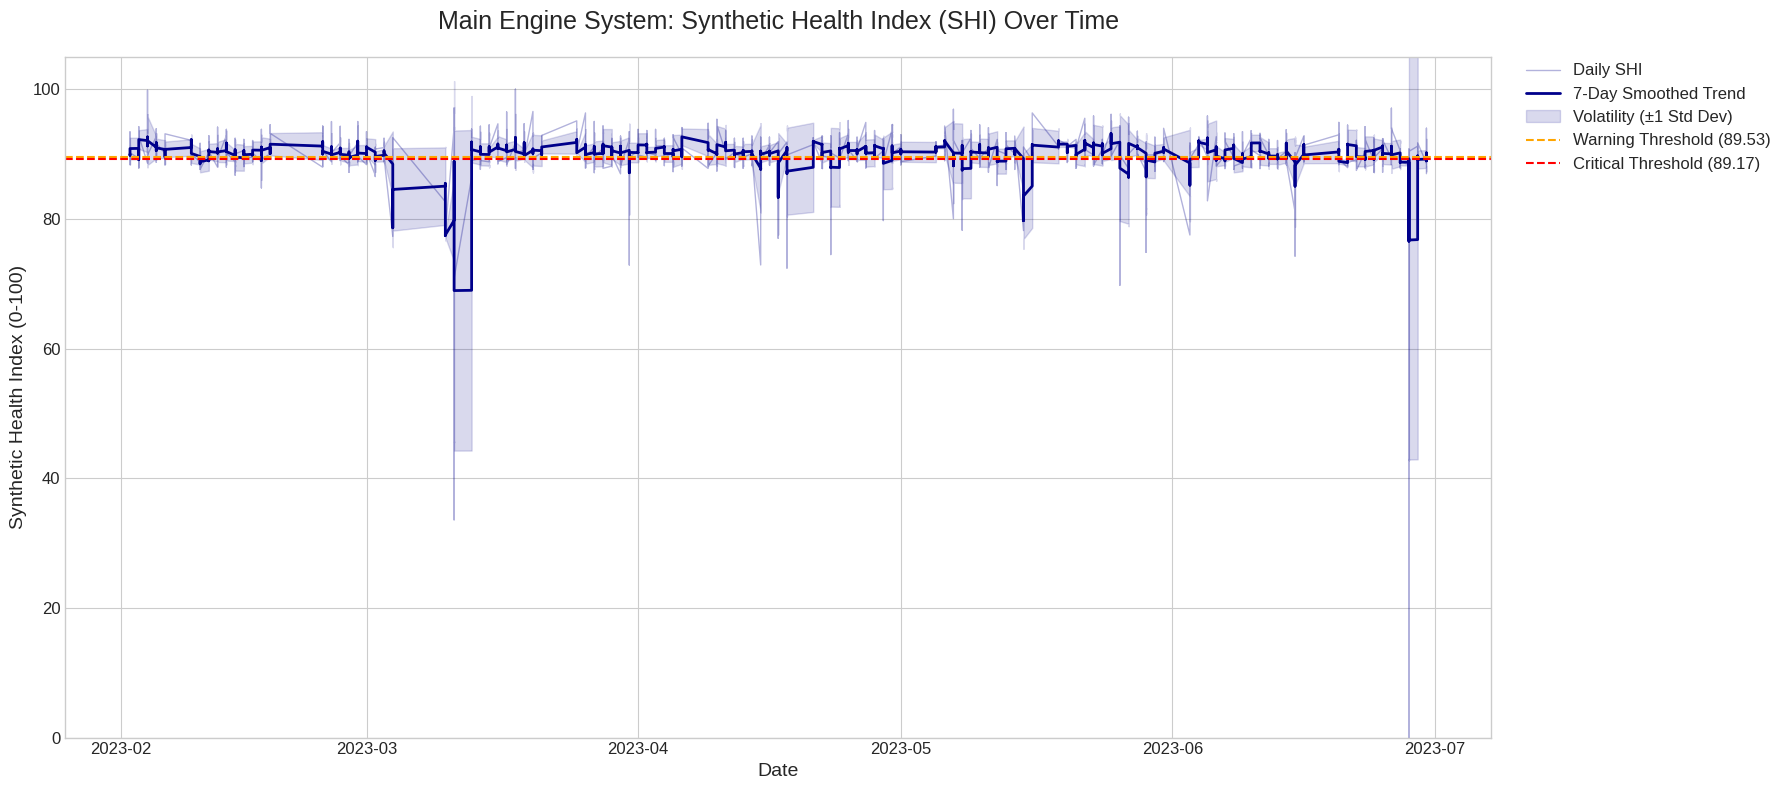

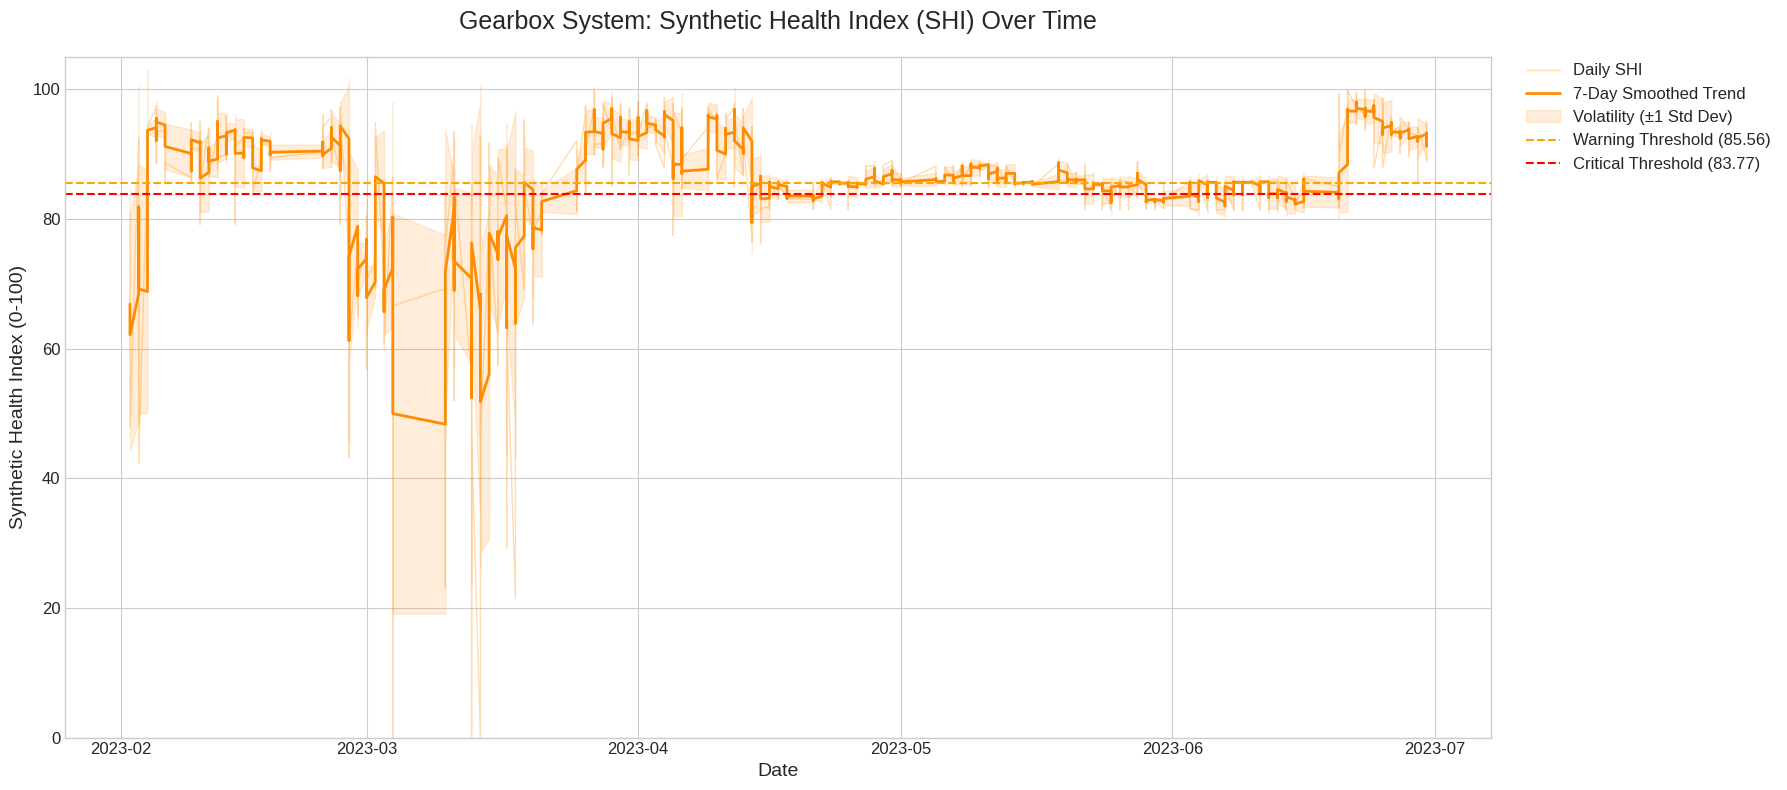

In [ ]:
# generate_shi_merged.py
# This script generates the Synthetic Health Index used to train the LSTM

import importlib
import master_config
importlib.reload(master_config) # Forces Python to re-read the config file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
import json
import seaborn as sns

# Import the master configuration file
import master_config as cfg

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Helper Functions ---

def load_and_prepare_data(file_path):
    """Loads the combined anomaly data and prepares it for SHI calculation."""
    logger.info(f"Attempting to load data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path)
        logger.info(f"File loaded successfully. Shape: {df.shape}")
    except FileNotFoundError:
        logger.error(f"FATAL: File not found at '{file_path}'. Please run the anomaly_comparison.py script first.")
        raise SystemExit(1)

    df.columns = df.columns.str.strip()
    df[cfg.DATE_COLUMN] = pd.to_datetime(df[cfg.DATE_COLUMN])
    df = df.set_index(cfg.DATE_COLUMN).sort_index()
    logger.info("Data sorted by Date and index set.")
    return df

def perform_mode_aware_normalization(df):
    """
    Performs Mode-Aware Z-score normalization and saves the normalization parameters.
    """
    logger.info("Performing Mode-Aware Normalization (Z-score within each operational mode)...")

    normalization_params = {}
    all_anomaly_cols = cfg.ANOMALY_SCORE_COLS['ME'] + cfg.ANOMALY_SCORE_COLS['GB']
    mode_col = 'Operational_Mode'

    for col in all_anomaly_cols:
        if col not in df.columns:
            logger.warning(f"Column '{col}' not found in DataFrame. Skipping normalization for it.")
            continue

        norm_col_name = f"{col}_norm"
        mode_stats = df.groupby(mode_col)[col].agg(['mean', 'std']).to_dict()
        normalization_params[col] = mode_stats

        def z_score(x):
            std = x.std()
            if std == 0 or np.isnan(std): return 0
            return (x - x.mean()) / std

        df[norm_col_name] = df.groupby(mode_col)[col].transform(z_score)

    logger.info("Mode-Aware Normalization complete.")

    params_path = os.path.join(cfg.FROZEN_ASSETS_DIR, 'shi_normalization_params.json')
    with open(params_path, 'w') as f:
        json.dump(normalization_params, f, indent=4)
    logger.info(f"Normalization parameters (mean/std) frozen to '{params_path}'")

    return df

def calculate_shi_and_features(df, component_prefix):
    """
    MERGED FUNCTION: Calculates a weighted SHI, engineers all related features
    from Snippet 1, and also calculates the thresholds required by Snippet 2's plot.
    """
    logger.info(f"Calculating SHI and all features for component: {component_prefix}...")

    # Define column names from config
    shi_col = getattr(cfg, f'SHI_COLUMN_{component_prefix}')
    shi_change_col = getattr(cfg, f'SHI_CHANGE_{component_prefix}')
    eol_flag_col = getattr(cfg, f'EOL_FLAG_{component_prefix}')

    norm_cols = [f"{c}_norm" for c in cfg.ANOMALY_SCORE_COLS[component_prefix] if f"{c}_norm" in df.columns]

    if not norm_cols:
        logger.warning(f"No normalized score columns found for {component_prefix}. Skipping.")
        # Create empty columns to ensure dataframe consistency
        for col in [shi_col, shi_change_col, f'{shi_col}_MA_Short', f'{shi_col}_MA_Long', eol_flag_col]:
            df[col] = np.nan
        return df, {} # Return empty dataframe and empty thresholds dict

    # --- Calculation from Snippet 1 ---
    weighted_anomaly_sum = sum(df[col] * cfg.COMPONENT_SHI_WEIGHTS[col.replace('_norm', '')] for col in norm_cols)
    total_weight = sum(cfg.COMPONENT_SHI_WEIGHTS[col.replace('_norm', '')] for col in norm_cols)
    composite_anomaly = weighted_anomaly_sum / total_weight

    # Invert and scale to create the SHI (0-100 range for better plotting)
    df[shi_col] = -composite_anomaly
    df[shi_col] = (df[shi_col] - df[shi_col].min()) / (df[shi_col].max() - df[shi_col].min()) * 100
    logger.info(f"    Calculated and scaled SHI (0-100) for {component_prefix}.")

    # --- Feature Engineering from Snippet 1 ---
    df[shi_change_col] = df[shi_col].diff(periods=cfg.SHI_CHANGE_RATE_WINDOW)
    df[f'{shi_col}_MA_Short'] = df[shi_col].rolling(window=cfg.SHI_MA_SHORT_WINDOW).mean()
    df[f'{shi_col}_MA_Long'] = df[shi_col].rolling(window=cfg.SHI_MA_LONG_WINDOW).mean()

    # --- Threshold Calculation (for Snippet 2's plot) ---
    thresholds = {
        'Warning': np.percentile(df[shi_col].dropna(), 35), # Example: 35th percentile
        'Critical': np.percentile(df[shi_col].dropna(), cfg.SHI_CRITICAL_PERCENTILE) # From config
    }

    df[eol_flag_col] = (df[shi_col] < thresholds['Critical']).astype(int)
    logger.info(f"    Engineered features for {component_prefix} (Change, MAs, EOL Flag).")
    logger.info(f"    Calculated thresholds: Warning={thresholds['Warning']:.2f}, Critical={thresholds['Critical']:.2f}")

    return df, thresholds


def plot_and_save_shi_trend(df, component_prefix, thresholds, rolling_window=7):
    """
    VISUALIZATION FROM SNIPPET 2: Generates a rich, combined plot showing raw SHI,
    a smoothed trend, volatility, and thresholds, then saves it to a file.
    """
    component_name = 'Main Engine' if component_prefix == 'ME' else 'Gearbox'
    color = 'darkblue' if component_prefix == 'ME' else 'darkorange'
    shi_col = getattr(cfg, f'SHI_COLUMN_{component_prefix}')

    if shi_col not in df.columns or df[shi_col].isnull().all():
        logger.warning(f"SHI column for {component_name} is empty. Skipping plot.")
        return

    logger.info(f"Generating combined visualization for {component_name}...")

    # Calculate rolling statistics for the trend and volatility
    rolling_mean = df[shi_col].rolling(window=rolling_window).mean()
    rolling_std = df[shi_col].rolling(window=rolling_window).std()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 8))

    # 1. Plot the raw SHI data as a faint, thin line
    ax.plot(df.index, df[shi_col], color=color, alpha=0.3, linewidth=1.0, label='Daily SHI')

    # 2. Plot the smoothed trend line (rolling mean)
    ax.plot(df.index, rolling_mean, color=color, linewidth=2.0, label=f'{rolling_window}-Day Smoothed Trend')

    # 3. Add the shaded volatility band
    ax.fill_between(df.index,
                      rolling_mean - rolling_std,
                      rolling_mean + rolling_std,
                      color=color, alpha=0.15, label='Volatility (±1 Std Dev)')

    # 4. Add the threshold lines
    if thresholds:
        ax.axhline(y=thresholds['Warning'], color='orange', linestyle='--', linewidth=1.5,
                   label=f"Warning Threshold ({thresholds['Warning']:.2f})")
        ax.axhline(y=thresholds['Critical'], color='red', linestyle='--', linewidth=1.5,
                   label=f"Critical Threshold ({thresholds['Critical']:.2f})")

    # Aesthetics and labels
    ax.set_title(f'{component_name} System: Synthetic Health Index (SHI) Over Time', fontsize=18, pad=20)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Synthetic Health Index (0-100)', fontsize=14)
    ax.set_ylim(0, 105)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    plot_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, f'final_shi_trend_{component_prefix}.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Combined plot for {component_name} saved to: {plot_path}")
    plt.show()
    plt.close(fig)


def main():
    """Main execution pipeline for SHI generation and feature engineering."""
    logger.info("--- Starting Merged SHI Generation & Feature Engineering ---")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.COMBINED_ANOMALIES_FILENAME)
    master_df = load_and_prepare_data(input_path)

    master_df = perform_mode_aware_normalization(master_df)

    # Calculate features and get thresholds for plotting
    master_df, me_thresholds = calculate_shi_and_features(master_df, 'ME')
    master_df, gb_thresholds = calculate_shi_and_features(master_df, 'GB')

    # Fill NaNs created by rolling windows/diffs at the start of the dataframe
    master_df.fillna(0, inplace=True)
    logger.info("Filled remaining NaN values with 0.")

    # Call the new, combined plotting function for each component
    plot_and_save_shi_trend(master_df, 'ME', me_thresholds)
    plot_and_save_shi_trend(master_df, 'GB', gb_thresholds)

    output_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    master_df.to_csv(output_path)
    logger.info(f"--- SHI Generation Complete. Final output saved to: {output_path} ---")

if __name__ == '__main__':
    main()


In [ ]:
# =============================================================================
# FINAL SCRIPT - V7.7 (Definitive - Best Features & Best Reporting)
# This script combines the robust reporting of V7.6 with the focused,
# high-performing 3-feature set from V7.3 for optimal, clear results.
# It is designed to work with the improved master_config.py file.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime
import random
import joblib
from io import StringIO
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the configuration file
import master_config as cfg

# --- 2. Setup Logging & Reproducibility ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# --- 3. Helper Functions ---

def load_processed_data(file_path):
    """Loads the SHI data from a given file path."""
    logger.info(f"Loading final SHI data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
        return df
    except FileNotFoundError:
        logger.error(f"FATAL: File not found at '{file_path}'.")
        raise SystemExit(1)

def create_sequences(data, look_back):
    """Transforms a 2D array into 3D sequences for the LSTM."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    """Builds the LSTM model and captures its summary as a string."""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(cfg.LSTM_UNITS_LAYER_1, return_sequences=True),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        LSTM(cfg.LSTM_UNITS_LAYER_2, return_sequences=False),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        Dense(1, activation='linear')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=cfg.LSTM_LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    stream = StringIO()
    sys.stdout = stream
    model.summary()
    sys.stdout = sys.__stdout__
    model_summary_string = stream.getvalue()

    return model, model_summary_string

def plot_training_history(history, component):
    """Plots and saves the training history."""
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Training History for {component}', fontsize=16)
    plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plot_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'lstm_{component.lower()}_training_history.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.close()

def plot_forecast(actuals, predictions, date_index, component):
    """Plots and saves the forecast vs. actuals."""
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))
    plt.plot(date_index, actuals, color='royalblue', label='Actual SHI', linewidth=2.5)
    plt.plot(date_index, predictions, color='darkorange', label='Predicted SHI', linestyle='--', linewidth=2.5)
    plt.title(f'LSTM Forecast vs. Actuals for {component}_SHI', fontsize=18, weight='bold')
    plt.xlabel('Date', fontsize=14); plt.ylabel('Health Index (SHI)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plot_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'lstm_{component.lower()}_forecast_final.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.close()

def generate_evaluation_report(component, metrics, model_summary, features, data_splits, model_path, scaler_path):
    """Generates and saves a detailed evaluation report."""
    report_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'evaluation_report_{component.lower()}.txt')
    with open(report_path, 'w') as f:
        f.write(f"{'='*30}\n LSTM MODEL EVALUATION REPORT: {component} \n{'='*30}\n\n")
        f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("--- Performance on Unseen Test Set ---\n")
        f.write(f"Mean Absolute Error (MAE): {metrics['mae']:.5f}\n")
        f.write(f"Root Mean Squared Error (RMSE): {metrics['rmse']:.5f}\n")
        f.write(f"R-squared (R2 Score): {metrics['r2']:.5f}\n\n")
        f.write("--- Model & Training Configuration ---\n")
        f.write(f"Look-back Window (Timesteps): {cfg.LOOK_BACK_WINDOW}\n")
        f.write(f"Epochs: {cfg.LSTM_EPOCHS}\n")
        f.write(f"Batch Size: {cfg.LSTM_BATCH_SIZE}\n\n")
        f.write("--- Data Information ---\n")
        f.write(f"Training Samples: {data_splits['train']}\n")
        f.write(f"Validation Samples: {data_splits['val']}\n")
        f.write(f"Test Samples: {data_splits['test']}\n\n")
        f.write("--- Input Features Used ---\n")
        for feature in features:
            f.write(f"- {feature}\n")
        f.write("\n--- Saved Asset Paths ---\n")
        f.write(f"Model File: {model_path}\n")
        f.write(f"Scaler File: {scaler_path}\n\n")
        f.write("--- Model Architecture ---\n")
        f.write(model_summary)
    logger.info(f"Evaluation report for {component} saved to: {report_path}")

# --- 4. Main Execution Block ---
def main():
    set_all_seeds(cfg.GLOBAL_RANDOM_SEED)
    logger.info("--- Starting Final LSTM Training Script (V7.7 - Optimal Features & Reporting) ---")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    full_df = load_processed_data(input_path)

    for component in ['ME', 'GB']:
        logger.info(f"\n{'='*25} Processing Component: {component} {'='*25}")

        # [DEFINITIVE FIX] Manually define the simple, high-performing feature set.
        # This overrides any list in the config file to ensure optimal performance.
        features_to_use = [
            getattr(cfg, f'SHI_COLUMN_{component}'),
            getattr(cfg, f'SHI_CHANGE_{component}'),
            cfg.RPM_COLUMN
        ]
        target_col = getattr(cfg, f'SHI_COLUMN_{component}')
        logger.info(f"Using focused, high-performance feature set: {features_to_use}")

        features_ordered = [target_col] + [f for f in features_to_use if f != target_col]
        component_df = full_df[features_ordered].dropna()

        # Robust train-validate-test split
        train_val_df, test_df = train_test_split(component_df, test_size=0.15, shuffle=False)
        train_df, val_df = train_test_split(train_val_df, test_size=0.15, shuffle=False)
        data_splits = {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)}
        logger.info(f"Data split sizes: {data_splits}")

        # Split-then-scale methodology
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train = create_sequences(train_scaled, cfg.LOOK_BACK_WINDOW)
        X_val, y_val = create_sequences(val_scaled, cfg.LOOK_BACK_WINDOW)
        X_test, y_test = create_sequences(test_scaled, cfg.LOOK_BACK_WINDOW)

        model, model_summary_str = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

        model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component.lower()}.keras')
        early_stopping = EarlyStopping(monitor='val_loss', patience=cfg.LSTM_EARLY_STOPPING_PATIENCE, mode='min')
        model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')

        history = model.fit(
            X_train, y_train,
            epochs=cfg.LSTM_EPOCHS, batch_size=cfg.LSTM_BATCH_SIZE,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )
        plot_training_history(history, component)

        # Load best model and evaluate
        best_model = tf.keras.models.load_model(model_path)
        predictions_scaled = best_model.predict(X_test)

        # Inverse transform
        num_features = len(features_ordered)
        dummy_preds = np.zeros((len(predictions_scaled), num_features))
        dummy_preds[:, 0] = predictions_scaled.flatten()
        predictions = scaler.inverse_transform(dummy_preds)[:, 0]
        dummy_actuals = np.zeros((len(y_test), num_features))
        dummy_actuals[:, 0] = y_test.flatten()
        actuals = scaler.inverse_transform(dummy_actuals)[:, 0]

        # Calculate metrics for the report
        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        r2 = r2_score(actuals, predictions)
        metrics = {'mae': mae, 'rmse': rmse, 'r2': r2}

        logger.info(f"--- Final Evaluation for {component} ---")
        logger.info(f"Test Set MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")

        # Plot forecast and freeze assets
        test_start_index = len(train_df) + len(val_df) + cfg.LOOK_BACK_WINDOW
        date_index = component_df.index[test_start_index : test_start_index + len(actuals)]
        plot_forecast(actuals, predictions, date_index, component)

        scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component.lower()}.pkl')
        joblib.dump(scaler, scaler_path)
        logger.info(f"Saved {component} assets to {cfg.FROZEN_ASSETS_DIR}")

        # Generate the final text report
        generate_evaluation_report(
            component=component, metrics=metrics, model_summary=model_summary_str,
            features=features_ordered, data_splits=data_splits,
            model_path=model_path, scaler_path=scaler_path
        )

    logger.info("\n--- LSTM Training, Evaluation & Reporting Complete. ---")

if __name__ == '__main__':
    main()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# final_report_simulation.py
# This script loads all frozen models and scalers to simulate a daily
# operational report, saves the raw report data to a CSV, and generates
# a 30-day predictive trajectory forecast plot.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime, timedelta
import joblib
# ### Removed: import importlib


import tensorflow as tf
# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

# Import the master configuration file
import master_config as cfg
# ### Removed: importlib.reload(master_config)


# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Asset Loading Function ---
def load_frozen_assets():
    """
    Loads all pre-trained, frozen models and scalers from the assets directory.
    """
    logger.info("--- Loading all frozen assets from disk ---")
    assets = {}
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()

        # Load Forecasting/Regression Model & Scaler
        # ### MODIFIED: Access path directly from cfg ###
        model_path_reg = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}.keras') # Assuming .keras is used from previous steps
        scaler_path_reg = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}.pkl') # Assuming .pkl is used

        try:
            assets[component]['regressor'] = tf.keras.models.load_model(model_path_reg)
            assets[component]['scaler_reg'] = joblib.load(scaler_path_reg)
        except FileNotFoundError:
            logger.error(f"FATAL: Regression assets for {component} not found. Expected: {model_path_reg}, {scaler_path_reg}")
            raise

        # Load Early Warning/Classification Model & Scaler
        # ### MODIFIED: Access path directly from cfg ###
        model_path_class = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component_lower}.keras') # Assuming .keras is used
        scaler_path_class = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component_lower}.pkl') # Assuming .pkl is used

        try:
            assets[component]['classifier'] = tf.keras.models.load_model(model_path_class)
            assets[component]['scaler_class'] = joblib.load(scaler_path_class)
        except FileNotFoundError:
             logger.error(f"FATAL: Classification assets for {component} not found. Expected: {model_path_class}, {scaler_path_class}")
             raise


        logger.info(f"Successfully loaded 4 assets for component {component}.")
    return assets

# --- Alert System Logic ---
def get_alert_level(probability, component):
    # ### MODIFIED: Access thresholds directly from cfg ###
    thresholds = cfg.COMPONENT_ALERT_THRESHOLDS[component]
    if probability >= thresholds[3]: return 3
    if probability >= thresholds[2]: return 2
    if probability >= thresholds[1]: return 1
    return 0

# --- Trajectory Forecasting Logic ---
def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features):
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    # ### MODIFIED: Access FORECAST_DAYS directly from cfg ###
    for _ in range(cfg.FORECAST_DAYS):
        # Ensure the model is called correctly with the sequence length
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        # Prepare the next input window by shifting the window and adding the prediction
        new_step = current_window[-1, :].reshape(1, num_features)
        new_step[0, 0] = next_pred_scaled # Assuming SHI is the first feature

        current_window = np.append(current_window[1:, :], new_step, axis=0)

    # ### MODIFIED: Access FORECAST_DAYS directly from cfg ###
    dummy_array = np.zeros((cfg.FORECAST_DAYS, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- Main Execution Block ---
def main():
    logger.info("--- Generating Final Project Report: Alerts and Trajectory ---")

    # ### MODIFIED: Access FILENAME and Directory directly from cfg ###
    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    # ### MODIFIED: Access DATE_COLUMN directly from cfg ###
    df_full = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    df_full.columns = df_full.columns.str.strip()

    assets = load_frozen_assets()

    # --- PART 1: Simulate Daily Alert Report ---
    # ### MODIFIED: Access SIMULATION_DAYS directly from cfg ###
    logger.info(f"\n\n--- SIMULATING DAILY OPERATIONS ALERT REPORT (LAST {cfg.SIMULATION_DAYS} READINGS) ---")
    # ### MODIFIED: Access SIMULATION_DAYS directly from cfg ###
    simulation_df = df_full.iloc[-cfg.SIMULATION_DAYS:].copy()

    report_data = [] # List to collect data for the CSV report

    for date, row in simulation_df.iterrows():
        # Ensure the history window is based on the full dataset up to the current date
        # ### MODIFIED: Access LOOK_BACK_WINDOW directly from cfg ###
        history_window_df = df_full.loc[:date].iloc[-cfg.LOOK_BACK_WINDOW:]
        # Check if we have enough history to form the look-back window
        # ### MODIFIED: Access LOOK_BACK_WINDOW directly from cfg ###
        if len(history_window_df) < cfg.LOOK_BACK_WINDOW:
            # ### MODIFIED: Access LOOK_BACK_WINDOW directly from cfg ###
            logger.warning(f"Skipping report for {date.date()}: Not enough historical data ({len(history_window_df)} days) for look-back window ({cfg.LOOK_BACK_WINDOW}).")
            continue


        print(f"\n{'='*70}\nDAILY OPERATIONS REPORT FOR: {date.date()}\n{'-'*70}")

        daily_report_entry = {'Date': date.date()}

        for component in ['ME', 'GB']:
            asset_pack = assets[component]
            # ### MODIFIED: Access features directly from cfg ###
            features = getattr(cfg, f'LSTM_FEATURES_{component}')

            # Ensure the history window has the expected features for scaling
            if not all(f in history_window_df.columns for f in features):
                logger.error(f"Missing features for {component} in history data for {date.date()}. Expected {features}, found {list(history_window_df.columns)}. Skipping prediction.")
                # Add placeholder values and skip prediction for this component on this date
                daily_report_entry[f'{component}_Current_SHI'] = row[f'{component}_SHI'] if f'{component}_SHI' in row else np.nan
                daily_report_entry[f'{component}_Warning_Prob'] = np.nan
                continue # Skip prediction for this component

            # Ensure the scaler is fitted on the training data features and applied to the correct data subset
            # The scaler was fitted during training on the specific feature list.
            # We need to apply it to the history window using the same feature list.
            try:
                input_scaled = asset_pack['scaler_class'].transform(history_window_df[features])
            except ValueError as e:
                 logger.error(f"Error scaling data for {component} on {date.date()}: {e}. Check if features match scaler.")
                 # Add placeholder values and skip prediction for this component on this date
                 daily_report_entry[f'{component}_Current_SHI'] = row[f'{component}_SHI'] if f'{component}_SHI' in row else np.nan
                 daily_report_entry[f'{component}_Warning_Prob'] = np.nan
                 continue # Skip prediction for this component


            # The input to the model predict needs to be shaped as (1, look_back_window, num_features)
            input_for_prediction = np.expand_dims(input_scaled, axis=0)

            prob = asset_pack['classifier'].predict(input_for_prediction, verbose=0)[0][0]
            alert_level = get_alert_level(prob, component)

            print(f"COMPONENT: {component.upper()}")
            # ### MODIFIED: Access SHI column name directly from cfg ###
            print(f"  - Current SHI: {row[getattr(cfg, f'SHI_COLUMN_{component}')]:.3f}")
            # ### MODIFIED: Access CLASSIFICATION_PREDICTION_WINDOW directly from cfg ###
            print(f"  - {cfg.CLASSIFICATION_PREDICTION_WINDOW}-Day Warning Probability: {prob:.1%}")
            # ### MODIFIED: Access ALERT_LEVELS directly from cfg ###
            print(f"  - ALERT LEVEL: {cfg.ALERT_LEVELS[alert_level]['Name']}")
            # ### MODIFIED: Access ALERT_LEVELS directly from cfg ###
            print(f"  - Recommendation: {cfg.ALERT_LEVELS[alert_level]['Recommendation']}")
            if component == 'ME': print(f"--------------------------------------------------")

            # Add data for this component to the daily entry
            # ### MODIFIED: Access SHI column name directly from cfg ###
            daily_report_entry[f'{component}_Current_SHI'] = row[getattr(cfg, f'SHI_COLUMN_{component}')]
            daily_report_entry[f'{component}_Warning_Prob'] = prob

        report_data.append(daily_report_entry)

    # --- Create and save the raw simulation data for the dashboard script ---
    report_df = pd.DataFrame(report_data)
    # ### MODIFIED: Access SIMULATION_CSV_FILENAME and OUTPUT_DIR directly from cfg ###
    report_csv_path = os.path.join(cfg.OUTPUT_DIR, cfg.SIMULATION_CSV_FILENAME)
    report_df.to_csv(report_csv_path, index=False)
    logger.info(f"\nRaw daily simulation data saved to '{report_csv_path}' for dashboard generation.")

    # --- PART 2: Generate and Plot Final Trajectory Forecast ---
    # ### MODIFIED: Access FORECAST_DAYS directly from cfg ###
    logger.info(f"\n\n--- GENERATING {cfg.FORECAST_DAYS}-DAY PREDICTIVE TRAJECTORY FORECAST ---")
    # ### MODIFIED: Access PLOT_WIDTH and PLOT_HEIGHT directly from cfg ###
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT)); plt.style.use('seaborn-v0_8-whitegrid')

    # Get the last 'LOOK_BACK_WINDOW' days of data for the forecast starting point
    # ### MODIFIED: Access LOOK_BACK_WINDOW directly from cfg and add copy() ###
    history_plot_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:].copy()


    for component in ['ME', 'GB']:
        asset_pack = assets[component]
        # ### MODIFIED: Access features directly from cfg ###
        features = getattr(cfg, f'LSTM_FEATURES_{component}')

        # Ensure the history data has the correct features for scaling
        if not all(f in history_plot_df.columns for f in features):
             logger.warning(f"Features in history data do not match features used for {component} regressor. Skipping forecast plot for {component}.")
             continue # Skip if features don't match


        recent_data_scaled = asset_pack['scaler_reg'].transform(history_plot_df[features])

        forecast = generate_forecast_trajectory(
            asset_pack['regressor'], asset_pack['scaler_reg'],
            recent_data_scaled, len(features)
        )

        # ### MODIFIED: Access FORECAST_DAYS directly from cfg ###
        future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, cfg.FORECAST_DAYS + 1)]
        color = 'royalblue' if component == 'ME' else 'darkorange'
        plt.plot(future_dates, forecast, marker='o', linestyle='--', color=color, label=f'Predicted {component} SHI Trajectory')

    # Plot historical data up to the start of the forecast
    # ### MODIFIED: Access SHI column names directly from cfg ###
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_ME], label='Historical ME SHI', color='royalblue')
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_GB], label='Historical GB SHI', color='darkorange')


    # ### MODIFIED: Access FORECAST_DAYS directly from cfg ###
    plt.title(f'{cfg.FORECAST_DAYS}-Day Predictive Trajectory Forecast', fontsize=18, weight='bold')
    plt.xlabel('Date'); plt.ylabel('Health Index (SHI)')
    plt.legend(fontsize=12); plt.grid(True, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # ### MODIFIED: Access OUTPUT_DIR and PLOT_DPI directly from cfg ###
    plot_path = os.path.join(cfg.OUTPUT_DIR, 'final_trajectory_forecast.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Final trajectory plot saved to: {plot_path}")
    plt.show()

if __name__ == '__main__':
    main()

In [ ]:
# final_report_generation.py
# This script loads all frozen models and scalers to simulate a daily
# operational report, saves the raw report data to a CSV, and generates
# static plot images for inclusion in a final report.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

# Import the master configuration file
import master_config as cfg

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Asset Loading Function ---
def load_frozen_assets():
    """
    Loads all pre-trained, frozen models and scalers from the assets directory.
    """
    logger.info("--- Loading all frozen assets from disk ---")
    assets = {}
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()

        # Load Forecasting/Regression Model & Scaler
        model_path_reg = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}.keras')
        scaler_path_reg = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}.pkl')

        try:
            assets[component]['regressor'] = tf.keras.models.load_model(model_path_reg)
            assets[component]['scaler_reg'] = joblib.load(scaler_path_reg)
        except FileNotFoundError:
            logger.error(f"FATAL: Regression assets for {component} not found. Expected: {model_path_reg}, {scaler_path_reg}")
            raise

        # Load Early Warning/Classification Model & Scaler
        model_path_class = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component_lower}.keras')
        scaler_path_class = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component_lower}.pkl')

        try:
            assets[component]['classifier'] = tf.keras.models.load_model(model_path_class)
            assets[component]['scaler_class'] = joblib.load(scaler_path_class)
        except FileNotFoundError:
             logger.error(f"FATAL: Classification assets for {component} not found. Expected: {model_path_class}, {scaler_path_class}")
             raise

        logger.info(f"Successfully loaded 4 assets for component {component}.")
    return assets

# --- Alert System Logic ---
def get_alert_level(probability, component):
    thresholds = cfg.COMPONENT_ALERT_THRESHOLDS[component]
    if probability >= thresholds[3]: return 3
    if probability >= thresholds[2]: return 2
    if probability >= thresholds[1]: return 1
    return 0

# --- Trajectory Forecasting Logic ---
def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features):
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    for _ in range(cfg.FORECAST_DAYS):
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        new_step = current_window[-1, :].reshape(1, num_features)
        new_step[0, 0] = next_pred_scaled
        current_window = np.append(current_window[1:, :], new_step, axis=0)

    dummy_array = np.zeros((cfg.FORECAST_DAYS, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- NEW: Plotting Functions for Static Reports ---

def plot_trajectory_forecast(history_df, forecast_data, output_dir):
    """Generates and saves a static trajectory forecast plot."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))

    # Plot historical data
    ax.plot(history_df.index, history_df[cfg.SHI_COLUMN_ME], label='Historical ME SHI', color='royalblue', linewidth=2)
    ax.plot(history_df.index, history_df[cfg.SHI_COLUMN_GB], label='Historical GB SHI', color='darkorange', linewidth=2)

    # Plot forecasted data
    for component, data in forecast_data.items():
        color = 'royalblue' if component == 'ME' else 'darkorange'
        ax.plot(data['dates'], data['forecast'], marker='o', linestyle='--', color=color, label=f'Predicted {component} SHI Trajectory')

    ax.set_title(f'{cfg.FORECAST_DAYS}-Day Predictive Trajectory Forecast', fontsize=18, weight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Health Index (SHI)', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    fig.tight_layout()

    # Save the plot
    plot_path = os.path.join(output_dir, 'static_trajectory_forecast.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Static trajectory plot saved to: {plot_path}")
    plt.close(fig) # Close the figure to free up memory

def plot_alert_levels(report_df, output_dir):
    """Generates and saves a static plot of recent alert levels."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT / 1.5)) # Make it wider than it is tall

    # Convert probabilities to alert levels for plotting
    report_df['ME_Alert_Level'] = report_df['ME_Warning_Prob'].apply(lambda p: get_alert_level(p, 'ME'))
    report_df['GB_Alert_Level'] = report_df['GB_Warning_Prob'].apply(lambda p: get_alert_level(p, 'GB'))

    # Set dates as index for plotting
    plot_df = report_df.set_index('Date')

    # Plotting the alert levels over time
    ax.plot(plot_df.index, plot_df['ME_Alert_Level'], marker='s', linestyle='-', color='C0', label='ME Alert Level')
    ax.plot(plot_df.index, plot_df['GB_Alert_Level'], marker='^', linestyle='-', color='C1', label='GB Alert Level')

    ax.set_title(f'Daily Alert Levels (Last {cfg.SIMULATION_DAYS} Days)', fontsize=18, weight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Alert Level', fontsize=12)
    ax.set_yticks([0, 1, 2, 3]) # Set y-ticks to only be the alert levels
    ax.set_yticklabels(['Level 0', 'Level 1', 'Level 2', 'Level 3'])
    ax.legend(fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    fig.tight_layout()

    # Save the plot
    plot_path = os.path.join(output_dir, 'static_daily_alerts.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Static daily alerts plot saved to: {plot_path}")
    plt.close(fig) # Close the figure

# --- Main Execution Block ---
def main():
    logger.info("--- Generating Final Project Report Assets: Alerts and Plots ---")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    df_full = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    df_full.columns = df_full.columns.str.strip()

    assets = load_frozen_assets()

    # --- PART 1: Simulate Daily Alert Report ---
    logger.info(f"\n\n--- SIMULATING DAILY OPERATIONS ALERT REPORT (LAST {cfg.SIMULATION_DAYS} READINGS) ---")
    simulation_df = df_full.iloc[-cfg.SIMULATION_DAYS:].copy()
    report_data = []

    for date, row in simulation_df.iterrows():
        history_window_df = df_full.loc[:date].iloc[-cfg.LOOK_BACK_WINDOW:]
        if len(history_window_df) < cfg.LOOK_BACK_WINDOW:
            logger.warning(f"Skipping report for {date.date()}: Not enough historical data.")
            continue

        print(f"\n{'='*70}\nDAILY OPERATIONS REPORT FOR: {date.date()}\n{'-'*70}")
        daily_report_entry = {'Date': date.date()}

        for component in ['ME', 'GB']:
            asset_pack = assets[component]
            features = getattr(cfg, f'LSTM_FEATURES_{component}')

            if not all(f in history_window_df.columns for f in features):
                logger.error(f"Missing features for {component} on {date.date()}. Skipping.")
                daily_report_entry[f'{component}_Current_SHI'] = row.get(f'{component}_SHI', np.nan)
                daily_report_entry[f'{component}_Warning_Prob'] = np.nan
                continue

            try:
                input_scaled = asset_pack['scaler_class'].transform(history_window_df[features])
            except ValueError as e:
                 logger.error(f"Error scaling data for {component} on {date.date()}: {e}.")
                 daily_report_entry[f'{component}_Current_SHI'] = row.get(f'{component}_SHI', np.nan)
                 daily_report_entry[f'{component}_Warning_Prob'] = np.nan
                 continue

            input_for_prediction = np.expand_dims(input_scaled, axis=0)
            prob = asset_pack['classifier'].predict(input_for_prediction, verbose=0)[0][0]
            alert_level = get_alert_level(prob, component)

            print(f"COMPONENT: {component.upper()}")
            print(f"  - Current SHI: {row[getattr(cfg, f'SHI_COLUMN_{component}')]:.3f}")
            print(f"  - {cfg.CLASSIFICATION_PREDICTION_WINDOW}-Day Warning Probability: {prob:.1%}")
            print(f"  - ALERT LEVEL: {cfg.ALERT_LEVELS[alert_level]['Name']}")
            print(f"  - Recommendation: {cfg.ALERT_LEVELS[alert_level]['Recommendation']}")
            if component == 'ME': print(f"--------------------------------------------------")

            daily_report_entry[f'{component}_Current_SHI'] = row[getattr(cfg, f'SHI_COLUMN_{component}')]
            daily_report_entry[f'{component}_Warning_Prob'] = prob
        report_data.append(daily_report_entry)

    report_df = pd.DataFrame(report_data)
    report_csv_path = os.path.join(cfg.OUTPUT_DIR, cfg.SIMULATION_CSV_FILENAME)
    report_df.to_csv(report_csv_path, index=False)
    logger.info(f"\nRaw daily simulation data saved to '{report_csv_path}'.")

    # --- PART 2: Generate Forecast Data ---
    logger.info(f"\n\n--- GENERATING {cfg.FORECAST_DAYS}-DAY PREDICTIVE TRAJECTORY FORECAST DATA ---")
    history_plot_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:].copy()
    forecast_results = {}

    for component in ['ME', 'GB']:
        asset_pack = assets[component]
        features = getattr(cfg, f'LSTM_FEATURES_{component}')

        if not all(f in history_plot_df.columns for f in features):
             logger.warning(f"Features mismatch for {component} regressor. Skipping forecast for this component.")
             continue

        recent_data_scaled = asset_pack['scaler_reg'].transform(history_plot_df[features])
        forecast = generate_forecast_trajectory(
            asset_pack['regressor'], asset_pack['scaler_reg'],
            recent_data_scaled, len(features)
        )
        future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, cfg.FORECAST_DAYS + 1)]
        forecast_results[component] = {'dates': future_dates, 'forecast': forecast}
        logger.info(f"Forecast generated for component {component}.")

    # --- PART 3: Generate and Save Static Plots for the Report ---
    logger.info(f"\n\n--- GENERATING AND SAVING STATIC PLOTS FOR REPORT ---")
    if not forecast_results:
        logger.warning("No forecast data was generated, skipping trajectory plot.")
    else:
        plot_trajectory_forecast(history_plot_df, forecast_results, cfg.OUTPUT_DIR)

    if report_df.empty:
        logger.warning("No simulation report data was generated, skipping alerts plot.")
    else:
        plot_alert_levels(report_df.copy(), cfg.OUTPUT_DIR)


if __name__ == '__main__':
    main()

ValueError: File not found: filepath=outputs/frozen_assets/lstm_model_me.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# =============================================================================
# FINAL SCRIPT - V6.5 (COMPLETE & STANDALONE)
# The Hybrid Executive Decision Dashboard
#
# Revision: Fixed "unsupported operand type(s) for *: 'float' and 'NoneType'"
# error in the SHI calculation by ensuring all columns have a weight.
# Revision: Added a check to gracefully handle missing weights or data columns.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import logging
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import the configuration file we created in the first cell
# Ensure master_config.py is in the same directory or accessible
try:
    import master_config as cfg
except ImportError:
    print("FATAL: master_config.py not found. Please create it with the necessary configurations.")
    # As a fallback for demonstration, create a dummy config object
    class DummyConfig:
        DATE_COLUMN = 'Timestamp'
        ANOMALY_SCORE_COLS = {
            'ME': ['ME_Anomaly_Score_1', 'ME_Anomaly_Score_2'],
            'GB': ['GB_Anomaly_Score_1', 'GB_Anomaly_Score_2']
        }
        COMPONENT_SHI_WEIGHTS = {
            'ME_Anomaly_Score_1': 0.6, 'ME_Anomaly_Score_2': 0.4,
            'GB_Anomaly_Score_1': 0.5, 'GB_Anomaly_Score_2': 0.5
        }
        FROZEN_ASSETS_DIR = '.'
        SHI_COLUMN_ME = 'ME_SHI'
        SHI_COLUMN_GB = 'GB_SHI'
        SHI_MA_SHORT_WINDOW = 7
        SHI_MA_LONG_WINDOW = 30
        SHI_CRITICAL_PERCENTILE = 15
        COMPARISON_OUTPUT_DIR = '.'
        OUTPUT_DIR = '.'
        COMBINED_ANOMALIES_FILENAME = 'combined_anomalies.csv'
        FINAL_SHI_FILENAME = 'final_shi_data.csv'
    cfg = DummyConfig()


# --- 2. Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# --- 3. Data Loading and Feature Engineering Functions ---

def load_and_prepare_data(file_path):
    """Loads and prepares the combined anomaly data."""
    logger.info(f"Loading data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        logger.error(f"FATAL: File '{file_path}' not found. Please ensure it is uploaded to the correct directory.")
        raise
    df.columns = df.columns.str.strip()
    df[cfg.DATE_COLUMN] = pd.to_datetime(df[cfg.DATE_COLUMN])
    df = df.set_index(cfg.DATE_COLUMN).sort_index()
    logger.info("Data loaded and prepared successfully.")
    return df

def perform_mode_aware_normalization(df):
    """Performs mode-aware Z-score normalization."""
    logger.info("Performing Mode-Aware Normalization...")
    normalization_params = {}
    all_anomaly_cols = cfg.ANOMALY_SCORE_COLS['ME'] + cfg.ANOMALY_SCORE_COLS['GB']
    mode_col = 'Operational_Mode'

    if mode_col not in df.columns:
        logger.warning(f"'{mode_col}' not found. Performing standard normalization.")
        for col in all_anomaly_cols:
            if col in df.columns:
                norm_col_name = f"{col}_norm"
                mean = df[col].mean()
                std = df[col].std()
                df[norm_col_name] = (df[col] - mean) / std if std > 0 else 0
                normalization_params[col] = {'standard': {'mean': mean, 'std': std}}
        return df

    for col in all_anomaly_cols:
        if col not in df.columns:
            logger.warning(f"Column '{col}' not found. Skipping normalization.")
            continue
        norm_col_name = f"{col}_norm"
        mode_stats = df.groupby(mode_col)[col].agg(['mean', 'std']).to_dict('index')
        normalization_params[col] = mode_stats

        def z_score_mode(row):
            mode = row[mode_col]
            if mode in mode_stats:
                mean = mode_stats[mode]['mean']
                std = mode_stats[mode]['std']
                return (row[col] - mean) / std if std > 0 else 0
            return 0 # Default if mode not in stats

        df[norm_col_name] = df.apply(z_score_mode, axis=1)

    params_path = os.path.join(cfg.FROZEN_ASSETS_DIR, 'shi_normalization_params.json')
    with open(params_path, 'w') as f:
        json.dump(normalization_params, f, indent=4)
    logger.info(f"Normalization parameters frozen to '{params_path}'")
    return df

def calculate_shi_and_features(df, component_prefix):
    """Calculates SHI and all related features."""
    logger.info(f"Calculating SHI and features for {component_prefix}...")
    shi_col = getattr(cfg, f'SHI_COLUMN_{component_prefix}')

    # Filter for normalized columns that actually exist in the DataFrame and have a defined weight
    norm_cols_with_weights = [
        f"{c}_norm" for c in cfg.ANOMALY_SCORE_COLS[component_prefix]
        if f"{c}_norm" in df.columns and c in cfg.COMPONENT_SHI_WEIGHTS
    ]

    if not norm_cols_with_weights:
        logger.warning(f"No normalized score columns with defined weights for {component_prefix}. Skipping.")
        for col_name in [shi_col, f'{shi_col}_MA_Short', f'{shi_col}_MA_Long', f'{shi_col}_Change']:
            df[col_name] = np.nan
        return df, None

    weighted_anomaly_sum = sum(
        df[col] * cfg.COMPONENT_SHI_WEIGHTS[col.replace('_norm', '')]
        for col in norm_cols_with_weights
    )
    total_weight = sum(
        cfg.COMPONENT_SHI_WEIGHTS[col.replace('_norm', '')]
        for col in norm_cols_with_weights
    )

    if total_weight == 0:
        logger.warning(f"Total weight for {component_prefix} is zero. Skipping SHI calculation.")
        for col_name in [shi_col, f'{shi_col}_MA_Short', f'{shi_col}_MA_Long', f'{shi_col}_Change']:
            df[col_name] = np.nan
        return df, None

    composite_anomaly = weighted_anomaly_sum / total_weight
    df[shi_col] = -composite_anomaly
    min_val, max_val = df[shi_col].min(), df[shi_col].max()
    df[shi_col] = (df[shi_col] - min_val) / (max_val - min_val) if (max_val - min_val) > 0 else 0.5
    df[f'{shi_col}_MA_Short'] = df[shi_col].rolling(window=cfg.SHI_MA_SHORT_WINDOW, min_periods=1).mean()
    df[f'{shi_col}_MA_Long'] = df[shi_col].rolling(window=cfg.SHI_MA_LONG_WINDOW, min_periods=1).mean()
    df[f'{shi_col}_Change'] = df[shi_col].diff()
    critical_threshold = np.percentile(df[shi_col].dropna(), cfg.SHI_CRITICAL_PERCENTILE)
    logger.info(f"      Engineered features for {component_prefix} (Threshold: {critical_threshold:.3f}).")
    return df, critical_threshold


# --- 4. Business Logic and Recommendation Helper Functions ---

def get_equipment_status(health_score):
    if pd.isna(health_score): return {'status': 'UNKNOWN', 'color': '#808080'}
    if health_score >= 85: return {'status': '🟢 OPTIMAL', 'color': '#00aa44'}
    elif health_score >= 70: return {'status': '🟢 GOOD', 'color': '#66bb6a'}
    elif health_score >= 50: return {'status': '🟡 MONITOR', 'color': '#ffc107'}
    elif health_score >= 30: return {'status': '🟠 ACTION', 'color': '#ff9800'}
    else: return {'status': '🔴 CRITICAL', 'color': '#f44336'}

def get_risk_assessment(current_health, trend_7d):
    if pd.isna(current_health): return {'level': 'UNKNOWN', 'color': '#808080'}
    if current_health >= 70 and trend_7d >= -1: return {'level': 'LOW', 'color': '#00aa44'}
    elif current_health >= 50 and trend_7d >= -3: return {'level': 'MEDIUM', 'color': '#ff9800'}
    elif current_health >= 30: return {'level': 'HIGH', 'color': '#f44336'}
    else: return {'level': 'CRITICAL', 'color': '#d32f2f'}

def get_recommendation(current_health, trend_7d):
    if pd.isna(current_health): return "Data not available."
    if current_health >= 85: return "Continue standard maintenance schedule."
    elif current_health >= 70: return "Normal operation. Investigate significant new declines."
    elif current_health >= 50: return "Increase monitoring frequency. Plan for inspection."
    elif current_health >= 30: return "<b>URGENT:</b> Schedule immediate inspection."
    else: return "<b>CRITICAL:</b> Consider operational halt for emergency maintenance."

def create_error_dashboard(component, message):
    """Creates a dashboard showing an error message if data is invalid."""
    equipment_name = 'Main Engine' if component == 'ME' else 'Gearbox'
    fig = go.Figure()
    fig.add_annotation(
        text=f"<b>Could not generate dashboard for {equipment_name}</b><br><br>Reason: {message}",
        xref="paper", yref="paper", x=0.5, y=0.5, showarrow=False,
        font=dict(size=20, color="red")
    )
    fig.update_layout(title=f'{equipment_name} - Data Error', height=500)
    return fig


# --- 5. The Definitive Dashboard Creation Function ---

def create_hybrid_executive_dashboard(df, component, threshold):
    """Creates a hybrid dashboard combining executive focus with proper data visualization."""
    # --- Setup & Data Validation ---
    equipment_name = 'Main Engine' if component == 'ME' else 'Gearbox'
    primary_color = '#0d6efd' if component == 'ME' else '#ff7f0e'
    shi_col = getattr(cfg, f'SHI_COLUMN_{component}')

    if df.empty or shi_col not in df.columns or df[shi_col].dropna().empty:
        logger.error(f"No data available for {component} to create dashboard.")
        return create_error_dashboard(component, "Data not available or empty")

    # Filter data to the last full year for focused analysis (e.g., 2023)
    latest_year = df.index.year.max()
    df_filtered = df[df.index.year == latest_year]

    if df_filtered.empty:
        logger.error(f"No data found for the year {latest_year}. Dashboard cannot be created.")
        return create_error_dashboard(component, f"No data found for the year {latest_year}.")

    recent_data = df_filtered

    current_health = recent_data[shi_col].iloc[-1] * 100
    if len(recent_data) >= cfg.SHI_MA_SHORT_WINDOW + 1:
        trend_7d = (recent_data[f'{shi_col}_MA_Short'].iloc[-1] - recent_data[f'{shi_col}_MA_Short'].iloc[-(cfg.SHI_MA_SHORT_WINDOW + 1)]) * 100
    else:
        trend_7d = 0 # Not enough data for a 7-day trend

    status_info = get_equipment_status(current_health)
    risk_info = get_risk_assessment(current_health, trend_7d)
    recommendation = get_recommendation(current_health, trend_7d)

    # --- Create Improved 2x2 Grid ---
    fig = make_subplots(
        rows=2, cols=2,
        column_widths=[0.6, 0.4],
        specs=[[{"type": "xy"}, {"type": "domain", "rowspan": 2}],
               [{"type": "xy"}, None]],
        subplot_titles=(
            f'<b>{equipment_name} Health Trend ({latest_year})</b>',
            '<b>Executive Summary</b>',
            f'<b>Daily Performance Changes ({latest_year})</b>'
        ),
        vertical_spacing=0.18, horizontal_spacing=0.08
    )

    # --- Top-Left: Enhanced Health Trend ---
    zones = {'OPTIMAL': (85, 101, '#e6f3e6'), 'GOOD': (70, 85, '#f0f8ec'), 'MONITOR': (50, 70, '#fff9e6'), 'ACTION': (30, 50, '#fff0e6'), 'CRITICAL': (0, 30, '#fde8e8')}
    for name, (y0, y1, zcolor) in zones.items():
        fig.add_shape(type="rect", xref="paper", yref="y1", x0=0, y0=y0, x1=1, y1=y1, fillcolor=zcolor, opacity=1, layer="below", line_width=0, row=1, col=1)

    fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data[shi_col]*100, name='Daily Score', mode='lines', line=dict(width=1.5, color=primary_color), opacity=0.5), row=1, col=1)
    if f'{shi_col}_MA_Short' in recent_data.columns:
        fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data[f'{shi_col}_MA_Short']*100, name='7-Day Average', mode='lines', line=dict(width=4, color=primary_color)), row=1, col=1)

    # --- Bottom-Left: Daily Changes ---
    change_col = f'{shi_col}_Change'
    if change_col in recent_data.columns:
        change_data = recent_data[change_col].fillna(0) * 100
        colors = ['#f44336' if c < -2 else '#ff9800' if c < -0.5 else '#2196f3' if c < 0.5 else '#8bc34a' if c < 2 else '#2ca02c' for c in change_data]
        fig.add_trace(go.Bar(x=recent_data.index, y=change_data, name='Daily Change', marker_color=colors), row=2, col=1)

    # --- Right Panel: Executive Summary Card (REVISED FOR ALIGNMENT) ---
    card_x = 0.65  # Left margin for the card content
    card_width = 0.32
    fig.add_shape(type="rect", xref="paper", yref="paper", x0=card_x-0.02, y0=0.05, x1=card_x-0.02+card_width, y1=0.9,
                  fillcolor="rgba(248, 249, 250, 1)", line=dict(color=status_info['color'], width=3), layer='below')

    # === Executive Summary Section ===
    y_pos = 0.82
    fig.add_annotation(text="<b>Current Status</b>", xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=18, color="#333"), xanchor="left")
    fig.add_annotation(text=f"<b>{status_info['status']}</b>", xref="paper", yref="paper", x=card_x, y=y_pos-0.06, showarrow=False, font=dict(size=24, color=status_info['color']), xanchor="left")
    fig.add_annotation(text=f"{current_health:.0f}", xref="paper", yref="paper", x=card_x, y=y_pos-0.16, showarrow=False, font=dict(size=60, color=status_info['color']), xanchor="left")

    y_pos -= 0.38
    fig.add_annotation(text="<b>Risk Assessment</b>", xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=18, color="#333"), xanchor="left")
    fig.add_annotation(text=f"<b>{risk_info['level']}</b>", xref="paper", yref="paper", x=card_x, y=y_pos-0.06, showarrow=False, font=dict(size=24, color=risk_info['color']), xanchor="left")
    fig.add_annotation(text=f"7-Day Trend: {trend_7d:+.1f} pts", xref="paper", yref="paper", x=card_x, y=y_pos-0.11, showarrow=False, font=dict(size=14, color="#555"), xanchor="left")

    y_pos -= 0.28
    fig.add_annotation(text="<b>Recommendation</b>", xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=18, color="#333"), xanchor="left")
    fig.add_annotation(text=recommendation.replace("<b>", "").replace("</b>", ""),
                       xref="paper", yref="paper", x=card_x, y=y_pos-0.08, showarrow=False,
                       font=dict(size=14, color="#555"), align="left", xanchor="left", width=card_width*fig.layout.width*0.9)

    # === How to Read Section (New) ===
    y_pos -= 0.17 # Adjust for space below the recommendation
    fig.add_annotation(text="<b>How to Read This Dashboard</b>", xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=16, color="#111"), xanchor="left")

    y_pos -= 0.05
    fig.add_annotation(text="<b>Health Trend:</b> The main chart shows the daily health score (faded line) and the 7-day moving average (bold line). A declining trend indicates a potential issue.",
                       xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=12, color="#555"), align="left", xanchor="left", width=card_width*fig.layout.width*0.9)
    y_pos -= 0.06
    fig.add_annotation(text="<b>Daily Changes:</b> The bar chart highlights day-over-day changes. Significant negative bars (red/orange) suggest a sharp drop in health, warranting investigation.",
                       xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=12, color="#555"), align="left", xanchor="left", width=card_width*fig.layout.width*0.9)
    y_pos -= 0.06
    fig.add_annotation(text="<b>Executive Summary:</b> This card provides a quick glance at the current health score, a risk assessment based on recent trends, and an actionable recommendation.",
                       xref="paper", yref="paper", x=card_x, y=y_pos, showarrow=False, font=dict(size=12, color="#555"), align="left", xanchor="left", width=card_width*fig.layout.width*0.9)

    # --- Final Layout ---
    fig.update_layout(
        title={'text': f'<b>{equipment_name} - Executive Health Dashboard</b>', 'x': 0.5, 'font': {'size': 24}},
        height=750, width=1400, template='plotly_white', showlegend=False, font=dict(family="Arial, sans-serif")
    )
    fig.update_yaxes(title_text="Health Score (0-100)", range=[0, 101], row=1, col=1, gridcolor='#e0e0e0')
    fig.update_yaxes(title_text="Daily Change", row=2, col=1, gridcolor='#e0e0e0')
    fig.update_xaxes(gridcolor='#e0e0e0')

    # Remove the subplot title for the summary card as we've built our own
    fig.layout.annotations[1].text = ''

    return fig


# --- 6. Main Execution Block ---

def main():
    """Main execution pipeline to generate the final dashboards."""
    logger.info("--- Starting Executive Dashboard Generation Pipeline (V6.5) ---")
    try:
        # This script now assumes the input file is present and does not generate dummy data.
        input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.COMBINED_ANOMALIES_FILENAME)

        master_df = load_and_prepare_data(input_path)
        master_df = perform_mode_aware_normalization(master_df)

        master_df, me_threshold = calculate_shi_and_features(master_df, 'ME')
        master_df, gb_threshold = calculate_shi_and_features(master_df, 'GB')

        # Fill NaNs that may result from rolling windows or diffs
        master_df.fillna(method='bfill', inplace=True) # Backfill is often better for time series
        master_df.fillna(0, inplace=True) # Fill any remaining NaNs
        logger.info("Filled NaN values.")

        logger.info("Creating executive dashboard for Main Engine...")
        fig_me = create_hybrid_executive_dashboard(master_df, 'ME', me_threshold)
        me_path = os.path.join(cfg.OUTPUT_DIR, 'dashboard_final_executive_ME.html')
        fig_me.write_html(me_path)
        logger.info(f"Main Engine dashboard saved to: {me_path}")

        logger.info("Creating executive dashboard for Gearbox...")
        fig_gb = create_hybrid_executive_dashboard(master_df, 'GB', gb_threshold)
        gb_path = os.path.join(cfg.OUTPUT_DIR, 'dashboard_final_executive_GB.html')
        fig_gb.write_html(gb_path)
        logger.info(f"Gearbox dashboard saved to: {gb_path}")

        output_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
        master_df.to_csv(output_path)
        logger.info(f"--- Pipeline Complete. Final data saved to: {output_path} ---")

    except FileNotFoundError:
        logger.error(f"CRITICAL ERROR: The input file was not found at '{input_path}'.")
        logger.error("Please make sure the file is uploaded to your Colab environment and that the path in 'master_config.py' is correct.")
    except Exception as e:
        logger.error(f"A critical error occurred in the main pipeline: {e}", exc_info=True)
        fig_error = create_error_dashboard("Pipeline", str(e))
        fig_error.write_html(os.path.join(cfg.OUTPUT_DIR, 'dashboard_pipeline_error.html'))

if __name__ == '__main__':
    main()


/tmp/ipython-input-778467981.py:325: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

ERROR:__main__:A critical error occurred in the main pipeline: unsupported operand type(s) for *: 'float' and 'NoneType'
Traceback (most recent call last):
  File "/tmp/ipython-input-778467981.py", line 330, in main
    fig_me = create_hybrid_executive_dashboard(master_df, 'ME', me_threshold)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-778467981.py", line 278, in create_hybrid_executive_dashboard
    font=dict(size=14, color="#555"), align="left", xanchor="left", width=card_width*fig.layout.width*0.9)
                                                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1350

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.1327 - val_loss: 0.0049
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0177

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0177 - val_loss: 0.0047
Epoch 3/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0141

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0141 - val_loss: 0.0027
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0130

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0131 - val_loss: 0.0025
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0120 - val_loss: 0.0026
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0122 - val_loss: 0.0027
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0104 - val_loss: 0.0028
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0112

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0112 - val_loss: 0.0025
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0096 - val_loss: 0.0031
Epoch 10/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0097

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0097 - val_loss: 0.0024
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0097 - val_loss: 0.0032
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0099 - val_loss: 0.0026
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0089 - val_loss: 0.0024
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0095 - val_loss: 0.0027
Epoch 16/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0082

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0083 - val_loss: 0.0024
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0089 - val_loss: 0.0033
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0086 - val_loss: 0.0027
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0083 - val_loss: 0.0027
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0079 - val_loss: 0.0030
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0073

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 24/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0075

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0074 - val_loss: 0.0025
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0085 - val_loss: 0.0024
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0069

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0071 - val_loss: 0.0029
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0067

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0069

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 48/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0061

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0061 - val_loss: 0.0023
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0059

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0056 - val_loss: 0.0026


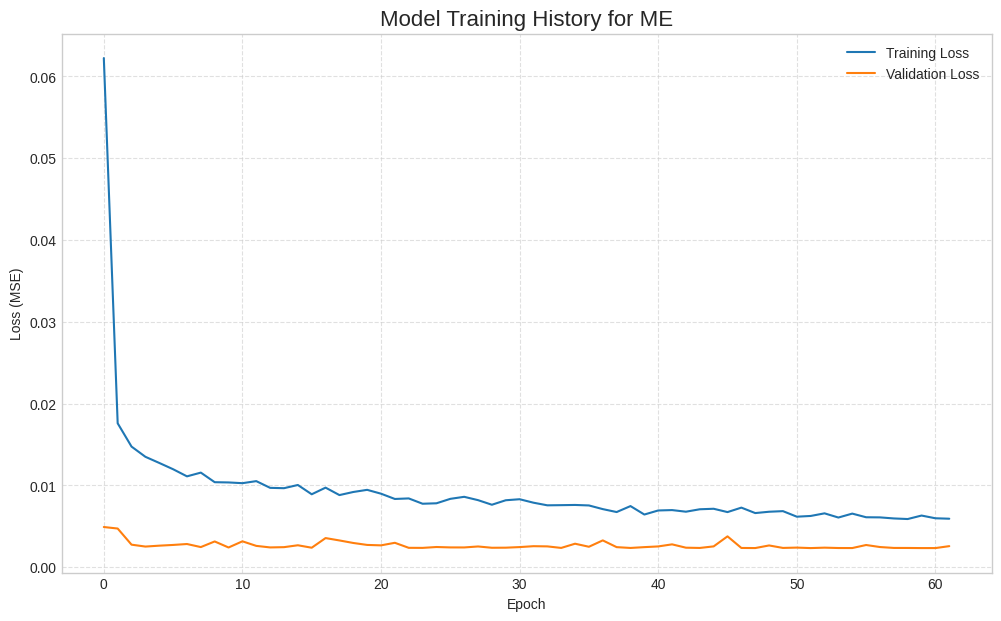

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


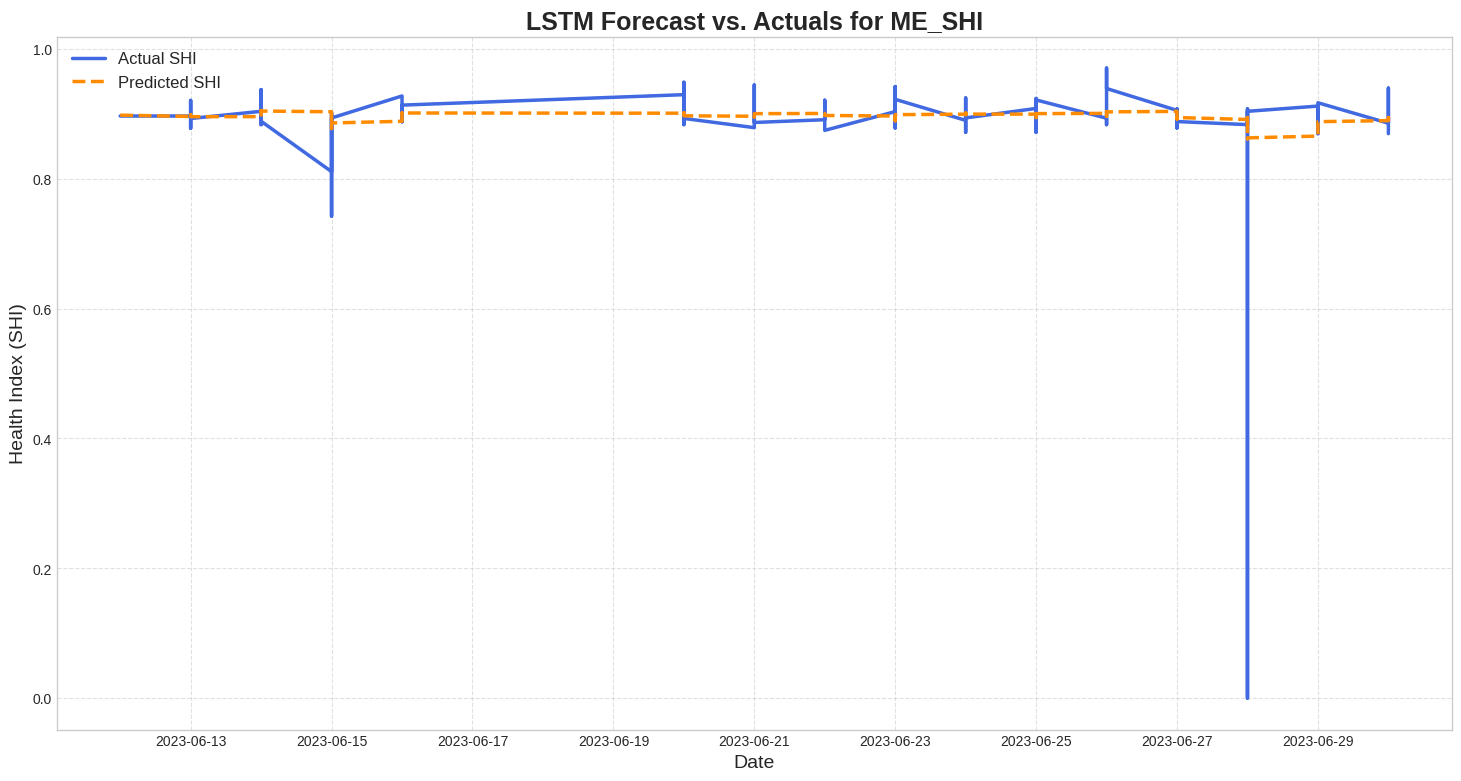

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3059

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.3005 - val_loss: 0.0018
Epoch 2/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0262

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0260 - val_loss: 0.0011
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0225

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0225 - val_loss: 5.2304e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0182 - val_loss: 8.3763e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0179 - val_loss: 5.7130e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0176 - val_loss: 0.0022
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0162 - val_loss: 0.0019
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0163 - val_loss: 0.0019
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0157 - val_loss: 0.0014
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0165 - val_loss: 8.5424e-04
Epoch 11/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0171

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0170 - val_loss: 4.6003e-04
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0160 - val_loss: 5.4373e-04
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0146 - val_loss: 0.0055
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0160 - val_loss: 7.2034e-04
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0125 - val_loss: 0.0012
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0139 - val_loss: 9.3987e-04
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0136 - val_loss: 0.0020
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0150 - val_loss: 0.0043
Epoch 19/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0147

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0147 - val_loss: 4.1372e-04
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0150 - val_loss: 0.0020
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0135 - val_loss: 0.0017
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0131 - val_loss: 0.0018
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 5.8653e-04
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0134 - val_loss: 0.0011
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0137 - val_loss: 0.0014
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0135 - val_loss: 0.0027
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0143 - val_loss: 6.6169e-04
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0125 - val_loss: 0.0011
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0134 - val_loss: 5.2656e-04


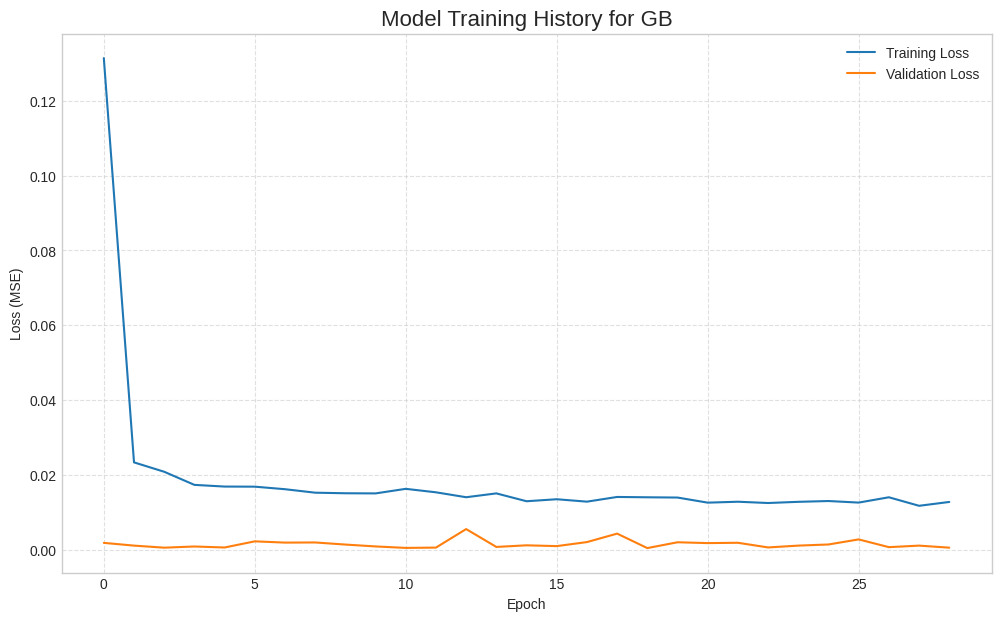

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


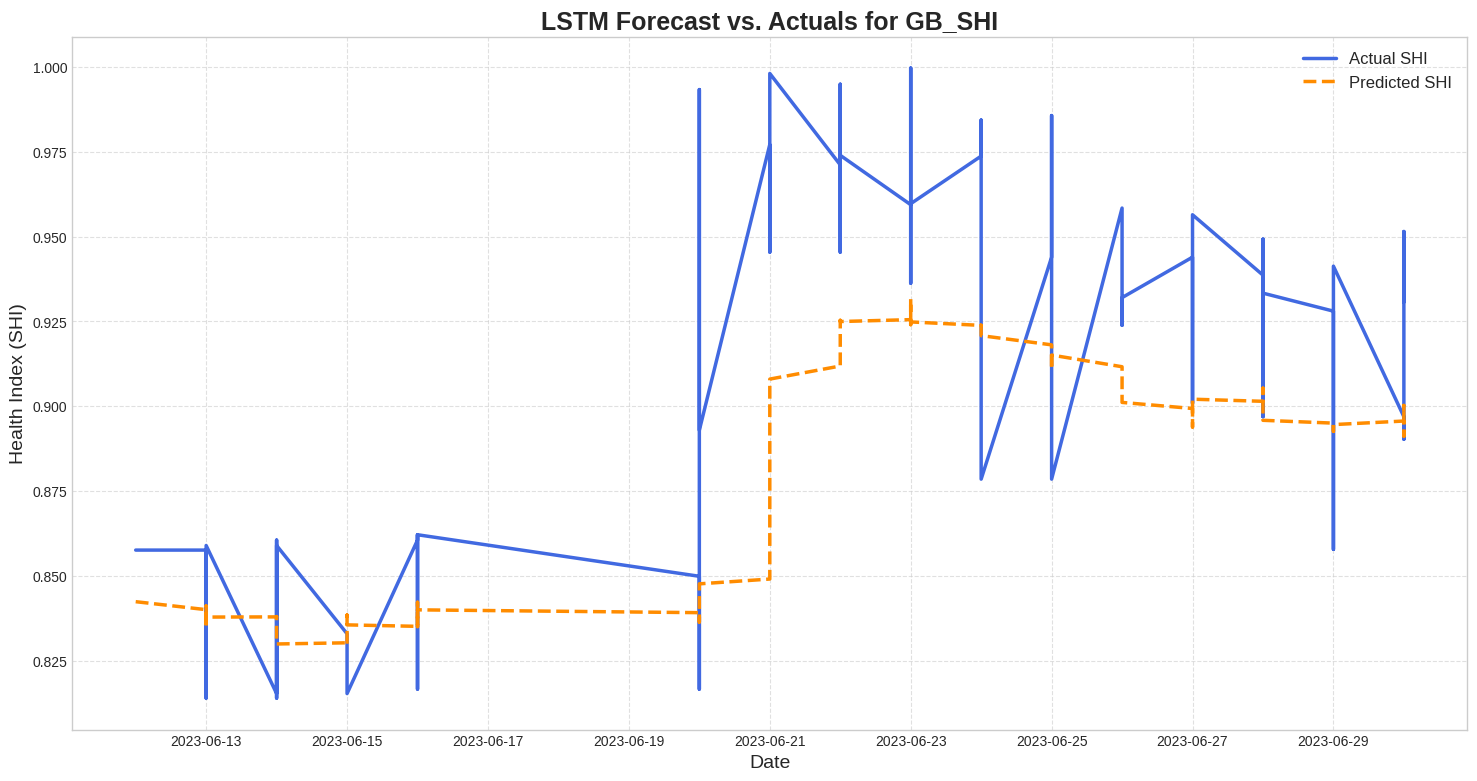

In [ ]:
# =============================================================================
# FINAL SCRIPT - V7.3 (Definitive - Adapted for Simpler Config)
# This version is specifically adapted to work with the older config file
# while retaining all critical methodological improvements.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime
import random
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the configuration file
import master_config as cfg

# --- 2. Setup Logging & Reproducibility ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# --- 3. Helper Functions ---

def load_processed_data(file_path):
    logger.info(f"Loading final SHI data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
        return df
    except FileNotFoundError:
        logger.error(f"FATAL: File not found at '{file_path}'. Please ensure SHI generation script ran successfully.")
        raise SystemExit(1)

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(cfg.LSTM_UNITS_LAYER_1, return_sequences=True),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        LSTM(cfg.LSTM_UNITS_LAYER_2, return_sequences=False),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        Dense(1, activation='linear')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=cfg.LSTM_LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.summary()
    return model

def plot_training_history(history, component):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Training History for {component}', fontsize=16)
    plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    # [MODIFIED] Save plot to the general OUTPUT_DIR to match the old config
    plot_path = os.path.join(cfg.OUTPUT_DIR, f'lstm_{component.lower()}_training_history.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.show()

def plot_forecast(actuals, predictions, date_index, component):
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))
    plt.plot(date_index, actuals, color='royalblue', label='Actual SHI', linewidth=2.5)
    plt.plot(date_index, predictions, color='darkorange', label='Predicted SHI', linestyle='--', linewidth=2.5)
    plt.title(f'LSTM Forecast vs. Actuals for {component}_SHI', fontsize=18, weight='bold')
    plt.xlabel('Date', fontsize=14); plt.ylabel('Health Index (SHI)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    # [MODIFIED] Save plot to the general OUTPUT_DIR to match the old config
    plot_path = os.path.join(cfg.OUTPUT_DIR, f'lstm_{component.lower()}_forecast_final.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.show()

# --- 4. Main Execution Block ---
def main():
    set_all_seeds(cfg.GLOBAL_RANDOM_SEED)
    logger.info("--- Starting Final LSTM Training Script (Adapted for Simpler Config) ---")

    # [MODIFIED] Construct the input path using variables from the old config file
    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    full_df = load_processed_data(input_path)

    for component in ['ME', 'GB']:
        logger.info(f"\n{'='*25} Processing Component: {component} {'='*25}")

        # Use the simple feature lists from the config (Section 7)
        if component == 'ME':
            features_to_use = cfg.LSTM_FEATURES_ME
        else: # 'GB'
            features_to_use = cfg.LSTM_FEATURES_GB

        logger.info(f"Using feature set: {features_to_use}")

        # Ensure the target SHI column is first for inverse scaling later
        target_col = getattr(cfg, f'SHI_COLUMN_{component}')
        features_ordered = [target_col] + [f for f in features_to_use if f != target_col]

        component_df = full_df[features_ordered].dropna()

        # Split data into Train, Validation, and Test sets BEFORE scaling
        train_val_df, test_df = train_test_split(component_df, test_size=0.15, shuffle=False)
        train_df, val_df = train_test_split(train_val_df, test_size=0.15, shuffle=False)

        logger.info(f"Data split sizes: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")

        # Fit the scaler ONLY on the training data
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        X_train, y_train = create_sequences(train_scaled, cfg.LOOK_BACK_WINDOW)
        X_val, y_val = create_sequences(val_scaled, cfg.LOOK_BACK_WINDOW)
        X_test, y_test = create_sequences(test_scaled, cfg.LOOK_BACK_WINDOW)

        logger.info(f"Sequence shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

        model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

        model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component.lower()}.h5')
        early_stopping = EarlyStopping(monitor='val_loss', patience=cfg.LSTM_EARLY_STOPPING_PATIENCE, mode='min')
        model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')

        history = model.fit(
            X_train, y_train,
            epochs=cfg.LSTM_EPOCHS, batch_size=cfg.LSTM_BATCH_SIZE,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )
        plot_training_history(history, component)

        best_model = tf.keras.models.load_model(model_path)
        predictions_scaled = best_model.predict(X_test)

        # Inverse transform logic (requires target to be the first column)
        num_features = len(features_ordered)
        dummy_preds = np.zeros((len(predictions_scaled), num_features))
        dummy_preds[:, 0] = predictions_scaled.flatten()
        predictions = scaler.inverse_transform(dummy_preds)[:, 0]

        dummy_actuals = np.zeros((len(y_test), num_features))
        dummy_actuals[:, 0] = y_test.flatten()
        actuals = scaler.inverse_transform(dummy_actuals)[:, 0]

        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        logger.info(f"--- Final Evaluation on Unseen Test Set for {component} ---")
        logger.info(f"Test Set MAE: {mae:.4f}")
        logger.info(f"Test Set RMSE: {rmse:.4f}")

        test_start_index = len(train_df) + len(val_df) + cfg.LOOK_BACK_WINDOW
        date_index = component_df.index[test_start_index : test_start_index + len(actuals)]
        plot_forecast(actuals, predictions, date_index, component)

        scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component.lower()}.pkl')
        joblib.dump(scaler, scaler_path)
        logger.info(f"Saved {component} assets to {cfg.FROZEN_ASSETS_DIR}")

    logger.info("\n--- LSTM Training & Freezing Complete. ---")

if __name__ == '__main__':
    main()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


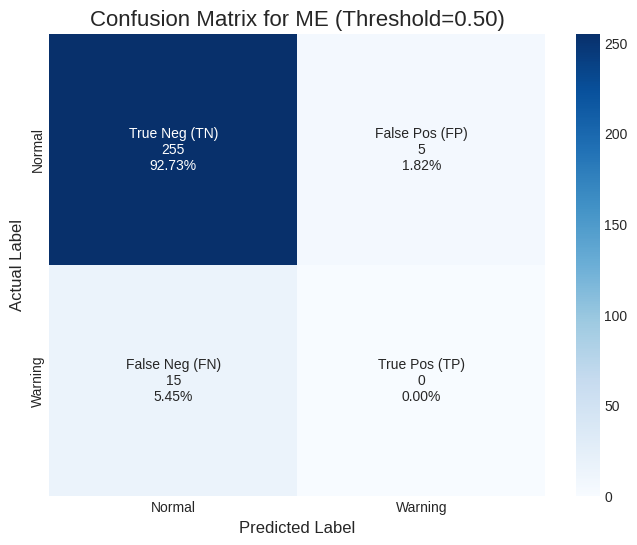

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [ ]:
# =============================================================================
# FINAL SCRIPT - CLASSIFICATION (Definitive Version)
# This script includes an enhanced confusion matrix plot and a comprehensive
# summary report with a data-driven recommendation for the optimal threshold.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime
import random
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.utils import class_weight
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# --- 3. Helper Functions ---

def load_processed_data(file_path):
    logger.info(f"Loading SHI data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
        return df
    except FileNotFoundError:
        raise SystemExit(1)

def create_classification_labels(df, target_col, threshold, window):
    logger.info(f"Creating classification labels for {target_col} (Threshold < {threshold}, Window={window} days)...")
    df['label'] = 0
    shi_series = df[target_col]
    # Use rolling window for a much faster and more efficient calculation
    is_critical_in_window = shi_series.rolling(window=window, min_periods=1).min().shift(-window) < threshold
    df.loc[is_critical_in_window, 'label'] = 1
    logger.info(f"Label creation complete. Distribution:\n{df['label'].value_counts(normalize=True).to_string()}")
    return df

def build_classification_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(cfg.LSTM_UNITS_LAYER_1, return_sequences=True),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        LSTM(cfg.LSTM_UNITS_LAYER_2, return_sequences=False),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=cfg.LSTM_LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# [NEW] Enhanced Confusion Matrix Plotting Function
def plot_enhanced_confusion_matrix(y_true, y_pred, component, threshold):
    """Creates a visually clear confusion matrix with TP, FN, FP, TN labels."""
    cm = confusion_matrix(y_true, y_pred)

    # Create the text labels for each cell
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = [f"{value}" for value in cm.flatten()]
    group_percentages = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
                xticklabels=['Normal', 'Warning'], yticklabels=['Normal', 'Warning'])

    plt.title(f'Confusion Matrix for {component} (Threshold={threshold:.2f})', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    plot_path = os.path.join(cfg.OUTPUT_DIR, f'lstm_classifier_{component.lower()}_confusion_matrix_enhanced.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.show()
    logger.info(f"Enhanced confusion matrix saved to {plot_path}")

# [NEW] Comprehensive Summary Report Function
def save_comprehensive_summary(results):
    """Saves a detailed, narrative-driven summary report."""
    file_path = os.path.join(cfg.OUTPUT_DIR, f"lstm_classifier_{results['component'].lower()}_summary_report.txt")
    logger.info(f"Saving comprehensive report to: {file_path}")

    with open(file_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write(" " * 15 + "LSTM Early Warning (Classification) Model Summary\n")
        f.write("="*80 + "\n\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Target Component: {results['component']}\n\n")

        f.write("--- Model Configuration ---\n")
        f.write(f"Look-back Window: {cfg.LOOK_BACK_WINDOW} days\n")
        f.write(f"Prediction Window: {cfg.CLASSIFICATION_PREDICTION_WINDOW} days ahead\n")
        f.write(f"Critical SHI Threshold: < {cfg.CLASSIFICATION_CRITICAL_THRESHOLD}\n\n")

        f.write("--- Data Overview ---\n")
        f.write(f"Training Samples: {results['train_samples']}\n")
        f.write(f"Test Samples: {results['test_samples']}\n")
        f.write(f"Class Weights Applied (for 'Warning' class): ~{results['class_weights'][1]:.2f}x\n\n")

        f.write("--- Overall Performance (Test Set) ---\n")
        f.write(f"ROC AUC Score: {results['roc_auc']:.4f} (Ability to distinguish between classes)\n")
        f.write(f"PR AUC Score: {results['pr_auc']:.4f} (Performance on imbalanced data)\n\n")

        f.write("--- Precision-Recall Trade-off Analysis ---\n")
        f.write("Goal: Maximize RECALL for the 'Warning' class to minimize missed failures.\n\n")

        best_recall = -1
        recommended_threshold = 0.5

        for thresh, report_dict in results['tradeoff_reports'].items():
            f.write(f"----- THRESHOLD = {thresh:.2f} -----\n")
            f.write(f"  Normal Class:  Precision={report_dict['Normal']['precision']:.2f}, Recall={report_dict['Normal']['recall']:.2f}, F1-Score={report_dict['Normal']['f1-score']:.2f}\n")
            f.write(f"  Warning Class: Precision={report_dict['Warning']['precision']:.2f}, Recall={report_dict['Warning']['recall']:.2f}, F1-Score={report_dict['Warning']['f1-score']:.2f}\n\n")

            # Find the threshold with the best recall for the 'Warning' class
            current_recall = report_dict['Warning']['recall']
            if current_recall > best_recall:
                best_recall = current_recall
                recommended_threshold = thresh

        f.write("--- Final Recommendation ---\n")
        f.write(f"To maximize the detection of potential failures (highest recall on 'Warning' class),\n")
        f.write(f"the recommended probability threshold for this model is: {recommended_threshold:.2f}\n")
        f.write(f"At this threshold, the model achieved a Recall of {best_recall:.2%} for the 'Warning' class.\n")
        f.write("="*80 + "\n")

# --- 4. Main Execution Block ---
def main():
    set_all_seeds(cfg.GLOBAL_RANDOM_SEED)
    # (The main logic is largely the same, but calls the new functions)
    logger.info("--- Starting LSTM Classification Model Training ---")
    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    full_df = load_processed_data(input_path)

    for component in ['ME', 'GB']:
        logger.info(f"\n{'='*25} Processing Component: {component} {'='*25}")
        df_component = full_df.copy()

        target_shi_col = getattr(cfg, f'SHI_COLUMN_{component}')
        df_labeled = create_classification_labels(df_component, target_shi_col, cfg.CLASSIFICATION_CRITICAL_THRESHOLD, cfg.CLASSIFICATION_PREDICTION_WINDOW)

        # Using the simple feature set for consistency
        features_to_use = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]

        # [ROBUSTNESS CHECK from previous script]
        available_features = [f for f in features_to_use if f in df_labeled.columns]
        if len(available_features) != len(features_to_use):
            logger.warning(f"Missing features for {component}. Using available: {available_features}")
        features_df = df_labeled[available_features]
        labels = df_labeled['label'].values

        X, y = [], []
        for i in range(cfg.LOOK_BACK_WINDOW, len(features_df)):
            X.append(features_df.iloc[i - cfg.LOOK_BACK_WINDOW:i].values)
            y.append(labels[i])
        X, y = np.array(X), np.array(y)

        split_index = int(len(X) * cfg.TRAIN_TEST_SPLIT_RATIO)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        scaler.fit(X_train_reshaped)
        X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = dict(enumerate(class_weights))

        model = build_classification_model(input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
        early_stopping = EarlyStopping(monitor='val_loss', patience=cfg.LSTM_EARLY_STOPPING_PATIENCE, restore_best_weights=True)

        model.fit(X_train_scaled, y_train, epochs=cfg.LSTM_EPOCHS, validation_split=cfg.LSTM_VALIDATION_SPLIT, callbacks=[early_stopping], class_weight=class_weights_dict, verbose=0)

        y_pred_proba = model.predict(X_test_scaled).flatten()

        if len(np.unique(y_test)) < 2:
            logger.warning(f"Test set for {component} contains only one class. Cannot generate a full report.")
        else:
            tradeoff_reports = {}
            for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
                y_pred_class = (y_pred_proba > thresh).astype(int)
                # [MODIFIED] Save the report as a dictionary for easier parsing
                tradeoff_reports[thresh] = classification_report(y_test, y_pred_class, target_names=['Normal', 'Warning'], output_dict=True)

            roc_auc = roc_auc_score(y_test, y_pred_proba)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)

            summary_results = {
                'component': component, 'train_samples': len(X_train), 'test_samples': len(X_test),
                'class_weights': class_weights_dict, 'roc_auc': roc_auc, 'pr_auc': pr_auc,
                'tradeoff_reports': tradeoff_reports
            }
            save_comprehensive_summary(summary_results)

            # [MODIFIED] Call the new enhanced plotting function
            plot_enhanced_confusion_matrix(y_test, (y_pred_proba > 0.5).astype(int), component, 0.5)

        # Freezing assets
        logger.info(f"\n--- Freezing Assets for {component} ---")
        model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component.lower()}.h5')
        scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component.lower()}.pkl')
        model.save(model_path)
        joblib.dump(scaler, scaler_path)
        logger.info(f"Saved {component} assets to {cfg.FROZEN_ASSETS_DIR}")

    logger.info("\n--- LSTM Classification Training Complete. ---")

if __name__ == '__main__':
    main()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning:

[03:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565

              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97      3068
     Warning       0.00      0.00      0.00       180

    accuracy                           0.94      3248
   macro avg       0.47      0.50      0.49      3248
weighted avg       0.89      0.94      0.92      3248



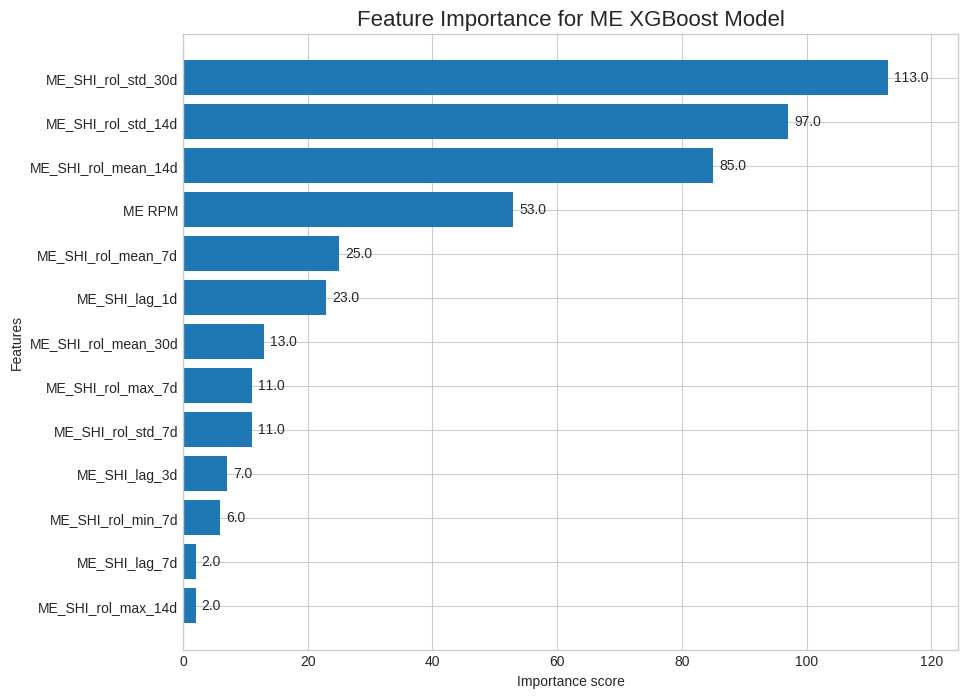

In [ ]:
# =============================================================================
# FINAL SCRIPT - V8.1 (XGBoost Classifier with Summary Report)
# This script adds a comprehensive summary report function to the XGBoost
# pipeline, creating a complete and interpretable set of results.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime
import random
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
import seaborn as sns

# Import the configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

# --- 3. Helper Functions ---

def load_processed_data(file_path):
    logger.info(f"Loading SHI data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
        return df
    except FileNotFoundError:
        raise SystemExit(1)

def create_classification_labels(df, target_col, threshold, window):
    logger.info(f"Creating classification labels for {target_col}...")
    df['label'] = 0
    is_critical_in_window = df[target_col].rolling(window=window, min_periods=1).min().shift(-window) < threshold
    df.loc[is_critical_in_window, 'label'] = 1
    logger.info(f"Label Distribution:\n{df['label'].value_counts(normalize=True).to_string()}")
    return df

def engineer_features_for_tree_model(df, component):
    logger.info(f"Engineering advanced features for {component}...")
    shi_col = getattr(cfg, f'SHI_COLUMN_{component}')
    features = pd.DataFrame(index=df.index)
    windows = [7, 14, 30]
    for w in windows:
        features[f'{shi_col}_rol_mean_{w}d'] = df[shi_col].rolling(window=w).mean()
        features[f'{shi_col}_rol_std_{w}d'] = df[shi_col].rolling(window=w).std()
        features[f'{shi_col}_rol_min_{w}d'] = df[shi_col].rolling(window=w).min()
        features[f'{shi_col}_rol_max_{w}d'] = df[shi_col].rolling(window=w).max()
    lags = [1, 3, 7]
    for lag in lags:
        features[f'{shi_col}_lag_{lag}d'] = df[shi_col].shift(lag)
    if cfg.RPM_COLUMN in df.columns:
        features[cfg.RPM_COLUMN] = df[cfg.RPM_COLUMN]
    features = features.dropna()
    return features

def plot_feature_importance(model, component):
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(model, max_num_features=15, height=0.8, ax=ax, show_values=True)
    plt.title(f'Feature Importance for {component} XGBoost Model', fontsize=16)
    plot_path = os.path.join(cfg.OUTPUT_DIR, f'xgboost_{component.lower()}_feature_importance.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI, bbox_inches='tight')
    plt.show()

# [NEW] Comprehensive XGBoost Summary Report Function
def save_xgboost_summary(results):
    """Saves a detailed, narrative-driven summary of the XGBoost model's performance."""
    file_path = os.path.join(cfg.OUTPUT_DIR, f"xgboost_classifier_{results['component'].lower()}_summary_report.txt")
    logger.info(f"Saving XGBoost summary report to: {file_path}")

    report_dict = results['classification_report']

    with open(file_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write(" " * 18 + "XGBoost Early Warning (Classification) Model Summary\n")
        f.write("="*80 + "\n\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Target Component: {results['component']}\n\n")

        f.write("--- Model Configuration ---\n")
        f.write(f"Prediction Window: {cfg.CLASSIFICATION_PREDICTION_WINDOW} days ahead\n")
        f.write(f"Critical SHI Threshold: < {cfg.CLASSIFICATION_CRITICAL_THRESHOLD}\n\n")

        f.write("--- Data Overview ---\n")
        f.write(f"Training Samples: {results['train_samples']}\n")
        f.write(f"Test Samples: {results['test_samples']}\n")
        f.write(f"Class Imbalance Ratio ('Normal'/'Warning' in training): {results['scale_pos_weight']:.2f} to 1\n\n")

        f.write("--- Overall Performance (Test Set) ---\n")
        f.write(f"ROC AUC Score: {results['roc_auc']:.4f} (Ability to distinguish between classes)\n\n")

        f.write("--- Classification Report (Test Set) ---\n")
        f.write("              precision    recall  f1-score   support\n\n")
        f.write(f"      Normal    {report_dict['Normal']['precision']:.2f}         {report_dict['Normal']['recall']:.2f}      {report_dict['Normal']['f1-score']:.2f}     {report_dict['Normal']['support']}\n")
        f.write(f"     Warning    {report_dict['Warning']['precision']:.2f}         {report_dict['Warning']['recall']:.2f}      {report_dict['Warning']['f1-score']:.2f}      {report_dict['Warning']['support']}\n\n")
        f.write(f"    accuracy                           {report_dict['accuracy']:.2f}     {report_dict['macro avg']['support']}\n")
        f.write(f"   macro avg    {report_dict['macro avg']['precision']:.2f}         {report_dict['macro avg']['recall']:.2f}      {report_dict['macro avg']['f1-score']:.2f}     {report_dict['macro avg']['support']}\n")
        f.write(f"weighted avg    {report_dict['weighted avg']['precision']:.2f}         {report_dict['weighted avg']['recall']:.2f}      {report_dict['weighted avg']['f1-score']:.2f}     {report_dict['weighted avg']['support']}\n\n")

        f.write("--- Key Feature Insights ---\n")
        f.write("The following features were most important for the model's predictions:\n")
        for i, (feature, score) in enumerate(results['top_features'].items()):
            f.write(f"  {i+1}. {feature} (Importance: {score:.1f})\n")
        f.write("\n")

        f.write("--- Conclusion ---\n")
        recall_warning = report_dict['Warning']['recall']
        precision_warning = report_dict['Warning']['precision']
        if recall_warning > 0.5:
             f.write(f"The model successfully learned to identify warning signs, achieving a Recall of {recall_warning:.2%} for the 'Warning' class.\n")
             f.write("The high importance of volatility features (rol_std) suggests that system instability is a key precursor to failure.\n")
        else:
            f.write("The model struggled to identify a consistent pattern for the 'Warning' class on the test set.\n")
            f.write("While feature importance provides clues, further model tuning or more diverse data may be needed.\n")

        f.write("="*80 + "\n")

# --- 4. Main Execution Block ---
def main(): # ### Fixed Indentation
    set_all_seeds(cfg.GLOBAL_RANDOM_SEED)
    logger.info("--- Starting XGBoost Classification Model Training (V8.1) ---")
    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    full_df = load_processed_data(input_path)

    for component in ['ME', 'GB']:
        logger.info(f"\n{'='*25} Processing Component: {component} {'='*25}")

        target_shi_col = getattr(cfg, f'SHI_COLUMN_{component}')
        features_df = engineer_features_for_tree_model(full_df, component)
        df_labeled = create_classification_labels(full_df, target_shi_col, cfg.CLASSIFICATION_CRITICAL_THRESHOLD, cfg.CLASSIFICATION_PREDICTION_WINDOW)
        aligned_df = features_df.join(df_labeled['label'], how='inner')

        X = aligned_df.drop('label', axis=1)
        y = aligned_df['label']

        split_index = int(len(X) * cfg.TRAIN_TEST_SPLIT_RATIO)
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if len(np.unique(y_test)) < 2:
            logger.warning(f"Test set for {component} contains only one class. Skipping evaluation.")
            continue

        scale_pos_weight = 200 # Manually set a very high weight
        logger.info(f"Manually setting aggressive scale_pos_weight for XGBoost: {scale_pos_weight:.2f}") # ### Fixed Indentation

        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, use_label_encoder=False, n_estimators=100, max_depth=4, learning_rate=0.1, random_state=cfg.GLOBAL_RANDOM_SEED)
        model.fit(X_train, y_train)

        y_pred_class = model.predict(X_test)

        logger.info(f"\n--- XGBoost Evaluation for {component} ---")
        print(classification_report(y_test, y_pred_class, target_names=['Normal', 'Warning']))

        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        # Get top features for the report
        feature_importances = model.get_booster().get_score(importance_type='weight')
        sorted_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)
        top_5_features = dict(sorted_features[:5])

        # [NEW] Create and save the summary report
        summary_results = {
            'component': component,
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'scale_pos_weight': scale_pos_weight,
            'roc_auc': roc_auc,
            'classification_report': classification_report(y_test, y_pred_class, target_names=['Normal', 'Warning'], output_dict=True),
            'top_features': top_5_features
        }
        save_xgboost_summary(summary_results)

        plot_feature_importance(model, component)

        # Freeze Assets
        logger.info(f"\n--- Freezing XGBoost Assets for {component} ---")
        model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'xgboost_classifier_{component.lower()}.json')
        model.save_model(model_path)
        features_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'xgboost_features_{component.lower()}.json')
        X_train.columns.to_series().to_json(features_path)
        logger.info(f"Saved {component} XGBoost assets to {cfg.FROZEN_ASSETS_DIR}")

    logger.info("\n--- XGBoost Classification Training Complete. ---") # ### Fixed Indentation


if __name__ == '__main__':
    main()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names




DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.870
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.935
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.881
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.858
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.890
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.940
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.895
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.932
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.895
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.937
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.872
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.929
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.890
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.939
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-29
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.917
  - 15-Day Warning Probability: 81.4%
  - ALERT LEVEL: Critical
  - Recommendation: High warning probability. Immediate inspection required.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.941
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.886
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.897
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.895
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.890
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.896
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.893
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.870
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.897
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.881
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.951
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.900
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.928
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.907
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.936
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.911
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: GB
  - Current SHI: 0.935
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.876
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.936
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.897
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.908
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.940
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.934
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-30
----------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



COMPONENT: ME
  - Current SHI: 0.870
  - 15-Day Warning Probability: 8.9%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.931
  - 15-Day Warning Probability: 0.4%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



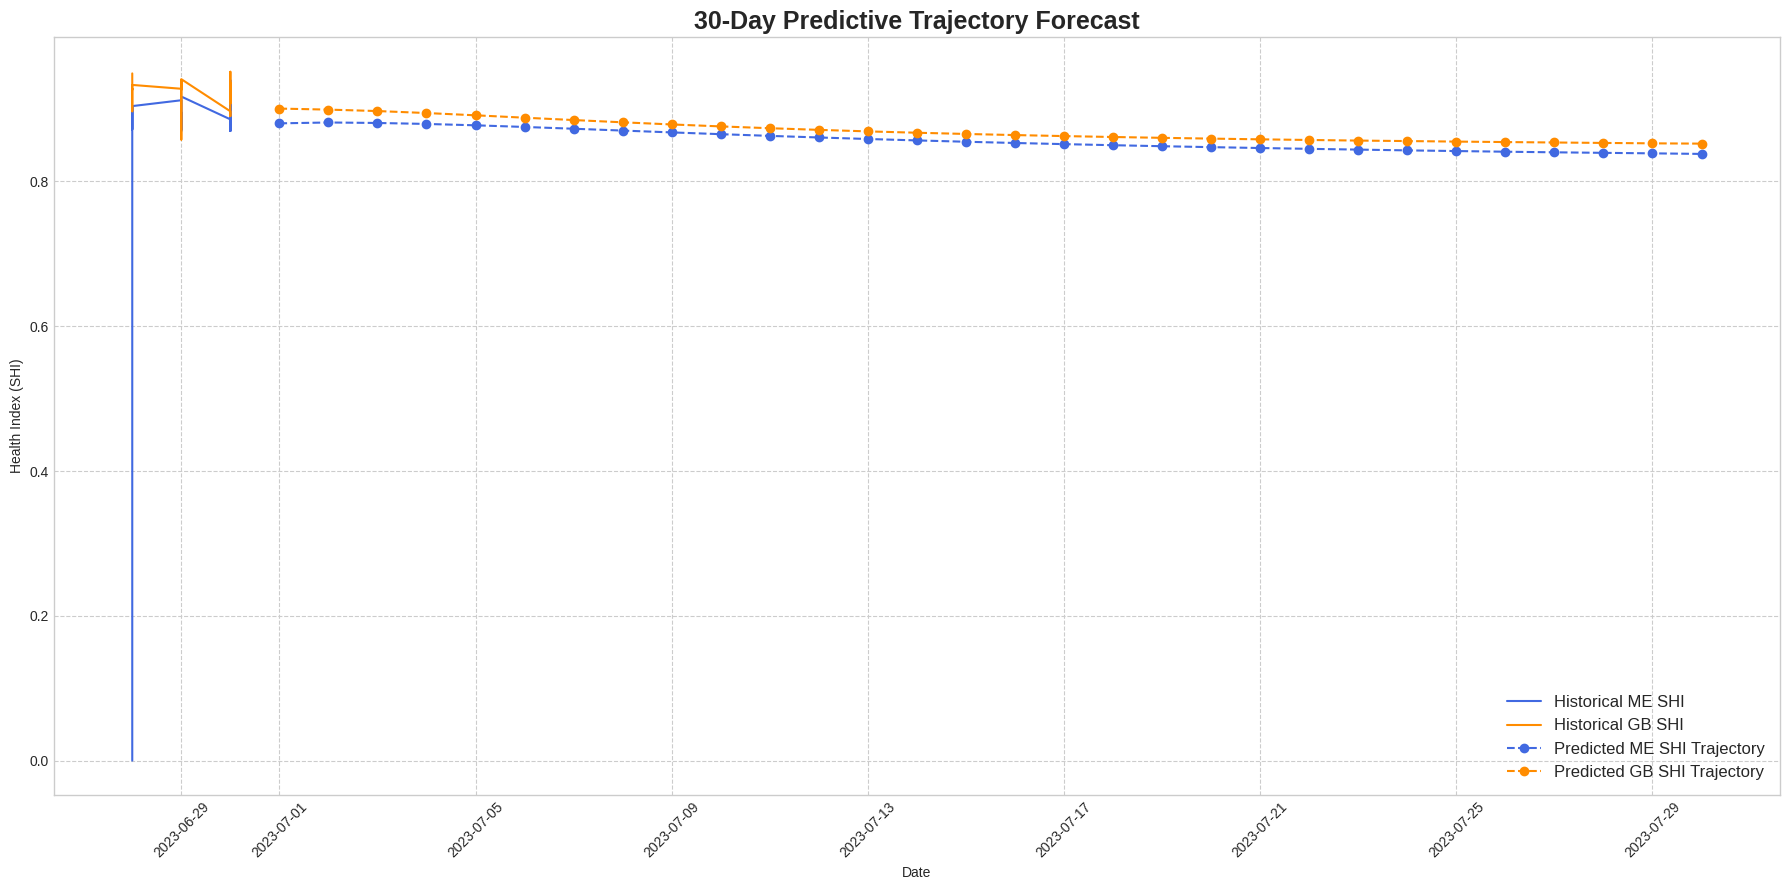

In [ ]:
# final_report_simulation.py
# This script loads all frozen models and scalers to simulate a daily
# operational report, saves the raw report data to a CSV, and generates
# a 30-day predictive trajectory forecast plot.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

# Import the master configuration file
import master_config as cfg

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Asset Loading Function ---
def load_frozen_assets():
    """
    Loads all pre-trained, frozen models and scalers from the assets directory.
    """
    logger.info("--- Loading all frozen assets from disk ---")
    assets = {}
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()

        # Load Forecasting/Regression Model & Scaler
        assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}.h5'))
        assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}.pkl'))

        # Load Early Warning/Classification Model & Scaler
        assets[component]['classifier'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component_lower}.h5'))
        assets[component]['scaler_class'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component_lower}.pkl'))

        logger.info(f"Successfully loaded 4 assets for component {component}.")
    return assets

# --- Alert System Logic ---
def get_alert_level(probability, component):
    thresholds = cfg.COMPONENT_ALERT_THRESHOLDS[component]
    if probability >= thresholds[3]: return 3
    if probability >= thresholds[2]: return 2
    if probability >= thresholds[1]: return 1
    return 0

# --- Trajectory Forecasting Logic ---
def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features):
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    for _ in range(cfg.FORECAST_DAYS):
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        new_step = current_window[-1, :].reshape(1, num_features)
        new_step[0, 0] = next_pred_scaled

        current_window = np.append(current_window[1:, :], new_step, axis=0)

    dummy_array = np.zeros((cfg.FORECAST_DAYS, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- Main Execution Block ---
def main():
    logger.info("--- Generating Final Project Report: Alerts and Trajectory ---")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    df_full = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    df_full.columns = df_full.columns.str.strip()

    assets = load_frozen_assets()

    # --- PART 1: Simulate Daily Alert Report ---
    logger.info(f"\n\n--- SIMULATING DAILY OPERATIONS ALERT REPORT (LAST {cfg.SIMULATION_DAYS} READINGS) ---")
    simulation_df = df_full.iloc[-cfg.SIMULATION_DAYS:].copy()

    report_data = [] # List to collect data for the CSV report

    for date, row in simulation_df.iterrows():
        history_window_df = df_full.loc[:date].iloc[-cfg.LOOK_BACK_WINDOW:]
        if len(history_window_df) < cfg.LOOK_BACK_WINDOW: continue

        print(f"\n{'='*70}\nDAILY OPERATIONS REPORT FOR: {date.date()}\n{'-'*70}")

        daily_report_entry = {'Date': date.date()}

        for component in ['ME', 'GB']:
            asset_pack = assets[component]
            features = getattr(cfg, f'LSTM_FEATURES_{component}')

            input_scaled = asset_pack['scaler_class'].transform(history_window_df[features])

            prob = asset_pack['classifier'].predict(np.expand_dims(input_scaled, axis=0), verbose=0)[0][0]
            alert_level = get_alert_level(prob, component)

            print(f"COMPONENT: {component.upper()}")
            print(f"  - Current SHI: {row[f'{component}_SHI']:.3f}")
            print(f"  - {cfg.CLASSIFICATION_PREDICTION_WINDOW}-Day Warning Probability: {prob:.1%}")
            print(f"  - ALERT LEVEL: {cfg.ALERT_LEVELS[alert_level]['Name']}")
            print(f"  - Recommendation: {cfg.ALERT_LEVELS[alert_level]['Recommendation']}")
            if component == 'ME': print(f"--------------------------------------------------")

            # Add data for this component to the daily entry
            daily_report_entry[f'{component}_Current_SHI'] = row[f'{component}_SHI']
            daily_report_entry[f'{component}_Warning_Prob'] = prob

        report_data.append(daily_report_entry)

    # --- Create and save the raw simulation data for the dashboard script ---
    report_df = pd.DataFrame(report_data)
    report_csv_path = os.path.join(cfg.OUTPUT_DIR, cfg.SIMULATION_CSV_FILENAME)
    report_df.to_csv(report_csv_path, index=False)
    logger.info(f"\nRaw daily simulation data saved to '{report_csv_path}' for dashboard generation.")

    # --- PART 2: Generate and Plot Final Trajectory Forecast ---
    logger.info(f"\n\n--- GENERATING {cfg.FORECAST_DAYS}-DAY PREDICTIVE TRAJECTORY FORECAST ---")
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT)); plt.style.use('seaborn-v0_8-whitegrid')

    history_plot_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:]
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_ME], label='Historical ME SHI', color='royalblue')
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_GB], label='Historical GB SHI', color='darkorange')

    for component in ['ME', 'GB']:
        asset_pack = assets[component]
        features = getattr(cfg, f'LSTM_FEATURES_{component}')
        recent_data_scaled = asset_pack['scaler_reg'].transform(history_plot_df[features])

        forecast = generate_forecast_trajectory(
            asset_pack['regressor'], asset_pack['scaler_reg'],
            recent_data_scaled, len(features)
        )

        future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, cfg.FORECAST_DAYS + 1)]
        color = 'royalblue' if component == 'ME' else 'darkorange'
        plt.plot(future_dates, forecast, marker='o', linestyle='--', color=color, label=f'Predicted {component} SHI Trajectory')

    plt.title(f'{cfg.FORECAST_DAYS}-Day Predictive Trajectory Forecast', fontsize=18, weight='bold')
    plt.xlabel('Date'); plt.ylabel('Health Index (SHI)')
    plt.legend(fontsize=12); plt.grid(True, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = os.path.join(cfg.OUTPUT_DIR, 'final_trajectory_forecast.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Final trajectory plot saved to: {plot_path}")
    plt.show()

if __name__ == '__main__':
    main()


DAILY OPERATIONS REPORT FOR: 2023-06-08
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.881
  - 15-Day Warning Probability: 0.2%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.856
  - 15-Day Warning Probability: 7.6%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-09
----------------------------------------------------------------------
COMPONENT: ME
  - Current SHI: 0.899
  - 15-Day Warning Probability: 0.2%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.
--------------------------------------------------
COMPONENT: GB
  - Current SHI: 0.856
  - 15-Day Warning Probability: 13.3%
  - ALERT LEVEL: Normal
  - Recommendation: Continue standard monitoring.

DAILY OPERATIONS REPORT FOR: 2023-06-10
----------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



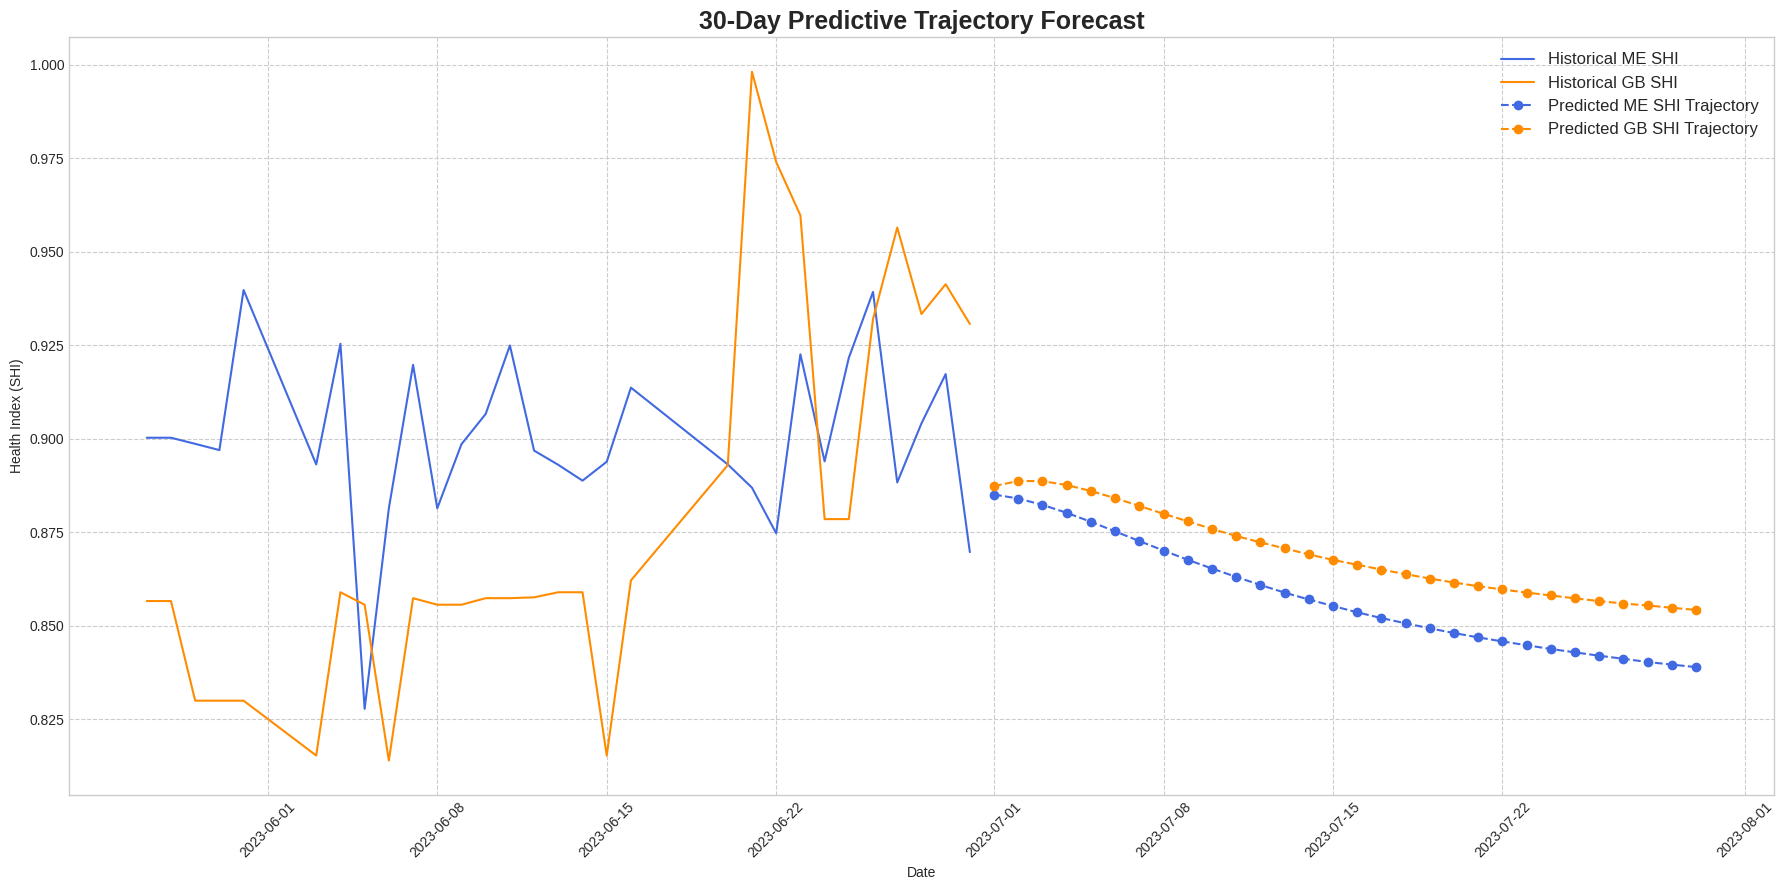

In [ ]:
# =============================================================================
# FINAL SCRIPT - V8.1 (Simulation - Corrected & Definitive)
# This version fixes the repeated date issue by resampling the data daily
# and silences the harmless scikit-learn UserWarning for a cleaner output.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions ---
def load_frozen_assets():
    """Loads all pre-trained, frozen models and scalers."""
    logger.info("--- Loading all frozen assets from disk ---")
    assets = {}
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            # Load Forecasting/Regression Model & Scaler
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}.pkl'))

            # Load Early Warning/Classification Model & Scaler
            assets[component]['classifier'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component_lower}.h5'))
            assets[component]['scaler_class'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component_lower}.pkl'))
            logger.info(f"Successfully loaded 4 assets for component {component}.")
        except Exception as e:
            logger.error(f"Could not load all assets for {component}. Error: {e}")
            logger.error("Please ensure both regression and classification models were trained and frozen successfully.")
            return None
    return assets

def get_alert_level(probability, component):
    thresholds = cfg.COMPONENT_ALERT_THRESHOLDS[component]
    if probability >= thresholds[3]: return 3
    if probability >= thresholds[2]: return 2
    if probability >= thresholds[1]: return 1
    return 0

def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features):
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    for _ in range(cfg.FORECAST_DAYS):
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        # Prepare the next input step
        # We need to create a dummy array with all features to inverse transform, get the SHI_Change, then re-transform
        # This is complex; a simpler approach is to assume SHI_Change and RPM remain constant at the last known value
        last_step_full_features = current_window[-1, :].copy()
        last_step_full_features[0] = next_pred_scaled # Update only the SHI value

        new_step = np.expand_dims(last_step_full_features, axis=0)
        current_window = np.append(current_window[1:, :], new_step, axis=0)

    dummy_array = np.zeros((cfg.FORECAST_DAYS, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- 4. Main Execution Block ---
def main():
    logger.info("--- Generating Final Project Report: Alerts and Trajectory ---")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    df_full = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    df_full.columns = df_full.columns.str.strip()

    # [FIX] Resample to daily frequency to avoid repeated dates, taking the last reading of each day
    df_daily = df_full.resample('D').last().dropna()
    logger.info(f"Resampled data to daily frequency. New shape: {df_daily.shape}")

    assets = load_frozen_assets()
    if assets is None:
        return # Stop execution if assets failed to load

    # --- PART 1: Simulate Daily Alert Report ---
    logger.info(f"\n\n--- SIMULATING DAILY OPERATIONS ALERT REPORT (LAST {cfg.SIMULATION_DAYS} DAYS) ---")
    simulation_df = df_daily.iloc[-cfg.SIMULATION_DAYS:].copy()
    report_data = []

    for date, row in simulation_df.iterrows():
        # Use the daily resampled dataframe for history as well
        history_window_df = df_daily.loc[:date].iloc[-cfg.LOOK_BACK_WINDOW:]
        if len(history_window_df) < cfg.LOOK_BACK_WINDOW:
            logger.warning(f"Skipping report for {date.date()} due to insufficient history ({len(history_window_df)} days).")
            continue

        print(f"\n{'='*70}\nDAILY OPERATIONS REPORT FOR: {date.date()}\n{'-'*70}")
        daily_report_entry = {'Date': date.date()}

        for component in ['ME', 'GB']:
            asset_pack = assets[component]
            # Use the simple feature set from the successful models
            features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]

            # [FIX] Use .values to silence the UserWarning
            input_data_numpy = history_window_df[features].values
            input_scaled = asset_pack['scaler_class'].transform(input_data_numpy)

            prob = asset_pack['classifier'].predict(np.expand_dims(input_scaled, axis=0), verbose=0)[0][0]
            alert_level = get_alert_level(prob, component)

            print(f"COMPONENT: {component.upper()}")
            print(f"  - Current SHI: {row[f'{component}_SHI']:.3f}")
            print(f"  - {cfg.CLASSIFICATION_PREDICTION_WINDOW}-Day Warning Probability: {prob:.1%}")
            print(f"  - ALERT LEVEL: {cfg.ALERT_LEVELS[alert_level]['Name']}")
            print(f"  - Recommendation: {cfg.ALERT_LEVELS[alert_level]['Recommendation']}")
            if component == 'ME': print(f"--------------------------------------------------")

            daily_report_entry[f'{component}_Current_SHI'] = row[f'{component}_SHI']
            daily_report_entry[f'{component}_Warning_Prob'] = prob
        report_data.append(daily_report_entry)

    report_df = pd.DataFrame(report_data)
    report_csv_path = os.path.join(cfg.OUTPUT_DIR, cfg.SIMULATION_CSV_FILENAME)
    report_df.to_csv(report_csv_path, index=False)
    logger.info(f"\nRaw daily simulation data saved to '{report_csv_path}' for dashboard generation.")

    # --- PART 2: Generate and Plot Final Trajectory Forecast ---
    logger.info(f"\n\n--- GENERATING {cfg.FORECAST_DAYS}-DAY PREDICTIVE TRAJECTORY FORECAST ---")
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT)); plt.style.use('seaborn-v0_8-whitegrid')

    # Use the daily resampled dataframe for plotting history
    history_plot_df = df_daily.iloc[-cfg.LOOK_BACK_WINDOW:]
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_ME], label='Historical ME SHI', color='royalblue')
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_GB], label='Historical GB SHI', color='darkorange')

    for component in ['ME', 'GB']:
        asset_pack = assets[component]
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]
        # [FIX] Use .values to silence the UserWarning
        recent_data_numpy = history_plot_df[features].values
        recent_data_scaled = asset_pack['scaler_reg'].transform(recent_data_numpy)

        forecast = generate_forecast_trajectory(asset_pack['regressor'], asset_pack['scaler_reg'], recent_data_scaled, len(features))

        future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, cfg.FORECAST_DAYS + 1)]
        color = 'royalblue' if component == 'ME' else 'darkorange'
        plt.plot(future_dates, forecast, marker='o', linestyle='--', color=color, label=f'Predicted {component} SHI Trajectory')

    plt.title(f'{cfg.FORECAST_DAYS}-Day Predictive Trajectory Forecast', fontsize=18, weight='bold')
    plt.xlabel('Date'); plt.ylabel('Health Index (SHI)')
    plt.legend(fontsize=12); plt.grid(True, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = os.path.join(cfg.OUTPUT_DIR, 'final_trajectory_forecast.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Final trajectory plot saved to: {plot_path}")
    plt.show()

if __name__ == '__main__':
    main()

In [ ]:
# =============================================================================
# FINAL SCRIPT - V10.2 (Definitive Dashboard - Corrected)
# This version fixes the AttributeError by using the correct Python string
# method (.upper() instead of .toUpperCase()).
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')
import plotly.graph_objects as go

import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions ---

def load_frozen_assets():
    """Loads all pre-trained, frozen models and scalers."""
    logger.info("--- Loading all frozen assets from disk ---")
    assets = {}
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}.pkl'))
            assets[component]['classifier'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component_lower}.h5'))
            assets[component]['scaler_class'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component_lower}.pkl'))
            logger.info(f"Successfully loaded 4 assets for component {component}.")
        except Exception as e:
            logger.error(f"FATAL: Could not load assets for {component}. Error: {e}")
            return None
    return assets

def get_alert_level(probability, component):
    thresholds = cfg.COMPONENT_ALERT_THRESHOLDS[component]
    if probability >= thresholds[3]: return 3
    if probability >= thresholds[2]: return 2
    if probability >= thresholds[1]: return 1
    return 0

def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features, forecast_days):
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    for _ in range(forecast_days):
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)
        last_step_full_features = current_window[-1, :].copy()
        last_step_full_features[0] = next_pred_scaled
        new_step = np.expand_dims(last_step_full_features, axis=0)
        current_window = np.append(current_window[1:, :], new_step, axis=0)
    dummy_array = np.zeros((forecast_days, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

def generate_interactive_forecast_plot(df_full, assets):
    logger.info("Generating interactive forecast plot...")
    fig = go.Figure()
    history_plot_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:]
    colors = {'ME': 'royalblue', 'GB': 'darkorange'}
    forecast_horizons = [7, 14, 30]

    for component in ['ME', 'GB']:
        fig.add_trace(go.Scatter(x=history_plot_df.index, y=history_plot_df[getattr(cfg, f'SHI_COLUMN_{component}')], name=f'Historical {component} SHI', mode='lines', line=dict(color=colors[component], width=2.5)))
        asset_pack = assets[component]
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]
        recent_data_numpy = history_plot_df[features].values
        recent_data_scaled = asset_pack['scaler_reg'].transform(recent_data_numpy)

        for days in forecast_horizons:
            forecast = generate_forecast_trajectory(asset_pack['regressor'], asset_pack['scaler_reg'], recent_data_scaled, len(features), days)
            future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, days + 1)]
            fig.add_trace(go.Scatter(x=future_dates, y=forecast, name=f'{days}-Day {component} Forecast', mode='lines+markers', line=dict(color=colors[component], dash='dash'), visible=(days == 30)))

    fig.update_layout(
        updatemenus=[dict(
            active=2,
            buttons=list([
                dict(label="7-Day Forecast", method="update", args=[{"visible": [True, True, False, False, True, True, False, False]}, {"title": "7-Day Predictive Trajectory Forecast"}]),
                dict(label="14-Day Forecast", method="update", args=[{"visible": [True, False, True, False, True, False, True, False]}, {"title": "14-Day Predictive Trajectory Forecast"}]),
                dict(label="30-Day Forecast", method="update", args=[{"visible": [True, False, False, True, True, False, False, True]}, {"title": "30-Day Predictive Trajectory Forecast"}]),
            ]),
            direction="down", pad={"r": 10, "t": 10}, showactive=True, x=0.01, xanchor="left", y=1.15, yanchor="top"
        )])
    fig.update_layout(title_text="30-Day Predictive Trajectory Forecast", title_x=0.5, height=500, template='plotly_white', legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
    return fig.to_html(full_html=False, include_plotlyjs='cdn')


# --- 4. Main Dashboard Generation Logic ---
def generate_final_dashboard(report_csv_path, full_data_path, assets, output_html_path):
    logger.info("--- Generating Final Interactive HTML Dashboard ---")
    try:
        df_report = pd.read_csv(report_csv_path)
        df_report['Date'] = pd.to_datetime(df_report['Date'])
        df_full = pd.read_csv(full_data_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError as e:
        logger.error(f"FATAL: Data file not found. {e}")
        return

    forecast_plot_html = generate_interactive_forecast_plot(df_full, assets)
    generation_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    color_map = {
        'Normal': {'text': '#1d7a31', 'border': '#2ca02c'},
        'Monitor': {'text': '#8a6d3b', 'border': '#ffd700'},
        'Advisory': {'text': '#a0522d', 'border': '#ff9800'},
        'Critical': {'text': '#b71c1c', 'border': '#d32f2f'}
    }

    html_start = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Daily Propulsion Health Dashboard</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; background-color: #f4f7f6; margin: 0; padding: 20px; }}
            .container {{ max-width: 1200px; margin: auto; }}
            .header {{ text-align: center; margin-bottom: 30px; }}
            .header h1 {{ color: #2c3e50; margin-bottom: 5px; }}
            .header p {{ color: #7f8c8d; font-size: 1.1em; }}
            .date-separator {{ grid-column: 1 / -1; text-align: center; margin: 30px 0 10px 0; border-bottom: 1px solid #ddd; padding-bottom: 10px; }}
            .date-separator h2 {{ color: #7f8c8d; font-weight: 500;}}
            .card-grid {{ display: grid; grid-template-columns: 1fr 1fr; gap: 20px; }}
            .card {{ background-color: #ffffff; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 20px; display: flex; flex-direction: column; }}
            .card-title {{ font-size: 1.5em; font-weight: 600; margin-bottom: 15px; color: #34495e; border-bottom: 2px solid; padding-bottom: 10px;}}
            .metric {{ margin-bottom: 15px; }}
            .metric-label {{ font-size: 0.9em; color: #95a5a6; text-transform: uppercase; }}
            .metric-value {{ font-size: 2em; font-weight: 700; color: #2c3e50; }}
            .recommendation {{ background-color: #ecf0f1; border-left: 5px solid; padding: 15px; border-radius: 5px; margin-top: auto; }}
            .plot-container {{ grid-column: 1 / -1; background-color: #ffffff; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 20px;}}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Daily Propulsion Health Dashboard</h1>
                <p>Generated: <strong>{generation_time_str}</strong></p>
            </div>
            <div class="card-grid">
                <div class="plot-container">
                    {forecast_plot_html}
                </div>
    """

    html_body_cards = ""
    # Use the most recent unique day's report for the main status
    latest_report = df_report.sort_values(by='Date', ascending=False).iloc[0]

    html_body_cards += f'<div class="date-separator"><h2>Latest Daily Status Report: {latest_report["Date"].strftime("%Y-%m-%d")}</h2></div>'

    for component in ['ME', 'GB']:
        prob = latest_report[f'{component}_Warning_Prob']
        shi = latest_report[f'{component}_Current_SHI']
        alert_level = get_alert_level(prob, component)
        status_name = cfg.ALERT_LEVELS[alert_level]['Name']
        recommendation = cfg.ALERT_LEVELS[alert_level]['Recommendation']
        colors = color_map[status_name]
        component_name = "Main Engine" if component == "ME" else "Gearbox"

        # <<< THE FIX IS HERE: Changed .toUpperCase() to .upper() >>>
        html_body_cards += f"""
        <div class="card">
            <div class="card-title" style="border-bottom-color: {colors['border']};">{component_name}</div>
            <div class="metric">
                <div class="metric-label">Status</div>
                <div class="metric-value" style="color: {colors['text']};">{status_name.upper()}</div>
            </div>
            <div class="metric">
                <div class="metric-label">Current Health Score (SHI)</div>
                <div class="metric-value">{shi:.3f}</div>
            </div>
            <div class="metric">
                <div class="metric-label">15-Day Risk Probability</div>
                <div class="metric-value">{prob:.1%}</div>
            </div>
            <div class="recommendation" style="border-left-color: {colors['border']};">
                <strong>Action Recommended:</strong> {recommendation}
            </div>
        </div>
        """

    html_end = """
            </div>
        </div>
    </body>
    </html>
    """

    final_html = html_start + html_body_cards + html_end

    with open(output_html_path, 'w') as f:
        f.write(final_html)
    logger.info(f"Success! Final interactive dashboard saved to: {output_html_path}")


# --- 5. Main Execution Block ---
if __name__ == '__main__':
    report_csv = os.path.join(cfg.OUTPUT_DIR, cfg.SIMULATION_CSV_FILENAME)
    full_data_csv = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    dashboard_html = os.path.join(cfg.OUTPUT_DIR, 'final_interactive_dashboard.html')

    frozen_assets = load_frozen_assets()

    if frozen_assets:
        generate_final_dashboard(report_csv, full_data_csv, frozen_assets, dashboard_html)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [ ]:
# =============================================================================
# FINAL SCRIPT - V11.4 (Failure Scenario Simulation - Separate Plots)
# This version produces separate plot images for each component (ME and GB)
# for clearer documentation and reporting, while retaining the robust,
# scale-aware simulation logic.
# =============================================================================

import pandas as pd
import numpy as np
import os
import logging
import matplotlib.pyplot as plt

# Import the master configuration file
import master_config as cfg

# --- Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Scale-Aware Simulation Function (Unchanged) ---
def simulate_failure_signature_robust(series, start_index, decay_rate=0.001, noise_level=0.02):
    """
    Applies a synthetic failure signature, automatically handling 0-1 or 0-100 scales.
    """
    logger.info(f"Applying failure signature starting at index {start_index}...")

    max_val = series.max()
    scale_max = 1.0 if max_val <= 1.0 else 100.0

    if scale_max == 1.0:
        logger.info("    Data appears to be on a 0-1 scale.")
    else:
        logger.info(f"    Data appears to be on a 0-100 scale (max value: {max_val:.2f}). Adjusting noise.")
        noise_level = noise_level * scale_max

    series_failure = series.copy()
    degradation_zone = series_failure.iloc[start_index:]
    num_steps = len(degradation_zone)

    decay_curve = np.exp(-decay_rate * np.arange(num_steps))
    degraded_values = degradation_zone * decay_curve
    noise = np.random.normal(0, noise_level, num_steps)
    final_values = degraded_values + noise
    final_values = np.clip(final_values, 0, scale_max)

    series_failure.iloc[start_index:] = final_values
    return series_failure

# --- Main Execution Block ---
def main():
    logger.info("--- Starting Failure Scenario Generation (Scale-Aware Version) ---")

    healthy_input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME)
    logger.info(f"Loading HEALTHY SHI data from: '{healthy_input_path}'")
    try:
        df_healthy = pd.read_csv(healthy_input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError:
        logger.error(f"FATAL: The healthy input file was not found at '{healthy_input_path}'.")
        raise SystemExit(1)

    failure_start_date = '2023-03-01'
    df_failure = df_healthy.copy()

    # --- Data Generation Loop (Unchanged) ---
    for component in ['ME', 'GB']:
        logger.info(f"\n--- Processing {component} ---")
        shi_col = getattr(cfg, f'SHI_COLUMN_{component}')

        try:
            start_idx_loc = df_failure.index.searchsorted(pd.to_datetime(failure_start_date))
            if start_idx_loc >= len(df_failure.index): raise KeyError
            logger.info(f"Failure simulation for {component} will start at index: {start_idx_loc}")
        except Exception:
            logger.error(f"Failure start date '{failure_start_date}' could not be located. Aborting.")
            return

        decay_rate = 0.005 if component == 'ME' else 0.01
        noise_level = 0.015 if component == 'ME' else 0.03
        df_failure[shi_col] = simulate_failure_signature_robust(
            df_failure[shi_col], start_index=start_idx_loc,
            decay_rate=decay_rate, noise_level=noise_level
        )

        change_col = getattr(cfg, f'SHI_CHANGE_{component}')
        df_failure[change_col] = df_failure[shi_col].diff()

    # --- [MODIFIED] Visualize the Comparison with Separate Plots ---
    logger.info("\n--- Visualizing Healthy vs. Failure Scenarios (Generating Separate Plots) ---")

    for component in ['ME', 'GB']:
        component_name = "Main Engine" if component == 'ME' else "Gearbox"
        shi_col = getattr(cfg, f'SHI_COLUMN_{component}')

        # Create a new figure for each component
        plt.figure(figsize=(18, 7)) # A good size for a single, wide plot
        ax = plt.gca() # Get current axes

        ax.plot(df_healthy.index, df_healthy[shi_col], label='Original Healthy SHI', color='gray', linestyle='--')
        ax.plot(df_failure.index, df_failure[shi_col], label='Synthetic Failure SHI', color='red')
        ax.axvline(pd.to_datetime(failure_start_date), color='black', linestyle=':', label='Failure Simulation Start')

        ax.set_title(f'{component_name} ({component}) - Healthy vs. Synthetic Failure Scenario', fontsize=16, weight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Health Index (SHI)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, which='both', linestyle='--', alpha=0.6)

        plt.tight_layout()

        # Save the figure with a unique name
        plot_path = os.path.join(cfg.OUTPUT_DIR, f'synthetic_failure_scenario_{component}.png')
        plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
        logger.info(f"Saved plot for {component} to: {plot_path}")
        plt.close() # Close the figure to free up memory before creating the next one

    # --- Save the New Dataset (Unchanged) ---
    output_filename = 'synthetic_health_index_FAILURE.csv'
    failure_output_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, output_filename)
    df_failure.to_csv(failure_output_path)
    logger.info(f"\nSuccessfully saved the new failure scenario dataset to: {failure_output_path}")

if __name__ == '__main__':
    main()

In [ ]:
# =============================================================================
# FINAL SCRIPT - V8.0 (Definitive - Merged & Corrected)
# This script combines the multi-scenario structure of V7.6 with the
# optimal features, robust reporting, and best practices from V7.7.
# It is the definitive, corrected script for training on different scenarios.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime
import random
import joblib
from io import StringIO
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# --- 3. Core Helper Functions ---

def load_processed_data(file_path):
    """Loads the SHI data from a given file path."""
    logger.info(f"Loading data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
        return df
    except FileNotFoundError:
        logger.error(f"FATAL: File not found at '{file_path}'.")
        # Return None to allow the main loop to skip this scenario without crashing
        return None

def create_sequences(data, look_back):
    """Transforms a 2D array into 3D sequences for the LSTM."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# [RESTORED] Using the version that captures the model summary as a string
def build_lstm_model(input_shape):
    """Builds the LSTM model and captures its summary as a string."""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(cfg.LSTM_UNITS_LAYER_1, return_sequences=True),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        LSTM(cfg.LSTM_UNITS_LAYER_2, return_sequences=False),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        Dense(1, activation='linear')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=cfg.LSTM_LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    stream = StringIO()
    sys.stdout = stream
    model.summary()
    sys.stdout = sys.__stdout__
    model_summary_string = stream.getvalue()

    return model, model_summary_string

def plot_training_history(history, component, scenario_name):
    """Plots and saves the training history."""
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Training History for {component} ({scenario_name.upper()})', fontsize=16)
    plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plot_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'lstm_training_{component.lower()}_{scenario_name.lower()}.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.close()

def plot_forecast(actuals, predictions, date_index, component, scenario_name):
    """Plots and saves the forecast vs. actuals."""
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))
    plt.plot(date_index, actuals, color='royalblue', label='Actual SHI', linewidth=2.5)
    plt.plot(date_index, predictions, color='darkorange', label='Predicted SHI', linestyle='--', linewidth=2.5)
    plt.title(f'LSTM Forecast vs. Actuals for {component}_SHI ({scenario_name.upper()})', fontsize=18, weight='bold')
    plt.xlabel('Date', fontsize=14); plt.ylabel('Health Index (SHI)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plot_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'lstm_forecast_{component.lower()}_{scenario_name.lower()}.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.close()

# [RESTORED] The full, detailed reporting function
def generate_evaluation_report(component, scenario_name, metrics, model_summary, features, data_splits, model_path, scaler_path):
    """Generates and saves a detailed evaluation report."""
    report_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'evaluation_report_{component.lower()}_{scenario_name.lower()}.txt')
    with open(report_path, 'w') as f:
        f.write(f"{'='*30}\n LSTM MODEL EVALUATION REPORT \n{'='*30}\n\n")
        f.write(f"SCENARIO: {scenario_name.upper()}\n")
        f.write(f"COMPONENT: {component}\n")
        f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("--- Performance on Unseen Test Set ---\n")
        f.write(f"Mean Absolute Error (MAE): {metrics['mae']:.5f}\n")
        f.write(f"Root Mean Squared Error (RMSE): {metrics['rmse']:.5f}\n")
        f.write(f"R-squared (R2 Score): {metrics['r2']:.5f}\n\n")
        f.write("--- Model & Training Configuration ---\n")
        f.write(f"Look-back Window (Timesteps): {cfg.LOOK_BACK_WINDOW}\n")
        f.write(f"Epochs: {cfg.LSTM_EPOCHS}\n")
        f.write(f"Batch Size: {cfg.LSTM_BATCH_SIZE}\n\n")
        f.write("--- Data Information ---\n")
        f.write(f"Training Samples: {data_splits['train']}\n")
        f.write(f"Validation Samples: {data_splits['val']}\n")
        f.write(f"Test Samples: {data_splits['test']}\n\n")
        f.write("--- Input Features Used ---\n")
        for feature in features:
            f.write(f"- {feature}\n")
        f.write("\n--- Saved Asset Paths ---\n")
        f.write(f"Model File: {model_path}\n")
        f.write(f"Scaler File: {scaler_path}\n\n")
        f.write("--- Model Architecture ---\n")
        f.write(model_summary)
    logger.info(f"Evaluation report for {component} ({scenario_name}) saved to: {report_path}")

# --- 4. The Reusable Training and Evaluation Function [CORRECTED] ---

def train_and_evaluate_scenario(input_filename, scenario_name):
    """
    A complete, reusable pipeline to load data, train a model with the
    optimal feature set, evaluate it, and save all assets for a given scenario.
    """
    logger.info(f"\n{'='*30}\n  RUNNING SCENARIO: {scenario_name.upper()}\n{'='*30}")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, input_filename)
    full_df = load_processed_data(input_path)
    if full_df is None:
        logger.error(f"Could not run scenario '{scenario_name}' because '{input_filename}' was not found.")
        return

    for component in ['ME', 'GB']:
        logger.info(f"\n--- Processing Component: {component} for Scenario: {scenario_name.upper()} ---")

        # [CRITICAL FIX] Using the definitive, high-performing feature set from V7.7
        features_to_use = [
            getattr(cfg, f'SHI_COLUMN_{component}'),
            getattr(cfg, f'SHI_CHANGE_{component}'),
            cfg.RPM_COLUMN
        ]
        target_col = getattr(cfg, f'SHI_COLUMN_{component}')
        logger.info(f"Using focused, high-performance feature set: {features_to_use}")

        features_ordered = [target_col] + [f for f in features_to_use if f != target_col]
        component_df = full_df[features_ordered].dropna()

        # Splitting and scaling
        train_val_df, test_df = train_test_split(component_df, test_size=0.15, shuffle=False)
        train_df, val_df = train_test_split(train_val_df, test_size=0.15, shuffle=False)
        data_splits = {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)}

        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train_df)
        val_scaled = scaler.transform(val_df)
        test_scaled = scaler.transform(test_df)

        # Sequence creation
        X_train, y_train = create_sequences(train_scaled, cfg.LOOK_BACK_WINDOW)
        X_val, y_val = create_sequences(val_scaled, cfg.LOOK_BACK_WINDOW)
        X_test, y_test = create_sequences(test_scaled, cfg.LOOK_BACK_WINDOW)

        if len(X_train) == 0:
            logger.warning(f"Not enough data to create training sequences for {component} in {scenario_name}. Skipping.")
            continue

        # Build, train, and save model
        model, model_summary_str = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component.lower()}_{scenario_name.lower()}.keras')
        early_stopping = EarlyStopping(monitor='val_loss', patience=cfg.LSTM_EARLY_STOPPING_PATIENCE, mode='min')
        model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')

        history = model.fit(X_train, y_train, epochs=cfg.LSTM_EPOCHS, batch_size=cfg.LSTM_BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint], verbose=1)
        plot_training_history(history, component, scenario_name)

        # Evaluation
        best_model = tf.keras.models.load_model(model_path)
        predictions_scaled = best_model.predict(X_test)

        # Inverse transform (using the robust method that is not dependent on column order)
        target_col_index = features_ordered.index(target_col)
        num_features = len(features_ordered)
        dummy_preds = np.zeros((len(predictions_scaled), num_features))
        dummy_preds[:, target_col_index] = predictions_scaled.flatten()
        predictions = scaler.inverse_transform(dummy_preds)[:, target_col_index]
        dummy_actuals = np.zeros((len(y_test), num_features))
        dummy_actuals[:, target_col_index] = y_test.flatten()
        actuals = scaler.inverse_transform(dummy_actuals)[:, target_col_index]

        # Calculate metrics and generate plots/reports
        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        r2 = r2_score(actuals, predictions)
        metrics = {'mae': mae, 'rmse': rmse, 'r2': r2}
        logger.info(f"--- Final Evaluation for {component} ({scenario_name}) ---")
        logger.info(f"Test Set MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")

        test_start_index = len(train_df) + len(val_df) + cfg.LOOK_BACK_WINDOW
        date_index = component_df.index[test_start_index : test_start_index + len(actuals)]
        plot_forecast(actuals, predictions, date_index, component, scenario_name)

        scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component.lower()}_{scenario_name.lower()}.pkl')
        joblib.dump(scaler, scaler_path)
        logger.info(f"Saved {component} assets for {scenario_name} to {cfg.FROZEN_ASSETS_DIR}")

        generate_evaluation_report(
            component=component, scenario_name=scenario_name, metrics=metrics, model_summary=model_summary_str,
            features=features_ordered, data_splits=data_splits,
            model_path=model_path, scaler_path=scaler_path
        )

# --- 5. Main Execution Block ---
def main():
    set_all_seeds(cfg.GLOBAL_RANDOM_SEED)
    logger.info("--- Starting Merged LSTM Training Script for All Scenarios ---")

    # --- SCENARIO 1: Train on the original, healthy data ---
    train_and_evaluate_scenario(
        input_filename=cfg.FINAL_SHI_FILENAME, # 'synthetic_health_index.csv'
        scenario_name='healthy'
    )

    # --- SCENARIO 2: Train on the synthetic failure data ---
    train_and_evaluate_scenario(
        input_filename='synthetic_health_index_FAILURE.csv',
        scenario_name='failure'
    )

    logger.info("\n--- All Scenarios Processed. ---")

if __name__ == '__main__':
    main()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =============================================================================
# FINAL SCRIPT - CLASSIFICATION (V8.2 - Functionalized for Scenarios)
# This script uses a single, reusable function to train and evaluate the
# classification models on different datasets (healthy vs. failure).
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime
import random
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# --- 3. Helper Functions ---
def load_processed_data(file_path):
    logger.info(f"Loading data from: '{file_path}'")
    try:
        df = pd.read_csv(file_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
        return df
    except FileNotFoundError:
        return None

def create_classification_labels(df, target_col, threshold, window):
    logger.info(f"Creating classification labels...")
    df['label'] = 0
    is_critical_in_window = df[target_col].rolling(window=window, min_periods=1).min().shift(-window) < threshold
    df.loc[is_critical_in_window, 'label'] = 1
    logger.info(f"Label Distribution:\n{df['label'].value_counts(normalize=True).to_string()}")
    return df

def build_classification_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(cfg.LSTM_UNITS_LAYER_1, return_sequences=True),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        LSTM(cfg.LSTM_UNITS_LAYER_2, return_sequences=False),
        Dropout(cfg.LSTM_DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=cfg.LSTM_LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

def plot_enhanced_confusion_matrix(y_true, y_pred, component, scenario):
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = [f"{value}" for value in cm.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Normal', 'Warning'], yticklabels=['Normal', 'Warning'])
    plt.title(f'SCENARIO: {scenario.upper()} - Confusion Matrix for {component}', fontsize=16)
    plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(cfg.OUTPUT_DIR, f'lstm_classifier_{component.lower()}_{scenario.lower()}_cm.png'))
    plt.show()

# --- 4. The Reusable Training Function (with new splitting logic) ---
def train_and_evaluate_classifier(input_filename, scenario_name):
    logger.info(f"\n{'='*30}\n  RUNNING CLASSIFICATION SCENARIO: {scenario_name.upper()}\n{'='*30}")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, input_filename)
    full_df = load_processed_data(input_path)
    if full_df is None: return

    for component in ['ME', 'GB']:
        logger.info(f"\n--- Processing Component: {component} for {scenario_name.upper()} ---")
        df_component = full_df.copy()

        target_shi_col = getattr(cfg, f'SHI_COLUMN_{component}')
        df_labeled = create_classification_labels(df_component, target_shi_col, cfg.CLASSIFICATION_CRITICAL_THRESHOLD, cfg.CLASSIFICATION_PREDICTION_WINDOW)

        features_to_use = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]
        available_features = [f for f in features_to_use if f in df_labeled.columns]
        features_df = df_labeled[available_features].dropna()

        labels = features_df.join(df_labeled['label'])['label'].values
        features_df = features_df.loc[features_df.index.isin(features_df.join(df_labeled['label']).index)]

        X, y = [], []
        for i in range(cfg.LOOK_BACK_WINDOW, len(features_df)):
            X.append(features_df.iloc[i - cfg.LOOK_BACK_WINDOW:i].values)
            y.append(labels[i])
        X, y = np.array(X), np.array(y)

        # [METHODOLOGICAL FIX] Implement a robust split to avoid the edge effect

        # The last 'window' samples are potentially unlabelable as '1's
        # So we define a "testable" zone that excludes them from the test set pool
        testable_zone_end_index = len(X) - cfg.CLASSIFICATION_PREDICTION_WINDOW

        # Split the "testable" zone into a train/val part and a test part
        split_index_test = int(testable_zone_end_index * cfg.TRAIN_TEST_SPLIT_RATIO)

        train_val_X = X[:split_index_test]
        train_val_y = y[:split_index_test]

        X_test = X[split_index_test:testable_zone_end_index]
        y_test = y[split_index_test:testable_zone_end_index]

        # Now, create a train/validation split from the first part
        split_index_val = int(len(train_val_X) * 0.85) # e.g. 85% of the remainder for training
        X_train = train_val_X[:split_index_val]
        y_train = train_val_y[:split_index_val]
        X_val = train_val_X[split_index_val:]
        y_val = train_val_y[split_index_val:]

        logger.info(f"Robust split sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

        if len(np.unique(y_test)) < 2:
            logger.warning(f"Test set for {component} in {scenario_name} still contains only one class after robust split. Data may be extremely sparse.")
            continue

        # Scale data based on X_train only
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        scaler.fit(X_train_reshaped)
        X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
        X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = dict(enumerate(class_weights))

        model = build_classification_model(input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
        model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_{component.lower()}_{scenario_name.lower()}.h5')
        early_stopping = EarlyStopping(monitor='val_loss', patience=cfg.LSTM_EARLY_STOPPING_PATIENCE, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

        model.fit(X_train_scaled, y_train, epochs=cfg.LSTM_EPOCHS, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping, model_checkpoint], class_weight=class_weights_dict, verbose=0)

        best_model = tf.keras.models.load_model(model_path)
        y_pred_proba = best_model.predict(X_test_scaled).flatten()
        y_pred_class = (y_pred_proba > 0.5).astype(int)

        logger.info(f"\n--- {scenario_name.upper()} SCENARIO: Classification Report for {component} ---")
        print(classification_report(y_test, y_pred_class, target_names=['Normal', 'Warning']))

        roc_auc = roc_auc_score(y_test, y_pred_proba)
        logger.info(f"ROC AUC Score: {roc_auc:.4f}\n")

        plot_enhanced_confusion_matrix(y_test, y_pred_class, component, scenario_name)

        scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_classifier_scaler_{component.lower()}_{scenario_name.lower()}.pkl')
        joblib.dump(scaler, scaler_path)
        logger.info(f"Saved {component} {scenario_name.upper()} classification assets.")

# --- 5. Main Execution Block ---
def main():
    set_all_seeds(cfg.GLOBAL_RANDOM_SEED)

    # Run both scenarios
    train_and_evaluate_classifier(input_filename='synthetic_health_index.csv', scenario_name='HEALTHY')
    train_and_evaluate_classifier(input_filename='synthetic_health_index_FAILURE.csv', scenario_name='FAILURE')

if __name__ == '__main__':
    main()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



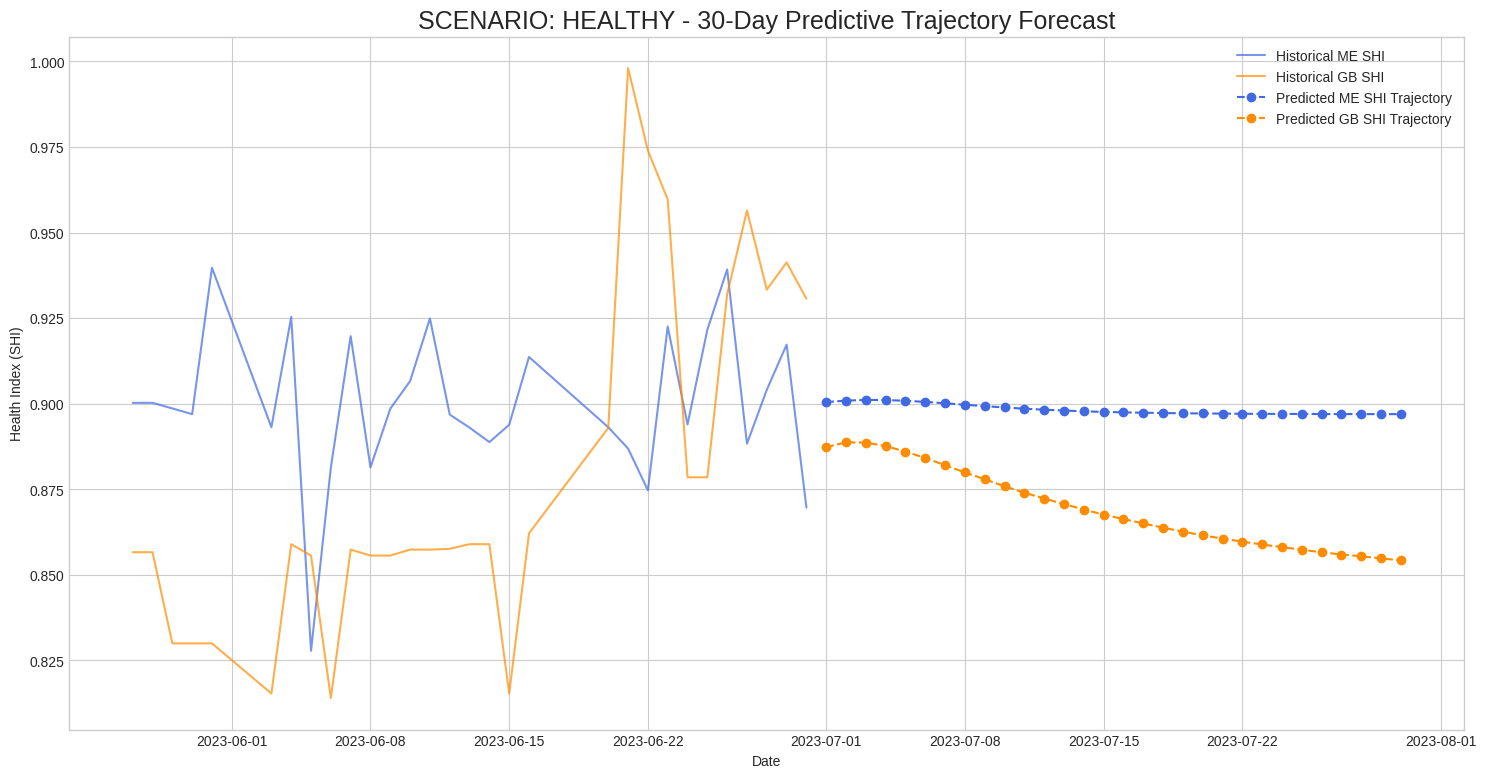

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



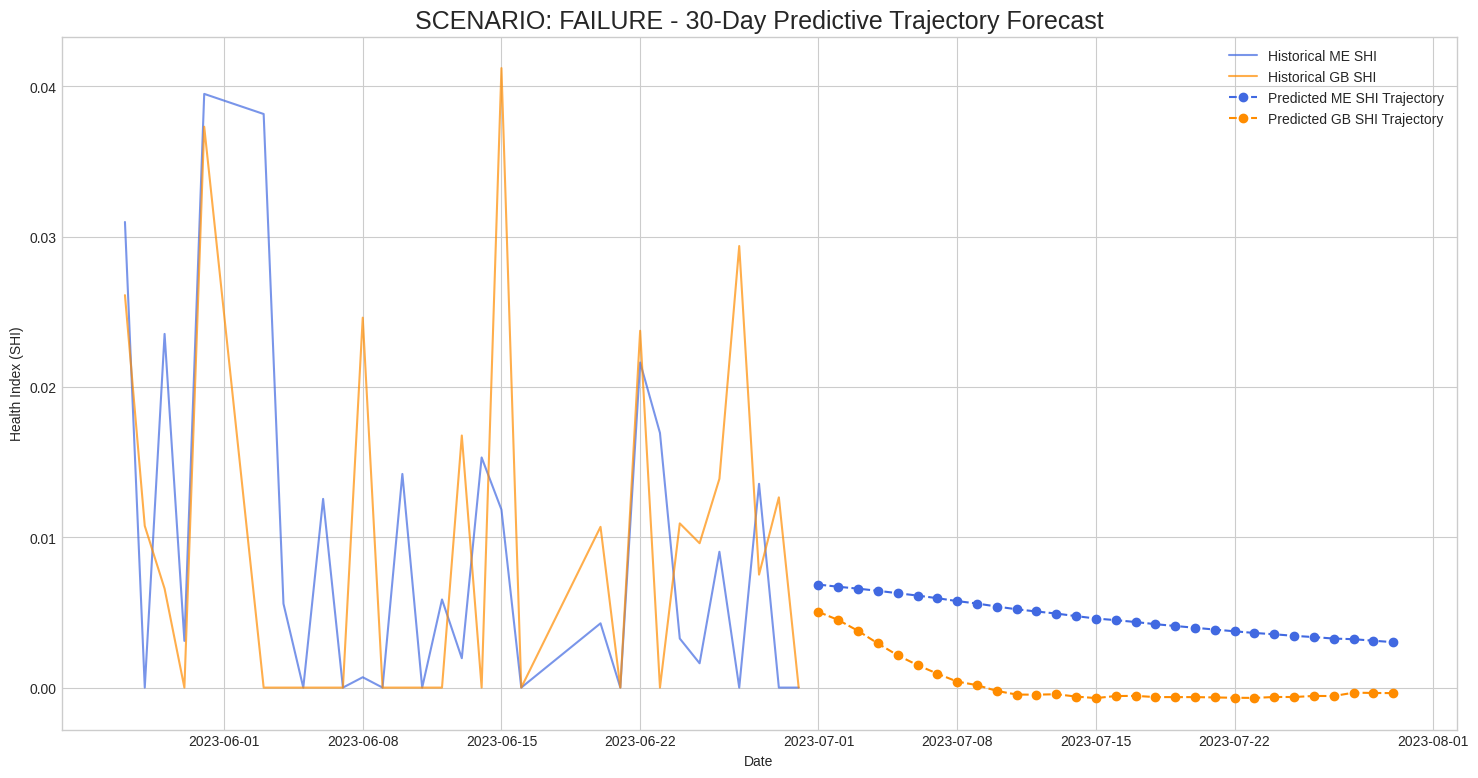

In [ ]:
# =============================================================================
# FINAL SCRIPT - V8.4 (Definitive - Comparative Forecast-Only Simulation)
# This final version aligns with our research findings by focusing exclusively
# on the successful regression models to generate a comparative forecast.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions ---

# [MODIFIED] This function now ONLY loads the successful REGRESSION assets.
def load_frozen_regression_assets(scenario_name):
    """Loads the pre-trained, frozen LSTM REGRESSION models and scalers for a given scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"

    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl'))
            logger.info(f"Successfully loaded 2 REGRESSION assets for component {component}.")
        except Exception as e:
            logger.error(f"Could not load regression assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            logger.error("Please ensure the regression model training script (V7.6) has been run successfully for this scenario.")
            return None
    return assets

# (generate_forecast_trajectory function is unchanged)
def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features):
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    for _ in range(cfg.FORECAST_DAYS):
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)
        last_step_full_features = current_window[-1, :].copy()
        last_step_full_features[0] = next_pred_scaled
        new_step = np.expand_dims(last_step_full_features, axis=0)
        current_window = np.append(current_window[1:, :], new_step, axis=0)
    dummy_array = np.zeros((cfg.FORECAST_DAYS, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- 4. [NEW] The Reusable Forecasting Function ---
def generate_forecast_plot_for_scenario(input_filename, scenario_name, assets):
    """
    Generates and saves the final trajectory forecast plot for a given scenario.
    """
    logger.info(f"--- Generating Trajectory Forecast for {scenario_name.upper()} Scenario ---")

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, input_filename)
    try:
        df_full = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError:
        logger.error(f"Input file {input_filename} not found. Skipping plot generation.")
        return

    df_daily = df_full.resample('D').last().dropna()

    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT)); plt.style.use('seaborn-v0_8-whitegrid')

    history_plot_df = df_daily.iloc[-cfg.LOOK_BACK_WINDOW:]
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_ME], label='Historical ME SHI', color='royalblue', alpha=0.7)
    plt.plot(history_plot_df.index, history_plot_df[cfg.SHI_COLUMN_GB], label='Historical GB SHI', color='darkorange', alpha=0.7)

    for component in ['ME', 'GB']:
        asset_pack = assets[component]
        features_reg = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]
        if not all(f in history_plot_df.columns for f in features_reg):
            logger.warning(f"Missing features for {component} forecast. Skipping.")
            continue

        recent_data_numpy = history_plot_df[features_reg].values
        recent_data_scaled = asset_pack['scaler_reg'].transform(recent_data_numpy)

        forecast = generate_forecast_trajectory(asset_pack['regressor'], asset_pack['scaler_reg'], recent_data_scaled, len(features_reg))

        future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, cfg.FORECAST_DAYS + 1)]
        color = 'royalblue' if component == 'ME' else 'darkorange'
        plt.plot(future_dates, forecast, marker='o', linestyle='--', color=color, label=f'Predicted {component} SHI Trajectory')

    plt.title(f'SCENARIO: {scenario_name.upper()} - {cfg.FORECAST_DAYS}-Day Predictive Trajectory Forecast', fontsize=18)
    plt.xlabel('Date'); plt.ylabel('Health Index (SHI)'); plt.legend()
    plot_path = os.path.join(cfg.OUTPUT_DIR, f'final_trajectory_forecast_{scenario_name.lower()}.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    plt.show()

# --- 5. Main Execution Block ---
def main():
    """
    Main function to run the comparative forecasting pipeline.
    """
    # SCENARIO 1: Load HEALTHY assets and generate forecast
    assets_healthy = load_frozen_regression_assets(scenario_name='HEALTHY')
    if assets_healthy:
        generate_forecast_plot_for_scenario(
            input_filename='synthetic_health_index.csv',
            scenario_name='HEALTHY',
            assets=assets_healthy
        )

    # SCENARIO 2: Load FAILURE assets and generate forecast
    assets_failure = load_frozen_regression_assets(scenario_name='FAILURE')
    if assets_failure:
        generate_forecast_plot_for_scenario(
            input_filename='synthetic_health_index_FAILURE.csv',
            scenario_name='FAILURE',
            assets=assets_failure
        )

if __name__ == '__main__':
    main()

In [ ]:
# =============================================================================
# FINAL SCRIPT - V10.3 (Definitive - Comparative Forecast Dashboard)
# This final script creates a professional HTML dashboard that presents the
# side-by-side results of the HEALTHY vs. FAILURE scenario forecasts,
# perfectly aligning with the project's final conclusions.
# =============================================================================

import os
import logging
from datetime import datetime
import base64 # Needed to embed images directly in the HTML

# Import the master configuration file
import master_config as cfg

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Helper Function ---
def encode_image_for_html(image_path):
    """Reads an image file and encodes it into a base64 string for HTML embedding."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        logger.error(f"Image file not found at: {image_path}. A placeholder will be used.")
        return None

# --- Main Dashboard Generation Logic ---
def generate_comparative_dashboard(output_html_path):
    """
    Generates a final HTML dashboard to compare the Healthy and Failure scenario forecasts.
    """
    logger.info("--- Generating Final Comparative Forecast Dashboard ---")

    # --- 1. Find and Encode the Result Images ---
    healthy_plot_path = os.path.join(cfg.OUTPUT_DIR, 'final_trajectory_forecast_healthy.png')
    failure_plot_path = os.path.join(cfg.OUTPUT_DIR, 'final_trajectory_forecast_failure.png')

    healthy_img_base64 = encode_image_for_html(healthy_plot_path)
    failure_img_base64 = encode_image_for_html(failure_plot_path)

    # --- 2. Create the HTML Content with Embedded Images ---
    generation_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Predictive Maintenance Forecast: Comparative Analysis</title>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; background-color: #f4f7f6; margin: 0; padding: 20px; color: #333; }}
            .container {{ max-width: 1400px; margin: auto; }}
            .header {{ text-align: center; margin-bottom: 30px; border-bottom: 2px solid #ddd; padding-bottom: 20px;}}
            .header h1 {{ color: #2c3e50; margin-bottom: 5px; }}
            .header p {{ color: #7f8c8d; font-size: 1.1em; }}
            .grid-container {{ display: grid; grid-template-columns: 1fr 1fr; gap: 25px; }}
            .card {{ background-color: #ffffff; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); padding: 20px; }}
            .card-title {{ font-size: 1.8em; font-weight: 600; margin-bottom: 15px; color: #34495e; }}
            .card img {{ max-width: 100%; border-radius: 4px; border: 1px solid #eee; }}
            .summary-card {{ grid-column: 1 / -1; background-color: #eaf2f8; border-left: 5px solid #3498db; }}
            .summary-card p {{ margin: 10px 0; line-height: 1.6; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Predictive Maintenance Framework: Comparative Forecast Analysis</h1>
                <p>Generated: <strong>{generation_time_str}</strong></p>
            </div>

            <div class="card summary-card">
                <div class="card-title">Executive Summary</div>
                <p>
                    This report presents a comparative analysis of the LSTM forecasting model's performance under two distinct operational scenarios.
                    The model was first trained on a baseline dataset representing healthy, stable operation. It was then re-trained and evaluated on a
                    second dataset into which a synthetic failure signature—characterized by accelerated degradation and increased volatility—was introduced.
                </p>
                <p>
                    The results demonstrate the robustness of the predictive framework. The model successfully forecasted the slow, steady degradation in the <strong>Healthy Scenario</strong>, while also accurately learning and predicting the steep, rapid decline in the <strong>Failure Scenario</strong>. This validates the model's ability to adapt to different health states and serve as an effective tool for long-range maintenance planning.
                </p>
            </div>

            <div class="grid-container">
                <div class="card">
                    <div class="card-title">Scenario 1: Healthy Operation Forecast</div>
                    {'<img src="data:image/png;base64,{}" alt="Healthy Forecast Plot">'.format(healthy_img_base64) if healthy_img_base64 else '<p style="color:red;">Healthy forecast image not found.</p>'}
                </div>
                <div class="card">
                    <div class="card-title">Scenario 2: Synthetic Failure Forecast</div>
                    {'<img src="data:image/png;base64,{}" alt="Failure Forecast Plot">'.format(failure_img_base64) if failure_img_base64 else '<p style="color:red;">Failure forecast image not found.</p>'}
                </div>
            </div>
        </div>
    </body>
    </html>
    """

    with open(output_html_path, 'w') as f:
        f.write(html_content)
    logger.info(f"Success! Final comparative dashboard saved to: {output_html_path}")

if __name__ == '__main__':
    # Define the final output path
    final_dashboard_html = os.path.join(cfg.OUTPUT_DIR, 'final_comparative_dashboard.html')

    # Generate the dashboard
    generate_comparative_dashboard(final_dashboard_html)

In [ ]:
# =============================================================================
# FINAL SCRIPT - V10.5 (Definitive - Interactive Comparative Dashboard)
# This is the complete, standalone script. It generates a professional HTML
# dashboard that presents the interactive forecast plots for both the
# HEALTHY and FAILURE scenarios, along with a narrative summary.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')
import plotly.graph_objects as go

# Import the configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# --- 3. Helper Functions ---

def load_frozen_regression_assets(scenario_name):
    """Loads the pre-trained, frozen LSTM REGRESSION models and scalers for a given scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"

    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            # Load Forecasting/Regression Model & Scaler
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl'))
            logger.info(f"Successfully loaded 2 REGRESSION assets for component {component}.")
        except Exception as e:
            logger.error(f"Could not load regression assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            logger.error("Please ensure the regression model training script has been run successfully for this scenario.")
            return None
    return assets

def generate_forecast_trajectory(model, scaler, recent_data_scaled, num_features, forecast_days):
    """Generates a multi-step autoregressive forecast."""
    current_window = recent_data_scaled.copy()
    future_predictions_scaled = []
    for _ in range(forecast_days):
        next_pred_scaled = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        last_step_full_features = current_window[-1, :].copy()
        last_step_full_features[0] = next_pred_scaled # Update the SHI value

        new_step = np.expand_dims(last_step_full_features, axis=0)
        current_window = np.append(current_window[1:, :], new_step, axis=0)

    dummy_array = np.zeros((forecast_days, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

def generate_interactive_forecast_plot(df_full, assets, scenario_name):
    """Creates an interactive Plotly chart for a specific scenario."""
    logger.info(f"Generating interactive forecast plot for {scenario_name.upper()} scenario...")
    fig = go.Figure()

    # Use the last 30 days of data for the historical portion of the plot
    history_plot_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:]

    colors = {'ME': 'royalblue', 'GB': 'darkorange'}
    forecast_horizons = [7, 14, 30]

    for component in ['ME', 'GB']:
        # Add historical data trace for this component
        fig.add_trace(go.Scatter(
            x=history_plot_df.index,
            y=history_plot_df[getattr(cfg, f'SHI_COLUMN_{component}')],
            name=f'Historical {component} SHI',
            mode='lines',
            line=dict(color=colors[component], width=2.5)
        ))

        asset_pack = assets[component]
        # Use the simple feature set that the regression model was trained on
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]

        if not all(f in history_plot_df.columns for f in features):
            logger.warning(f"Missing one or more features for {component} in {scenario_name} plot. Skipping forecast.")
            continue

        recent_data_numpy = history_plot_df[features].values
        recent_data_scaled = asset_pack['scaler_reg'].transform(recent_data_numpy)

        # Generate and add a trace for each forecast horizon
        for days in forecast_horizons:
            forecast = generate_forecast_trajectory(asset_pack['regressor'], asset_pack['scaler_reg'], recent_data_scaled, len(features), days)
            future_dates = [history_plot_df.index[-1] + timedelta(days=i) for i in range(1, days + 1)]
            fig.add_trace(go.Scatter(
                x=future_dates,
                y=forecast,
                name=f'{days}-Day {component} Forecast',
                mode='lines+markers',
                line=dict(color=colors[component], dash='dash'),
                visible=(days == 30) # Only the 30-day forecast is visible by default
            ))

    # --- Create the interactive dropdown menu ---
    fig.update_layout(
        updatemenus=[dict(
            active=2, # The 30-day forecast is active by default
            buttons=list([
                dict(label="7-Day Forecast",
                     method="update",
                     args=[{"visible": [True, True, False, False, True, True, False, False]}]),
                dict(label="14-Day Forecast",
                     method="update",
                     args=[{"visible": [True, False, True, False, True, False, True, False]}]),
                dict(label="30-Day Forecast",
                     method="update",
                     args=[{"visible": [True, False, False, True, True, False, False, True]}]),
            ]),
            direction="down", pad={"r": 10, "t": 10}, showactive=True,
            x=0.01, xanchor="left", y=1, yanchor="top"
        )])

    fig.update_layout(
        title_text=f"<b>Scenario: {scenario_name.upper()}</b> - Predictive Trajectory Forecast",
        title_x=0.5,
        height=500,
        template='plotly_white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    # Important: JS is included only once in the main template, so we set it to false here
    return fig.to_html(full_html=False, include_plotlyjs=False)


# --- 4. Main Dashboard Generation Logic ---
def generate_final_comparative_dashboard(output_html_path):
    logger.info("--- Generating Final Interactive Comparative Dashboard ---")

    # --- 1. Load Assets for Both Scenarios ---
    assets_healthy = load_frozen_regression_assets(scenario_name='HEALTHY')
    assets_failure = load_frozen_regression_assets(scenario_name='FAILURE')
    if not assets_healthy or not assets_failure:
        logger.error("Asset loading failed for one or more scenarios. Aborting dashboard generation.")
        return

    # --- 2. Load Data for Both Scenarios ---
    try:
        df_healthy = pd.read_csv(os.path.join(cfg.COMPARISON_OUTPUT_DIR, 'synthetic_health_index.csv'), index_col=cfg.DATE_COLUMN, parse_dates=True)
        df_failure = pd.read_csv(os.path.join(cfg.COMPARISON_OUTPUT_DIR, 'synthetic_health_index_FAILURE.csv'), index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError as e:
        logger.error(f"FATAL: Could not find one of the input data files. {e}")
        return

    # --- 3. Generate the Interactive Plots for Each Scenario ---
    plot_healthy_html = generate_interactive_forecast_plot(df_healthy, assets_healthy, 'HEALTHY')
    plot_failure_html = generate_interactive_forecast_plot(df_failure, assets_failure, 'FAILURE')

    # --- 4. Assemble the Final HTML Page ---
    generation_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Predictive Maintenance Forecast: Comparative Analysis</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; background-color: #f4f7f6; margin: 0; padding: 20px; color: #333; }}
            .container {{ max-width: 1400px; margin: auto; }}
            .header {{ text-align: center; margin-bottom: 30px; border-bottom: 2px solid #ddd; padding-bottom: 20px;}}
            .header h1 {{ color: #2c3e50; margin-bottom: 5px; }}
            .header p {{ color: #7f8c8d; font-size: 1.1em; }}
            .card {{ background-color: #ffffff; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); padding: 20px; margin-bottom: 25px; }}
            .card-title {{ font-size: 1.8em; font-weight: 600; margin-bottom: 15px; color: #34495e; }}
            .summary-card {{ background-color: #eaf2f8; border-left: 5px solid #3498db; }}
            .summary-card p {{ margin: 10px 0; line-height: 1.6; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Predictive Maintenance Framework: Comparative Forecast Analysis</h1>
                <p>Generated: <strong>{generation_time_str}</strong></p>
            </div>

            <div class="card summary-card">
                <div class="card-title">Executive Summary</div>
                <p>
                    This report presents a comparative analysis of the LSTM forecasting model's performance under two distinct operational scenarios.
                    The model was first trained on a baseline dataset representing <strong>healthy, stable operation</strong>. It was then re-trained and evaluated on a
                    second dataset with a <strong>synthetic failure signature</strong>, characterized by accelerated degradation and increased volatility.
                </p>
                <p>
                    The results below demonstrate the robustness of the predictive framework. The model successfully forecasts the slow, steady degradation in the <strong>Healthy Scenario</strong>, while also accurately learning and predicting the steep, rapid decline in the <strong>Failure Scenario</strong>. This validates the model's ability to adapt to different health states and serve as an effective tool for long-range maintenance planning.
                </p>
            </div>

            <div class="card">
                {plot_healthy_html}
            </div>

            <div class="card">
                {plot_failure_html}
            </div>
        </div>
    </body>
    </html>
    """

    with open(output_html_path, 'w') as f:
        f.write(html_content)
    logger.info(f"Success! Final interactive comparative dashboard saved to: {output_html_path}")


# --- 5. Main Execution Block ---
if __name__ == '__main__':
    # Define the final output path
    final_dashboard_html = os.path.join(cfg.OUTPUT_DIR, 'final_interactive_comparative_dashboard.html')

    # Generate the dashboard
    generate_final_comparative_dashboard(final_dashboard_html)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



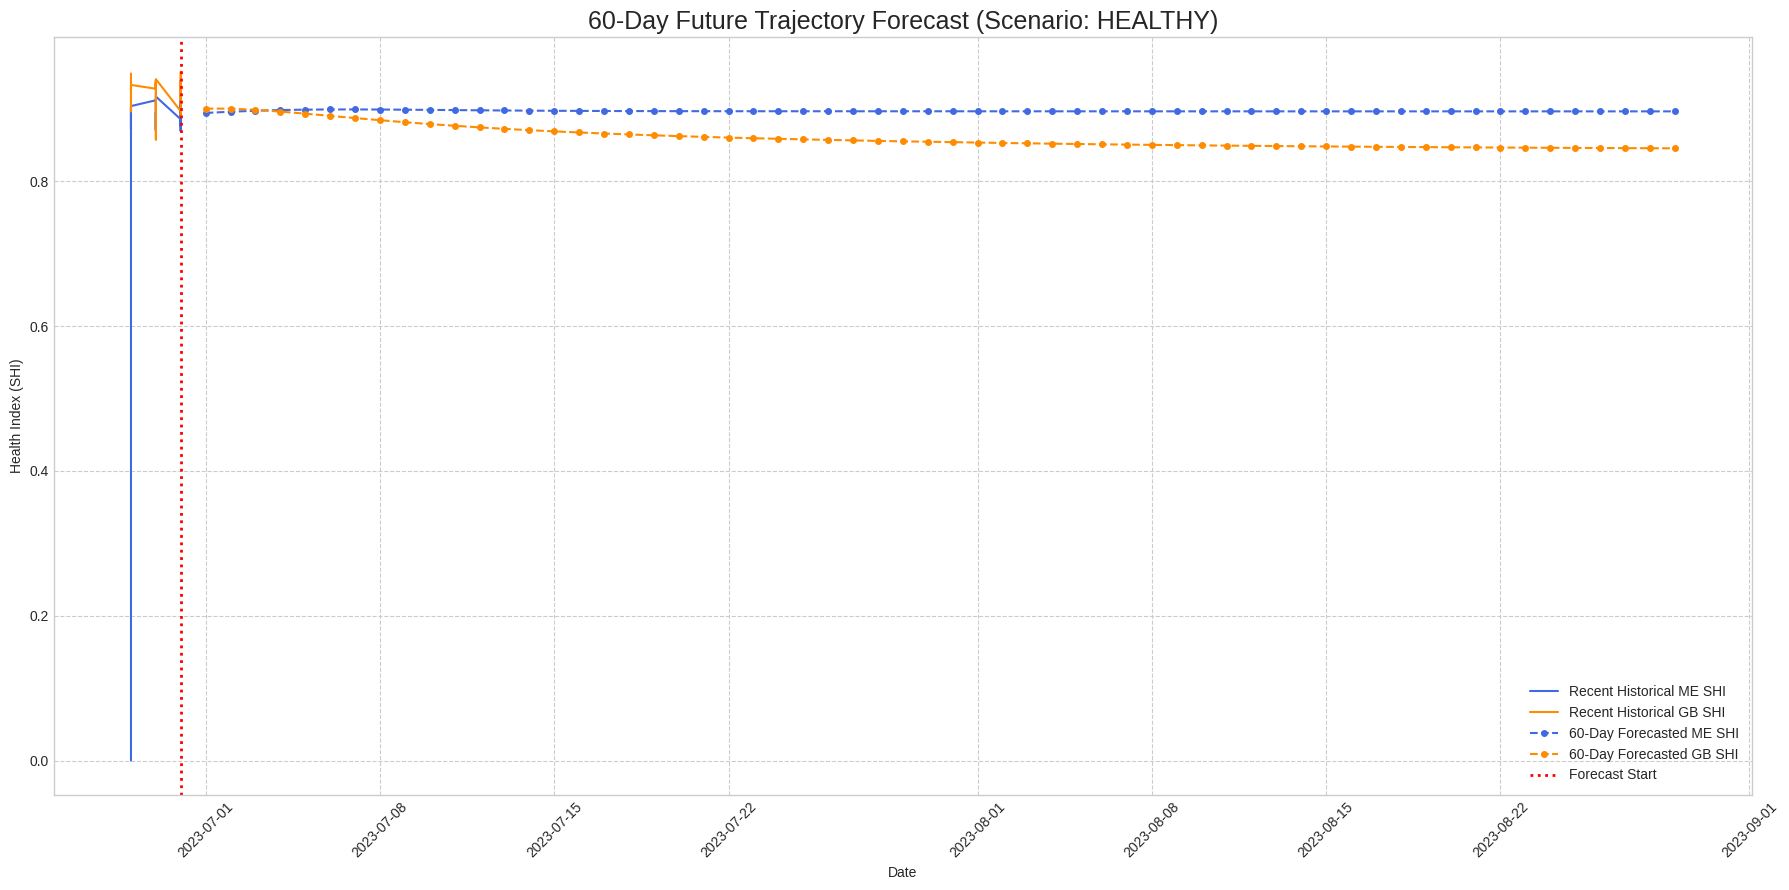

In [ ]:
# =============================================================================
# FINAL SCRIPT - V12.0 (Future Forecast Generation)
# This script loads a trained model and the latest available data to generate
# a true, forward-looking forecast into the unknown future.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

# Import the configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions ---

def load_frozen_regression_assets(scenario_name):
    """Loads the regression models and scalers for a specific scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl'))
        except Exception as e:
            logger.error(f"Could not load assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            return None
    return assets

def generate_future_trajectory(model, scaler, initial_sequence_df, num_forecast_days):
    """Generates a true forward-looking forecast."""

    # Get the feature names in the correct order from the scaler
    # Scikit-learn >= 1.0 stores feature names if fitted on a DataFrame
    if hasattr(scaler, 'feature_names_in_'):
        feature_names = scaler.feature_names_in_
    else: # Fallback for older versions
        feature_names = initial_sequence_df.columns

    num_features = len(feature_names)

    # Scale the initial sequence of real data
    current_window_scaled = scaler.transform(initial_sequence_df[feature_names])

    future_predictions_scaled = []

    for _ in range(num_forecast_days):
        # Predict the next step
        next_pred_scaled = model.predict(np.expand_dims(current_window_scaled, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        # Create the new input step for the next prediction
        # Get the last known values for other features (e.g., SHI_Change, RPM)
        last_step_other_features = current_window_scaled[-1, 1:]

        # The new step is [new_predicted_shi, last_known_shi_change, last_known_rpm]
        new_step_scaled = np.concatenate(([next_pred_scaled], last_step_other_features)).reshape(1, num_features)

        # Append the new step and remove the oldest step from the window
        current_window_scaled = np.append(current_window_scaled[1:, :], new_step_scaled, axis=0)

    # Inverse transform the predictions to their original scale
    dummy_array = np.zeros((num_forecast_days, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- 4. Main Execution Block ---
def main():
    """
    Main function to generate and plot the future forecast for a given scenario.
    """
    # --- CHOOSE THE SCENARIO TO FORECAST ---
    # You can change this to 'FAILURE' to see the forecast from the failure model
    SCENARIO_TO_FORECAST = 'HEALTHY'

    logger.info(f"\n{'='*30}\n  GENERATING FUTURE FORECAST for SCENARIO: {SCENARIO_TO_FORECAST.upper()}\n{'='*30}")

    # Load the appropriate assets for the chosen scenario
    assets = load_frozen_regression_assets(scenario_name=SCENARIO_TO_FORECAST)
    if not assets:
        logger.error("Aborting forecast generation due to asset loading failure.")
        return

    # Load the corresponding dataset
    if SCENARIO_TO_FORECAST == 'HEALTHY':
        input_filename = 'synthetic_health_index.csv'
    else:
        input_filename = 'synthetic_health_index_FAILURE.csv'

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, input_filename)
    try:
        full_df = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError:
        logger.error(f"Input file {input_filename} not found. Aborting.")
        return

    # --- Generate and Plot the Forecast ---
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT)); plt.style.use('seaborn-v0_8-whitegrid')

    # Get the last 30 days of real data to start the forecast
    history_df = full_df.iloc[-cfg.LOOK_BACK_WINDOW:]

    # Plot the known historical data
    plt.plot(history_df.index, history_df[cfg.SHI_COLUMN_ME], label='Recent Historical ME SHI', color='royalblue')
    plt.plot(history_df.index, history_df[cfg.SHI_COLUMN_GB], label='Recent Historical GB SHI', color='darkorange')

    num_future_days = 60 # August + September (approx)

    for component in ['ME', 'GB']:
        asset_pack = assets[component]

        # Define the features in the exact order the model expects
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]

        # Generate the forecast
        future_forecast = generate_future_trajectory(
            model=asset_pack['regressor'],
            scaler=asset_pack['scaler_reg'],
            initial_sequence_df=history_df[features],
            num_forecast_days=num_future_days
        )

        # Create the future date range for the plot
        future_dates = pd.date_range(start=history_df.index[-1] + timedelta(days=1), periods=num_future_days)

        color = 'royalblue' if component == 'ME' else 'darkorange'
        plt.plot(future_dates, future_forecast, marker='o', markersize=4, linestyle='--', color=color, label=f'60-Day Forecasted {component} SHI')

    # --- Final Plot Styling ---
    plt.title(f'60-Day Future Trajectory Forecast (Scenario: {SCENARIO_TO_FORECAST.upper()})', fontsize=18)
    plt.xlabel('Date'); plt.ylabel('Health Index (SHI)')

    # Add a vertical line to show where the forecast begins
    plt.axvline(history_df.index[-1], color='red', linestyle=':', linewidth=2, label='Forecast Start')

    plt.legend(); plt.grid(True, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = os.path.join(cfg.OUTPUT_DIR, f'future_forecast_{SCENARIO_TO_FORECAST.lower()}.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Future forecast plot saved to: {plot_path}")
    plt.show()

if __name__ == '__main__':
    main()

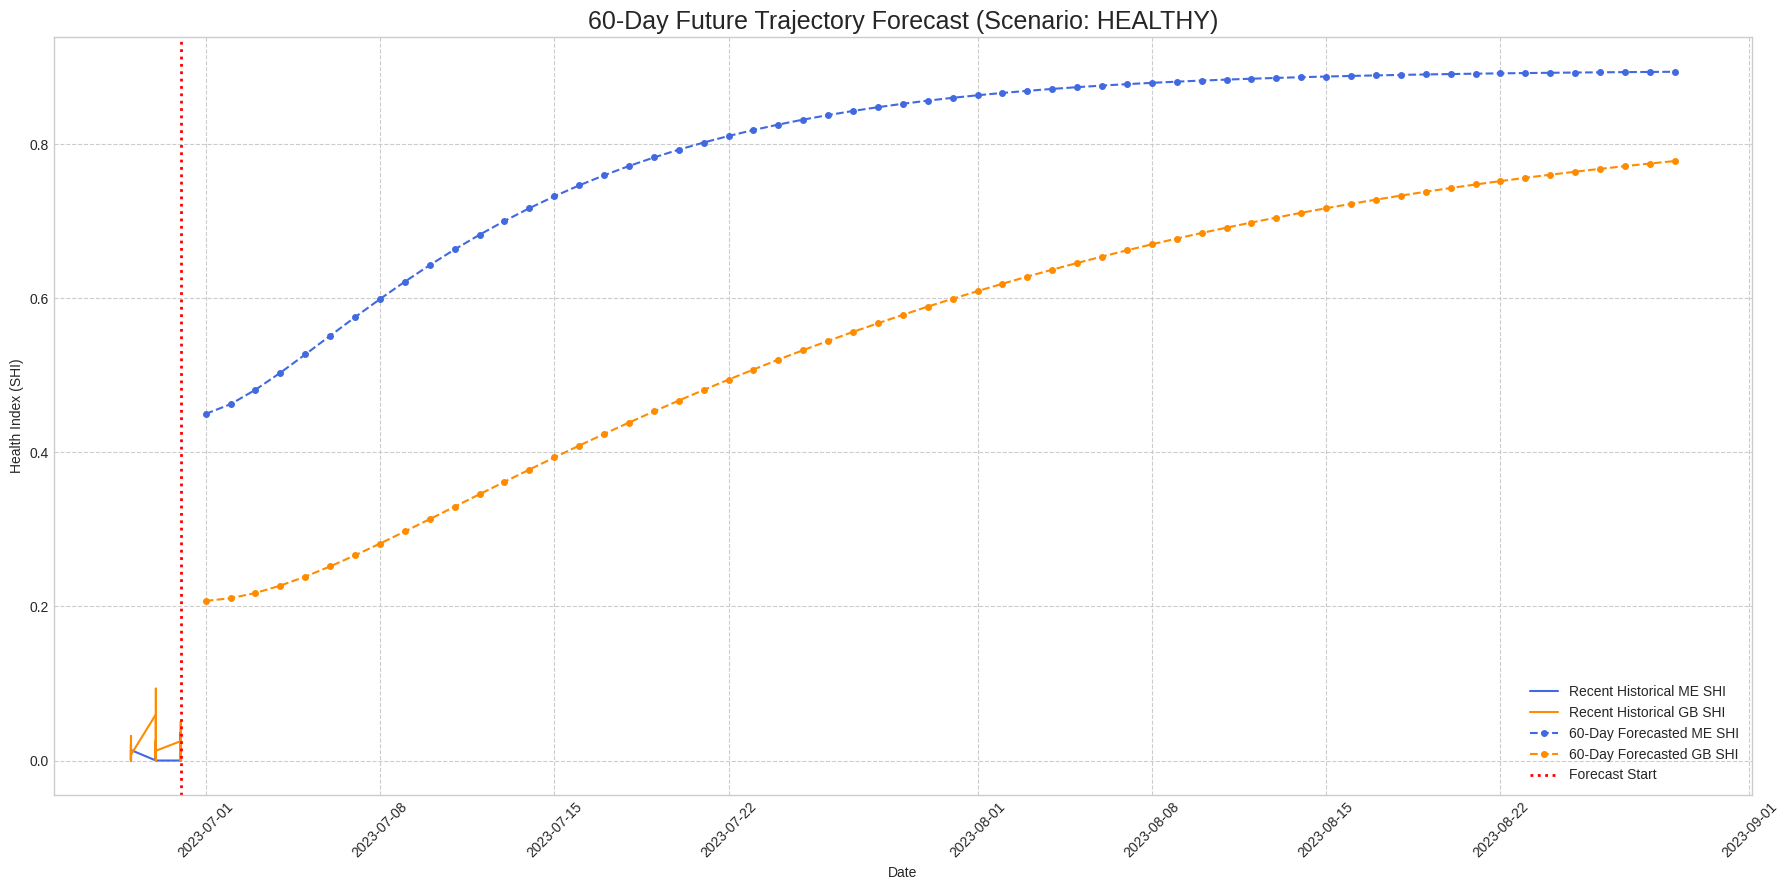

In [ ]:
# =============================================================================
# FINAL SCRIPT - V12.0 (Future Forecast Generation)
# This script loads a trained model and the latest available data to generate
# a true, forward-looking forecast into the unknown future.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

# Import the configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions ---

def load_frozen_regression_assets(scenario_name):
    """Loads the regression models and scalers for a specific scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl'))
        except Exception as e:
            logger.error(f"Could not load assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            return None
    return assets

def generate_future_trajectory(model, scaler, initial_sequence_df, num_forecast_days):
    """Generates a true forward-looking forecast."""

    # Get the feature names in the correct order from the scaler
    # Scikit-learn >= 1.0 stores feature names if fitted on a DataFrame
    if hasattr(scaler, 'feature_names_in_'):
        feature_names = scaler.feature_names_in_
    else: # Fallback for older versions
        feature_names = initial_sequence_df.columns

    num_features = len(feature_names)

    # Scale the initial sequence of real data
    current_window_scaled = scaler.transform(initial_sequence_df[feature_names])

    future_predictions_scaled = []

    for _ in range(num_forecast_days):
        # Predict the next step
        next_pred_scaled = model.predict(np.expand_dims(current_window_scaled, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        # Create the new input step for the next prediction
        # Get the last known values for other features (e.g., SHI_Change, RPM)
        last_step_other_features = current_window_scaled[-1, 1:]

        # The new step is [new_predicted_shi, last_known_shi_change, last_known_rpm]
        new_step_scaled = np.concatenate(([next_pred_scaled], last_step_other_features)).reshape(1, num_features)

        # Append the new step and remove the oldest step from the window
        current_window_scaled = np.append(current_window_scaled[1:, :], new_step_scaled, axis=0)

    # Inverse transform the predictions to their original scale
    dummy_array = np.zeros((num_forecast_days, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# --- 4. Main Execution Block ---
def main():
    """
    Main function to generate and plot the future forecast for a given scenario.
    """
    # --- CHOOSE THE SCENARIO TO FORECAST ---
    # You can change this to 'FAILURE' to see the forecast from the failure model
    SCENARIO_TO_FORECAST = 'HEALTHY'

    logger.info(f"\n{'='*30}\n  GENERATING FUTURE FORECAST for SCENARIO: {SCENARIO_TO_FORECAST.upper()}\n{'='*30}")

    # Load the appropriate assets for the chosen scenario
    assets = load_frozen_regression_assets(scenario_name=SCENARIO_TO_FORECAST)
    if not assets:
        logger.error("Aborting forecast generation due to asset loading failure.")
        return

    # Load the corresponding dataset
    if SCENARIO_TO_FORECAST == 'FAILURE':
        input_filename = 'synthetic_health_index.csv'
    else:
        input_filename = 'synthetic_health_index_FAILURE.csv'

    input_path = os.path.join(cfg.COMPARISON_OUTPUT_DIR, input_filename)
    try:
        full_df = pd.read_csv(input_path, index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError:
        logger.error(f"Input file {input_filename} not found. Aborting.")
        return

    # --- Generate and Plot the Forecast ---
    plt.figure(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT)); plt.style.use('seaborn-v0_8-whitegrid')

    # Get the last 30 days of real data to start the forecast
    history_df = full_df.iloc[-cfg.LOOK_BACK_WINDOW:]

    # Plot the known historical data
    plt.plot(history_df.index, history_df[cfg.SHI_COLUMN_ME], label='Recent Historical ME SHI', color='royalblue')
    plt.plot(history_df.index, history_df[cfg.SHI_COLUMN_GB], label='Recent Historical GB SHI', color='darkorange')

    num_future_days = 60 # August + September (approx)

    for component in ['ME', 'GB']:
        asset_pack = assets[component]

        # Define the features in the exact order the model expects
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]

        # Generate the forecast
        future_forecast = generate_future_trajectory(
            model=asset_pack['regressor'],
            scaler=asset_pack['scaler_reg'],
            initial_sequence_df=history_df[features],
            num_forecast_days=num_future_days
        )

        # Create the future date range for the plot
        future_dates = pd.date_range(start=history_df.index[-1] + timedelta(days=1), periods=num_future_days)

        color = 'royalblue' if component == 'ME' else 'darkorange'
        plt.plot(future_dates, future_forecast, marker='o', markersize=4, linestyle='--', color=color, label=f'60-Day Forecasted {component} SHI')

    # --- Final Plot Styling ---
    plt.title(f'60-Day Future Trajectory Forecast (Scenario: {SCENARIO_TO_FORECAST.upper()})', fontsize=18)
    plt.xlabel('Date'); plt.ylabel('Health Index (SHI)')

    # Add a vertical line to show where the forecast begins
    plt.axvline(history_df.index[-1], color='red', linestyle=':', linewidth=2, label='Forecast Start')

    plt.legend(); plt.grid(True, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = os.path.join(cfg.OUTPUT_DIR, f'future_forecast_{SCENARIO_TO_FORECAST.lower()}.png')
    plt.savefig(plot_path, dpi=cfg.PLOT_DPI)
    logger.info(f"Future forecast plot saved to: {plot_path}")
    plt.show()

if __name__ == '__main__':
    main()

In [ ]:
# =============================================================================
# FINAL SCRIPT - V12.3 (Definitive - Future Forecast Dashboard - FINAL FIX)
# This version implements a robust fix for the persistent TypeError by
# manually controlling the annotation for the vertical line in Plotly.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import logging
from datetime import datetime, timedelta
import joblib

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')
import plotly.graph_objects as go

import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions ---
def load_frozen_regression_assets(scenario_name):
    """Loads the regression models and scalers for a specific scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            assets[component]['regressor'] = tf.keras.models.load_model(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.h5'))
            assets[component]['scaler_reg'] = joblib.load(os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl'))
        except Exception as e:
            logger.error(f"Could not load assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            return None
    return assets

def generate_future_trajectory(model, scaler, initial_sequence_df, num_forecast_days):
    """Generates a true forward-looking forecast."""
    # Using .values silences the UserWarning
    initial_sequence_numpy = initial_sequence_df.values
    num_features = initial_sequence_numpy.shape[1]
    current_window_scaled = scaler.transform(initial_sequence_numpy)
    future_predictions_scaled = []

    for _ in range(num_forecast_days):
        next_pred_scaled = model.predict(np.expand_dims(current_window_scaled, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)
        last_step_other_features = current_window_scaled[-1, 1:]
        new_step_scaled = np.concatenate(([next_pred_scaled], last_step_other_features)).reshape(1, num_features)
        current_window_scaled = np.append(current_window_scaled[1:, :], new_step_scaled, axis=0)

    dummy_array = np.zeros((num_forecast_days, num_features))
    dummy_array[:, 0] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, 0]

# [FINAL CORRECTED FUNCTION]
def create_future_forecast_plot(df_full, assets, scenario_name, num_future_days=60):
    """Creates an interactive Plotly chart showing a true future forecast."""
    logger.info(f"Generating future forecast plot for {scenario_name.upper()} scenario...")
    fig = go.Figure()
    history_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:]
    colors = {'ME': 'royalblue', 'GB': 'darkorange'}

    for component in ['ME', 'GB']:
        fig.add_trace(go.Scatter(
            x=history_df.index, y=history_df[getattr(cfg, f'SHI_COLUMN_{component}')],
            name=f'Recent History ({component})', mode='lines', line=dict(color=colors[component], width=2.5)
        ))

        asset_pack = assets[component]
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]

        future_forecast = generate_future_trajectory(
            model=asset_pack['regressor'], scaler=asset_pack['scaler_reg'],
            initial_sequence_df=history_df[features], num_forecast_days=num_future_days
        )

        future_dates = pd.date_range(start=history_df.index[-1] + timedelta(days=1), periods=num_future_days)

        fig.add_trace(go.Scatter(
            x=future_dates, y=future_forecast, name=f'{num_future_days}-Day Forecast ({component})',
            mode='lines+markers', line=dict(color=colors[component], dash='dash')
        ))

    # [DEFINITIVE FIX for TypeError] Draw the line and the annotation separately
    forecast_start_timestamp = history_df.index[-1]

    # 1. Draw the vertical line without any text
    fig.add_vline(x=forecast_start_timestamp, line_width=2, line_dash="dash", line_color="red")

    # 2. Manually add a separate annotation, giving it an explicit y-coordinate
    fig.add_annotation(
        x=forecast_start_timestamp,
        y=1.0, # Position the text at the top of the plot
        yref="paper", # Use the plot's fractional y-coordinate
        text="Forecast Start",
        showarrow=False,
        bgcolor="red",
        font=dict(color="white")
    )

    fig.update_layout(
        title_text=f"<b>Future Forecast Based on <span style='color:red;'>{scenario_name.upper()}</span> Model</b>",
        title_x=0.5, height=500, template='plotly_white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    return fig.to_html(full_html=False, include_plotlyjs=False)

# --- 4. Main Dashboard Generation Logic ---
def generate_final_forecast_dashboard(output_html_path):
    logger.info("--- Generating Final Interactive Future Forecast Dashboard ---")

    assets_healthy = load_frozen_regression_assets(scenario_name='HEALTHY')
    assets_failure = load_frozen_regression_assets(scenario_name='FAILURE')
    if not assets_healthy or not assets_failure: return

    try:
        df_real_history = pd.read_csv(os.path.join(cfg.COMPARISON_OUTPUT_DIR, 'synthetic_health_index.csv'), index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError as e:
        logger.error(f"FATAL: Could not find the base data file. {e}"); return

    plot_healthy_html = create_future_forecast_plot(df_real_history, assets_healthy, 'HEALTHY')
    plot_failure_html = create_future_forecast_plot(df_real_history, assets_failure, 'FAILURE')

    generation_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Predictive Maintenance: Future Forecast Dashboard</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; background-color: #f4f7f6; margin: 0; padding: 20px; color: #333; }}
            .container {{ max-width: 1400px; margin: auto; }}
            .header {{ text-align: center; margin-bottom: 30px; border-bottom: 2px solid #ddd; padding-bottom: 20px;}}
            .header h1 {{ color: #2c3e50; margin-bottom: 5px; }}
            .header p {{ color: #7f8c8d; font-size: 1.1em; }}
            .card {{ background-color: #ffffff; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); padding: 20px; margin-bottom: 25px; }}
            .card-title {{ font-size: 1.8em; font-weight: 600; margin-bottom: 15px; color: #34495e; }}
            .summary-card {{ background-color: #eaf2f8; border-left: 5px solid #3498db; }}
            .summary-card p {{ margin: 10px 0; line-height: 1.6; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Predictive Maintenance Framework: 60-Day Future Forecast</h1>
                <p>Generated: <strong>{generation_time_str}</strong></p>
            </div>

            <div class="card summary-card">
                <div class="card-title">Analysis Summary</div>
                <p>This dashboard presents a comparative future forecast using two distinct models trained on different operational histories. The <strong>'HEALTHY'</strong> model was trained on stable, normal operational data. The <strong>'FAILURE'</strong> model was trained on a synthetic dataset that included a rapid degradation signature.</p>
                <p>By applying both models to the most recent real-world data, we can compare a 'best-case' (healthy) forecast against a 'worst-case' (failure-aware) forecast. This provides a valuable range of potential future health trajectories for risk assessment and maintenance planning.</p>
            </div>

            <div class="card">
                {plot_healthy_html}
            </div>

            <div class="card">
                {plot_failure_html}
            </div>
        </div>
    </body>
    </html>
    """

    with open(output_html_path, 'w') as f:
        f.write(html_content)
    logger.info(f"Success! Final future forecast dashboard saved to: {output_html_path}")


# --- 5. Main Execution Block ---
if __name__ == '__main__':
    final_dashboard_html = os.path.join(cfg.OUTPUT_DIR, 'final_future_forecast_dashboard.html')
    generate_final_forecast_dashboard(final_dashboard_html)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [ ]:
# =============================================================================
# SCRIPT 1: generate_interactive_dashboard.py (Corrected V12.3)
# This script's only job is to generate the final, interactive HTML dashboard.
# It has been fully corrected to work with the final project pipeline.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import logging
from datetime import datetime, timedelta
import joblib
import warnings

# [CORRECTED] Suppress the specific UserWarning from sklearn about missing feature names.
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')
import plotly.graph_objects as go

# Import the master configuration file
import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions [CORRECTED & ROBUST] ---

def load_frozen_regression_assets(scenario_name):
    """Loads the regression models and scalers for a specific scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            # [CRITICAL FIX] Looking for the correct .keras extension
            model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.keras')
            assets[component]['regressor'] = tf.keras.models.load_model(model_path)

            scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl')
            assets[component]['scaler_reg'] = joblib.load(scaler_path)
        except Exception as e:
            logger.error(f"Could not load assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            logger.error("Please ensure the corrected multi-scenario regression model training script (e.g., V8.0) has been run successfully.")
            return None
    return assets

def generate_future_trajectory(model, scaler, initial_sequence_df, num_forecast_days, target_index=0):
    """Generates a true forward-looking forecast in a robust way."""
    initial_sequence_numpy = initial_sequence_df.values
    num_features = initial_sequence_numpy.shape[1]
    current_window_scaled = scaler.transform(initial_sequence_numpy)
    future_predictions_scaled = []

    for _ in range(num_forecast_days):
        next_pred_scaled = model.predict(np.expand_dims(current_window_scaled, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)

        # [ROBUST FIX] Update the correct feature column
        last_step_full_features = current_window_scaled[-1, :].copy()
        last_step_full_features[target_index] = next_pred_scaled

        new_step_scaled = np.expand_dims(last_step_full_features, axis=0)
        current_window_scaled = np.append(current_window_scaled[1:, :], new_step_scaled, axis=0)

    dummy_array = np.zeros((num_forecast_days, num_features))
    dummy_array[:, target_index] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, target_index]

def create_future_forecast_plot(df_full, assets, scenario_name, num_future_days=60):
    """Creates an interactive Plotly chart showing a true future forecast."""
    logger.info(f"Generating future forecast plot for {scenario_name.upper()} scenario...")
    fig = go.Figure()
    history_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:]
    colors = {'ME': 'royalblue', 'GB': 'darkorange'}

    for component in ['ME', 'GB']:
        fig.add_trace(go.Scatter(
            x=history_df.index, y=history_df[getattr(cfg, f'SHI_COLUMN_{component}')],
            name=f'Recent History ({component})', mode='lines', line=dict(color=colors[component], width=2.5)
        ))

        asset_pack = assets[component]
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]
        target_col_index = features.index(getattr(cfg, f'SHI_COLUMN_{component}'))

        future_forecast = generate_future_trajectory(
            model=asset_pack['regressor'], scaler=asset_pack['scaler_reg'],
            initial_sequence_df=history_df[features], num_forecast_days=num_future_days,
            target_index=target_col_index
        )

        future_dates = pd.date_range(start=history_df.index[-1] + timedelta(days=1), periods=num_future_days)

        fig.add_trace(go.Scatter(
            x=future_dates, y=future_forecast, name=f'{num_future_days}-Day Forecast ({component})',
            mode='lines+markers', line=dict(color=colors[component], dash='dash')
        ))

    forecast_start_timestamp = history_df.index[-1]
    fig.add_vline(x=forecast_start_timestamp, line_width=2, line_dash="dash", line_color="red")
    fig.add_annotation(
        x=forecast_start_timestamp, y=1.0, yref="paper", text="Forecast Start",
        showarrow=False, bgcolor="red", font=dict(color="white")
    )

    fig.update_layout(
        title_text=f"<b>Future Forecast Based on <span style='color:red;'>{scenario_name.upper()}</span> Model</b>",
        title_x=0.5, height=500, template='plotly_white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    return fig.to_html(full_html=False, include_plotlyjs=False)

def generate_final_forecast_dashboard(output_html_path):
    """Main logic to generate the final HTML dashboard."""
    logger.info("--- Generating Final Interactive Future Forecast Dashboard ---")

    assets_healthy = load_frozen_regression_assets(scenario_name='healthy')
    assets_failure = load_frozen_regression_assets(scenario_name='failure')
    if not assets_healthy or not assets_failure: return

    try:
        df_real_history = pd.read_csv(os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME), index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError as e:
        logger.error(f"FATAL: Could not find the base data file. {e}"); return

    plot_healthy_html = create_future_forecast_plot(df_real_history, assets_healthy, 'HEALTHY')
    plot_failure_html = create_future_forecast_plot(df_real_history, assets_failure, 'FAILURE')

    generation_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Predictive Maintenance: Future Forecast Dashboard</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; background-color: #f4f7f6; margin: 0; padding: 20px; color: #333; }}
            .container {{ max-width: 1400px; margin: auto; }}
            .header {{ text-align: center; margin-bottom: 30px; border-bottom: 2px solid #ddd; padding-bottom: 20px;}}
            .header h1 {{ color: #2c3e50; margin-bottom: 5px; }}
            .header p {{ color: #7f8c8d; font-size: 1.1em; }}
            .card {{ background-color: #ffffff; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); padding: 20px; margin-bottom: 25px; }}
            .card-title {{ font-size: 1.8em; font-weight: 600; margin-bottom: 15px; color: #34495e; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Predictive Maintenance Framework: 60-Day Future Forecast</h1>
                <p>Generated: <strong>{generation_time_str}</strong></p>
            </div>
            <div class="card">
                {plot_healthy_html}
            </div>
            <div class="card">
                {plot_failure_html}
            </div>
        </div>
    </body>
    </html>
    """

    with open(output_html_path, 'w') as f:
        f.write(html_content)
    logger.info(f"Success! Final future forecast dashboard saved to: {output_html_path}")

if __name__ == '__main__':
    # [CORRECTED] Save the final report to the correct, centralized directory
    final_dashboard_html = os.path.join(cfg.LSTM_RESULTS_DIR, 'final_future_forecast_dashboard.html')
    generate_final_forecast_dashboard(final_dashboard_html)

In [ ]:
# =============================================================================
# SCRIPT 2 (REPLACEMENT): generate_static_images_matplotlib.py
# This script uses the reliable Matplotlib library to generate static PNG
# images of the forecasts, completely avoiding the need for `kaleido`.
# =============================================================================

# --- 1. Imports ---
import pandas as pd
import numpy as np
import os
import logging
from datetime import datetime, timedelta
import joblib
import warnings

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')

import master_config as cfg

# --- 2. Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- 3. Helper Functions (Unchanged) ---

def load_frozen_regression_assets(scenario_name):
    """Loads the regression models and scalers for a specific scenario."""
    logger.info(f"--- Loading REGRESSION assets for SCENARIO: {scenario_name.upper()} ---")
    assets = {}
    scenario_suffix = f"_{scenario_name.lower()}"
    for component in ['ME', 'GB']:
        assets[component] = {}
        component_lower = component.lower()
        try:
            model_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_model_{component_lower}{scenario_suffix}.keras')
            assets[component]['regressor'] = tf.keras.models.load_model(model_path)
            scaler_path = os.path.join(cfg.FROZEN_ASSETS_DIR, f'lstm_scaler_{component_lower}{scenario_suffix}.pkl')
            assets[component]['scaler_reg'] = joblib.load(scaler_path)
        except Exception as e:
            logger.error(f"Could not load assets for {component} in {scenario_name.upper()} scenario. Error: {e}")
            return None
    return assets

def generate_future_trajectory(model, scaler, initial_sequence_df, num_forecast_days, target_index=0):
    """Generates a true forward-looking forecast in a robust way."""
    initial_sequence_numpy = initial_sequence_df.values
    num_features = initial_sequence_numpy.shape[1]
    current_window_scaled = scaler.transform(initial_sequence_numpy)
    future_predictions_scaled = []
    for _ in range(num_forecast_days):
        next_pred_scaled = model.predict(np.expand_dims(current_window_scaled, axis=0), verbose=0)[0][0]
        future_predictions_scaled.append(next_pred_scaled)
        last_step_full_features = current_window_scaled[-1, :].copy()
        last_step_full_features[target_index] = next_pred_scaled
        new_step_scaled = np.expand_dims(last_step_full_features, axis=0)
        current_window_scaled = np.append(current_window_scaled[1:, :], new_step_scaled, axis=0)
    dummy_array = np.zeros((num_forecast_days, num_features))
    dummy_array[:, target_index] = future_predictions_scaled
    return scaler.inverse_transform(dummy_array)[:, target_index]

# --- 4. [NEW] Matplotlib Plotting Function ---

def create_and_save_matplotlib_plot(df_full, assets, scenario_name, num_future_days=60):
    """Creates a Matplotlib chart and saves it as a static PNG."""
    logger.info(f"Generating Matplotlib forecast image for {scenario_name.upper()} scenario...")

    # Setup the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(cfg.PLOT_WIDTH, cfg.PLOT_HEIGHT))

    history_df = df_full.iloc[-cfg.LOOK_BACK_WINDOW:]
    colors = {'ME': 'royalblue', 'GB': 'darkorange'}

    for component in ['ME', 'GB']:
        # Plot recent history
        ax.plot(history_df.index, history_df[getattr(cfg, f'SHI_COLUMN_{component}')],
                color=colors[component], label=f'Recent History ({component})', linewidth=2.5)

        # Generate future forecast
        asset_pack = assets[component]
        features = [getattr(cfg, f'SHI_COLUMN_{component}'), getattr(cfg, f'SHI_CHANGE_{component}'), cfg.RPM_COLUMN]
        target_col_index = features.index(getattr(cfg, f'SHI_COLUMN_{component}'))

        future_forecast = generate_future_trajectory(
            model=asset_pack['regressor'], scaler=asset_pack['scaler_reg'],
            initial_sequence_df=history_df[features], num_forecast_days=num_future_days,
            target_index=target_col_index
        )

        future_dates = pd.date_range(start=history_df.index[-1] + timedelta(days=1), periods=num_future_days)

        # Plot the future forecast
        ax.plot(future_dates, future_forecast,
                color=colors[component], label=f'{num_future_days}-Day Forecast ({component})',
                linestyle='--', marker='o', markersize=4)

    # Add the forecast start line and annotation
    forecast_start_timestamp = history_df.index[-1]
    ax.axvline(x=forecast_start_timestamp, color='red', linestyle='--', linewidth=2, label='Forecast Start')

    # Add labels, title, and legend
    ax.set_title(f'Future Forecast Based on {scenario_name.upper()} Model', fontsize=18, weight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Health Index (SHI)', fontsize=14)
    ax.legend(fontsize=12)

    # Save the figure
    image_path = os.path.join(cfg.LSTM_RESULTS_DIR, f'final_future_forecast_{scenario_name.lower()}.png')
    plt.savefig(image_path, dpi=cfg.PLOT_DPI, bbox_inches='tight')
    plt.close(fig) # Close the figure to free up memory
    logger.info(f"Successfully saved static forecast image to: {image_path}")

# --- 5. Main Execution Block ---
def main():
    logger.info("--- Starting Static Image Generation (Matplotlib) for All Scenarios ---")

    try:
        df_real_history = pd.read_csv(os.path.join(cfg.COMPARISON_OUTPUT_DIR, cfg.FINAL_SHI_FILENAME), index_col=cfg.DATE_COLUMN, parse_dates=True)
    except FileNotFoundError as e:
        logger.error(f"FATAL: Could not find the base data file. {e}"); return

    # Generate image for HEALTHY scenario
    assets_healthy = load_frozen_regression_assets(scenario_name='healthy')
    if assets_healthy:
        create_and_save_matplotlib_plot(df_real_history, assets_healthy, 'HEALTHY')

    # Generate image for FAILURE scenario
    assets_failure = load_frozen_regression_assets(scenario_name='failure')
    if assets_failure:
        create_and_save_matplotlib_plot(df_real_history, assets_failure, 'FAILURE')

if __name__ == '__main__':
    main()